<a href="https://www.kaggle.com/code/liviam/fake-news-aug2023?scriptVersionId=148650525" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Fake vs. Real News: Learning to Differentiate

Fake news, a type of misinformation, is a growing problem across the world. In response to this, many machine learning and AI researchers have leapt into action studying topics like how to detect misinformation. This project follows on with that work in a very basic way aimed at investigating fake and real news articles.

First, we apply methods from early studies based on stylometrics that looked at features of the texts themselves such as text length, presence of stopwords, named entities. This notebook focuses on that approach. It begins by using the NLP package spacy to generate tokens from news articles classified as fake and real (true). Then, I use those tokens to calculate some basic metrics about the texts. 

After conducting an exploratory data analysis, I perform a simple feature selection process aimed at reducing multicollinearity by removing features based on their variance inflation factor (VIF) scores. With the features selected, 3 algorithms were then applied to the data set:

1. Logistic Regression
2. SVM Classifier
3. XGBoost Classifier

Shockingly, each model showed at least 77% accuracy and AUC values of 0.845. This was with cross validation, and in the case of the logistic regression model, lasso regularization. Although surprising, multiple research articles have indicated that simpler algorithms tend to do better in differentiating between real information and fake information than more complex models, like deep learning models.

As a follow up to this activity, ChatGPT was used to differentiate between real and fake news articles. This activity was then expanded to dive deeper to have the chat model identify facts within each article, and then identify each of those facts as true, false, or unable to be determined.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/count-features/count_features_df.pkl
/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
# Installations
!pip install textstat --quiet

In [3]:
# General
import itertools
from tqdm import tqdm
import statistics
from collections import Counter
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Readability and complexity
import textstat

# Handling dates
from datetime import date

# Imports - scikit learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# XGBoost
from xgboost import cv, XGBClassifier
import xgboost as xgb

# spaCy
import spacy

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from tabulate import tabulate

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
# Data
fake_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
true_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")

In order to train a model, there has to be data sets composed of both fake and real (or true) news articles. Therefore, the fake and true dataframes will need to be combined. However, before doing this, a label column should be applied to each dataframe to assist with exploratory data analysis and model training.

In [5]:
# Add label columns
fake_df['label'] = 'fake'
true_df['label'] = 'true'

In [6]:
fake_df.shape

(23481, 5)

In [7]:
true_df.shape

(21417, 5)

In [8]:
# Verify column names
fake_df_cols = fake_df.columns
true_df_cols = true_df.columns

# Iterate through list of column names to ensure they match
for (j,k) in enumerate(zip(fake_df_cols, true_df_cols)):
    # Print
    print(j,k)

0 ('title', 'title')
1 ('text', 'text')
2 ('subject', 'subject')
3 ('date', 'date')
4 ('label', 'label')


In [9]:
# Combine the data sets
full_df = pd.concat([fake_df, true_df])

# View
print(f'Combined: {full_df.shape} | Fake: {fake_df.shape} | True: {true_df.shape}')

Combined: (44898, 5) | Fake: (23481, 5) | True: (21417, 5)


In [10]:
# Reset the index
full_df.reset_index(drop=True, inplace=True)

## Data Cleaning and Exploration

In [11]:
# Info
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


### Handling Text

In [12]:
# Initialize spaCy English language object for pipeline use
nlp = spacy.load("en_core_web_sm")

In [13]:
# Set the pipeline up
pipeline = ["sentencizer", "tok2vec", "tagger", "parser", "ner", "lemmatizer"]

#### Functions to Assist Processing

In [14]:
# Function to process text inputs
def textSpacify(texts):
    """
    Process texts via spaCy pipeline.
    Runs pipeilne.
    Calls items from pipeline into lists.
    """
    # Create storage
    text_tokens = []
    text_sentences = []
    text_pos_tags = []
    text_ner_tags = []
    text_lemmas = []
    # Run through the pipeline
    for doc in nlp.pipe(texts):
        # Tokens
        text_tokens.append([word for word in doc if word.text != ' '])
        # Sentences
        text_sentences.append(list(doc.sents))
        # Parts of speech tags
        text_pos_tags.append([word.pos_ for word in doc])
        # Named Entity Recognition
        text_ner_tags.append([(ent.text, ent.label_) for ent in doc.ents])
        # Lemmas
        text_lemmas.append([word.lemma_ for word in doc])
    # Return
    return text_tokens, text_sentences, text_pos_tags, text_ner_tags, text_lemmas

In [15]:
# Token counts
def tokenCounter(token_list:list) -> int:
    """
    Counts the number of tokens within a list
    """
    return len(token_list)

In [16]:
# Character counts
def charCounter(token_list:list) -> int:
    """
    Focuses only on alphanumeric characters.
    Removes leading and trailing white space around words.
    Counts final characters.
    """
    # Sum of character counts
    char_count = 0
    # Iterate through list
    for word in text:
        # Only perform actions if alphanumeric
        if word.text.isalnum():
            # Count
            char_count += len(word.text)
        # Token is not alphanumeric
        else:
            # Do nothing
            # In the future this could be redone to look for contractions and differentiate
            # between those and possessives.
            continue
    # Return character count
    return char_count

In [17]:
# Sentence counts
def sentCounter(sent_list:list) -> int:
    """
    Counts the number of sentences identified by spaCy sentencizer.
    """
    return len(sent_list)

In [18]:
# Identifies and counts stopwords
def showStoppers(token_list:list) -> int:
    """
    Identifies stopwords within a list of tokens.
    Creates a count of the number of stopwords within a token list.
    """
    # Counter
    stopword_counter = 0
    # Iterate
    for token in token_list:
        # If a token is a stopword
        if token.is_stop:
            # Increment counter
            stopword_counter += 1
        # Not a stopword
        else:
            # Do nothing
            continue
    # Return the fully updated counter
    return stopword_counter

In [19]:
# Calculate averages
def avgCalcs(text_measure1:int, text_measure2:int) -> float:
    """
    Calculates an average based on the measures provided.
    """
    # Return the average
    return round(text_measure1/text_measure2, 2)

#### Processing Titles

In [20]:
# Process titles through pipeline
title_tokens, title_sentences, title_pos_tags, title_ner_tags, title_lemmas = textSpacify(full_df.title[0:])

In [21]:
# Counts lists
title_token_counts = [] # Number of tokens
title_char_counts = [] # Number of alphanumeric characters
title_sentence_counts = [] # Number of sentences

In [22]:
# Iterate and count sentences
for sents in title_sentences:
    # Append to list
    title_sentence_counts.append(sentCounter(sents))
    
# When completed, show details
print(f'{len(title_sentence_counts)} token lists were processed.')

44898 token lists were processed.


In [23]:
# Iterate and count tokens
for text in title_tokens:
    # Append to the list
    title_token_counts.append(tokenCounter(text))
    
# When completed, show details
print(f'{len(title_token_counts)} token lists were processed.')

44898 token lists were processed.


In [24]:
# Iterate and count characters
for text in title_tokens:
    # Append
    title_char_counts.append(charCounter(title_tokens))
    
# When completed, show details
print(f'{len(title_char_counts)} token lists were processed.')

44898 token lists were processed.


#### Processing Texts

In [25]:
# Process texts through pipeline
texts_tokens, texts_sentences, texts_pos_tags, texts_ner_tags, texts_lemmas = textSpacify(full_df.text[0:])

In [26]:
# Counts lists
texts_token_counts = [] # Number of tokens
texts_char_counts = [] # Number of alphanumeric characters
texts_sentence_counts = [] # Number of sentences

In [27]:
# Iterate and count sentences
for sents in texts_sentences:
    # Append to list
    texts_sentence_counts.append(sentCounter(sents))
    
# When completed, show details
print(f'{len(texts_sentence_counts)} token lists were processed.')

44898 token lists were processed.


In [28]:
# Iterate and count tokens
for text in texts_tokens:
    # Append to the list
    texts_token_counts.append(tokenCounter(text))
    
# When completed, show details
print(f'{len(texts_token_counts)} token lists were processed.')

44898 token lists were processed.


In [29]:
# Iterate and count characters
for text in texts_tokens:
    # Append
    texts_char_counts.append(charCounter(texts_tokens))
    
# When completed, show details
print(f'{len(texts_char_counts)} token lists were processed.')

44898 token lists were processed.


In [30]:
# Add to dataframe
full_df['title_tokens'] = title_tokens
full_df['title_sentences'] = title_sentences 
full_df['title_pos_tags'] = title_pos_tags
full_df['title_ner_tags'] = title_ner_tags
full_df['title_lemmas'] = title_lemmas
full_df['title_token_counts'] = title_token_counts
full_df['title_char_counts'] = title_char_counts
full_df['title_sentence_counts'] = title_sentence_counts

In [31]:
# Add to dataframe
full_df['texts_tokens'] = texts_tokens
full_df['texts_sentences'] = texts_sentences 
full_df['texts_pos_tags'] = texts_pos_tags
full_df['texts_ner_tags'] = texts_ner_tags
full_df['texts_lemmas'] = texts_lemmas
full_df['texts_token_counts'] = texts_token_counts
full_df['texts_char_counts'] = texts_char_counts
full_df['texts_sentence_counts'] = texts_sentence_counts

In [32]:
# Find the count of named entities per record
def nerCounter(ner_list:list) -> int:
    """
    Counts the number of entity - NER tag tuples in a list
    """
    # Return the count
    return len(ner_list)

In [33]:
# Add to NER counts to dataframe
full_df['title_ner_counts'] = [nerCounter(i) for i in full_df.title_ner_tags] # For titles
full_df['texts_ner_counts'] = [nerCounter(i) for i in full_df.texts_ner_tags] # For texts

### Title Exploration

In [34]:
# Columns to focus on 
title_stat_cols = ['title_sentence_counts', 'title_token_counts', 'title_char_counts']

# Dictionary
title_stats_dict = {'Sentence Counts': {'Minimum': min(full_df.title_sentence_counts), 
                                        'Maximum': max(full_df.title_sentence_counts),
                                        'Mean': np.mean(full_df.title_sentence_counts),
                                        'Median':statistics.median(full_df.title_sentence_counts),
                                        'Mode': Counter(full_df.title_sentence_counts).most_common(1)[0][0],
                                        'Standard Deviation': np.std(full_df.title_sentence_counts)},
                    'Token Counts': {'Minimum': min(full_df.title_token_counts), 
                                     'Maximum': max(full_df.title_token_counts),
                                     'Mean': np.mean(full_df.title_token_counts),
                                     'Median':statistics.median(full_df.title_token_counts),
                                     'Mode': Counter(full_df.title_token_counts).most_common(1)[0][0],
                                     'Standard Deviation': np.std(full_df.title_token_counts)},
                    'Character Counts': {'Minimum': min(full_df.title_char_counts), 
                                         'Maximum': max(full_df.title_char_counts),
                                         'Mean': np.mean(full_df.title_char_counts),
                                         'Median':statistics.median(full_df.title_char_counts),
                                         'Mode': Counter(full_df.title_char_counts).most_common(1)[0][0],
                                         'Standard Deviation': np.std(full_df.title_char_counts)}}


In [35]:
# Create a table
title_stats_table = tabulate([['Statistics', 'Sentences', 'Tokens', 'Characters'],
                              ['Minimum', title_stats_dict['Sentence Counts']['Minimum'], title_stats_dict['Token Counts']['Minimum'], title_stats_dict['Character Counts']['Minimum']],
                              ['Maximum', title_stats_dict['Sentence Counts']['Maximum'], title_stats_dict['Token Counts']['Maximum'], title_stats_dict['Character Counts']['Maximum']], 
                              ['Mean', title_stats_dict['Sentence Counts']['Mean'], title_stats_dict['Token Counts']['Mean'], title_stats_dict['Character Counts']['Mean']], 
                              ['Median', title_stats_dict['Sentence Counts']['Median'], title_stats_dict['Token Counts']['Median'], title_stats_dict['Character Counts']['Median']], 
                              ['Mode', title_stats_dict['Sentence Counts']['Mode'], title_stats_dict['Token Counts']['Mode'], title_stats_dict['Character Counts']['Mode']], 
                              ['Std. Deviation', title_stats_dict['Sentence Counts']['Standard Deviation'], title_stats_dict['Token Counts']['Standard Deviation'], title_stats_dict['Character Counts']['Standard Deviation']]],
                            headers='firstrow',
                            tablefmt='prettytable')

# Show
print(title_stats_table)

Statistics        Sentences    Tokens    Characters
--------------  -----------  --------  ------------
Minimum            1          1              0
Maximum            6         54            228
Mean               1.32338   14.8556        64.928
Median             1         13             60
Mode               1         11             55
Std. Deviation     0.629219   5.73834       20.1296


Text(0.5, 1.0, 'Title Character Counts')

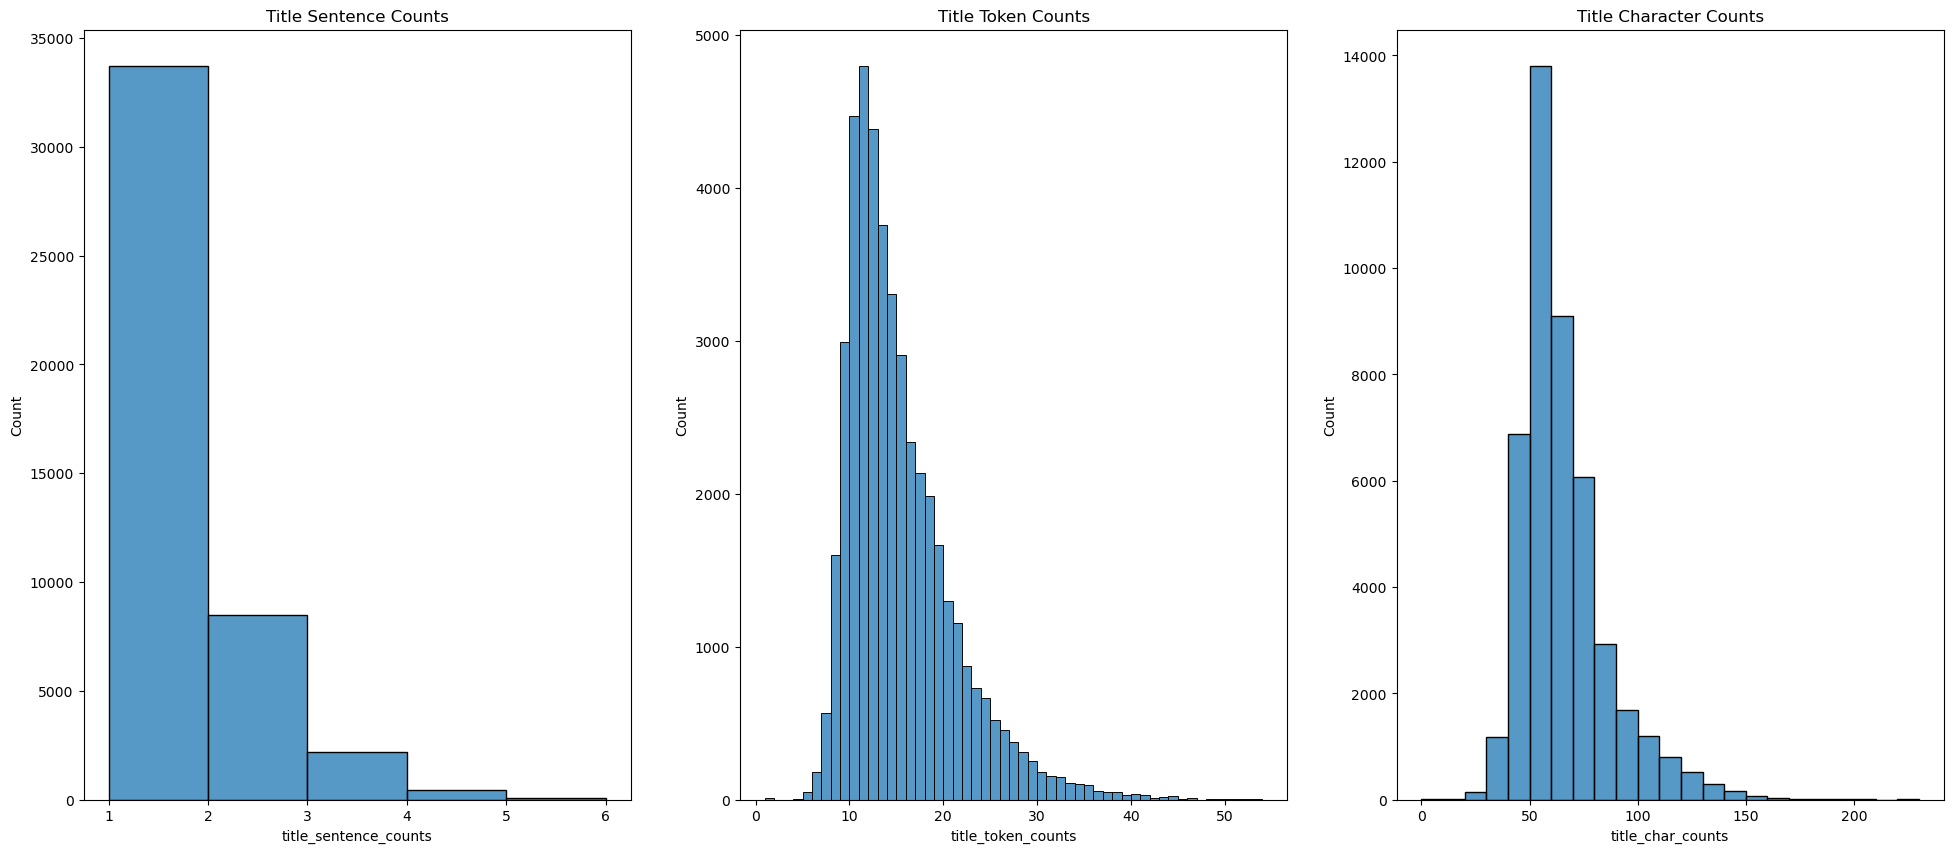

In [36]:
# Sentence, Token, Character counts
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24,10))

# ax0 - Sentence counts
sns.histplot(data=full_df, x='title_sentence_counts', binwidth=1, ax=ax0)
ax0.set_title('Title Sentence Counts')

# ax1 - Token counts
sns.histplot(data=full_df, x='title_token_counts', binwidth=1, ax=ax1)
ax1.set_title('Title Token Counts')

# ax2 - Character counts
sns.histplot(data=full_df, x='title_char_counts', binwidth=10, ax=ax2)
ax2.set_title('Title Character Counts')

In [37]:
# Averages
full_df['title_avg_wps'] = avgCalcs(full_df.title_token_counts, full_df.title_sentence_counts) # Words per sentence
full_df['title_avg_cps'] = avgCalcs(full_df.title_char_counts, full_df.title_sentence_counts) # Characters per sentence
full_df['title_avg_cpw'] = avgCalcs(full_df.title_char_counts, full_df.title_token_counts) # Characters per word

In [38]:
# Create a table
title_avgs_table = tabulate([['Measure', 'Minimum', 'Maximum'],
                             ['Avg. Words per Sentence', min(full_df['title_avg_wps']), max(full_df['title_avg_wps'])],
                             ['Avg. Characters per Sentence', min(full_df['title_avg_cps']), max(full_df['title_avg_cps'])],
                             ['Avg. Characters per Words', min(full_df['title_avg_cpw']), max(full_df['title_avg_cpw'])]],
                            headers='firstrow',
                            tablefmt='prettytable')

# Show
print(title_avgs_table)

Measure                         Minimum    Maximum
----------------------------  ---------  ---------
Avg. Words per Sentence               1      48
Avg. Characters per Sentence          0     191
Avg. Characters per Words             0       9.83


Text(0.5, 1.0, 'Title Characters per Word')

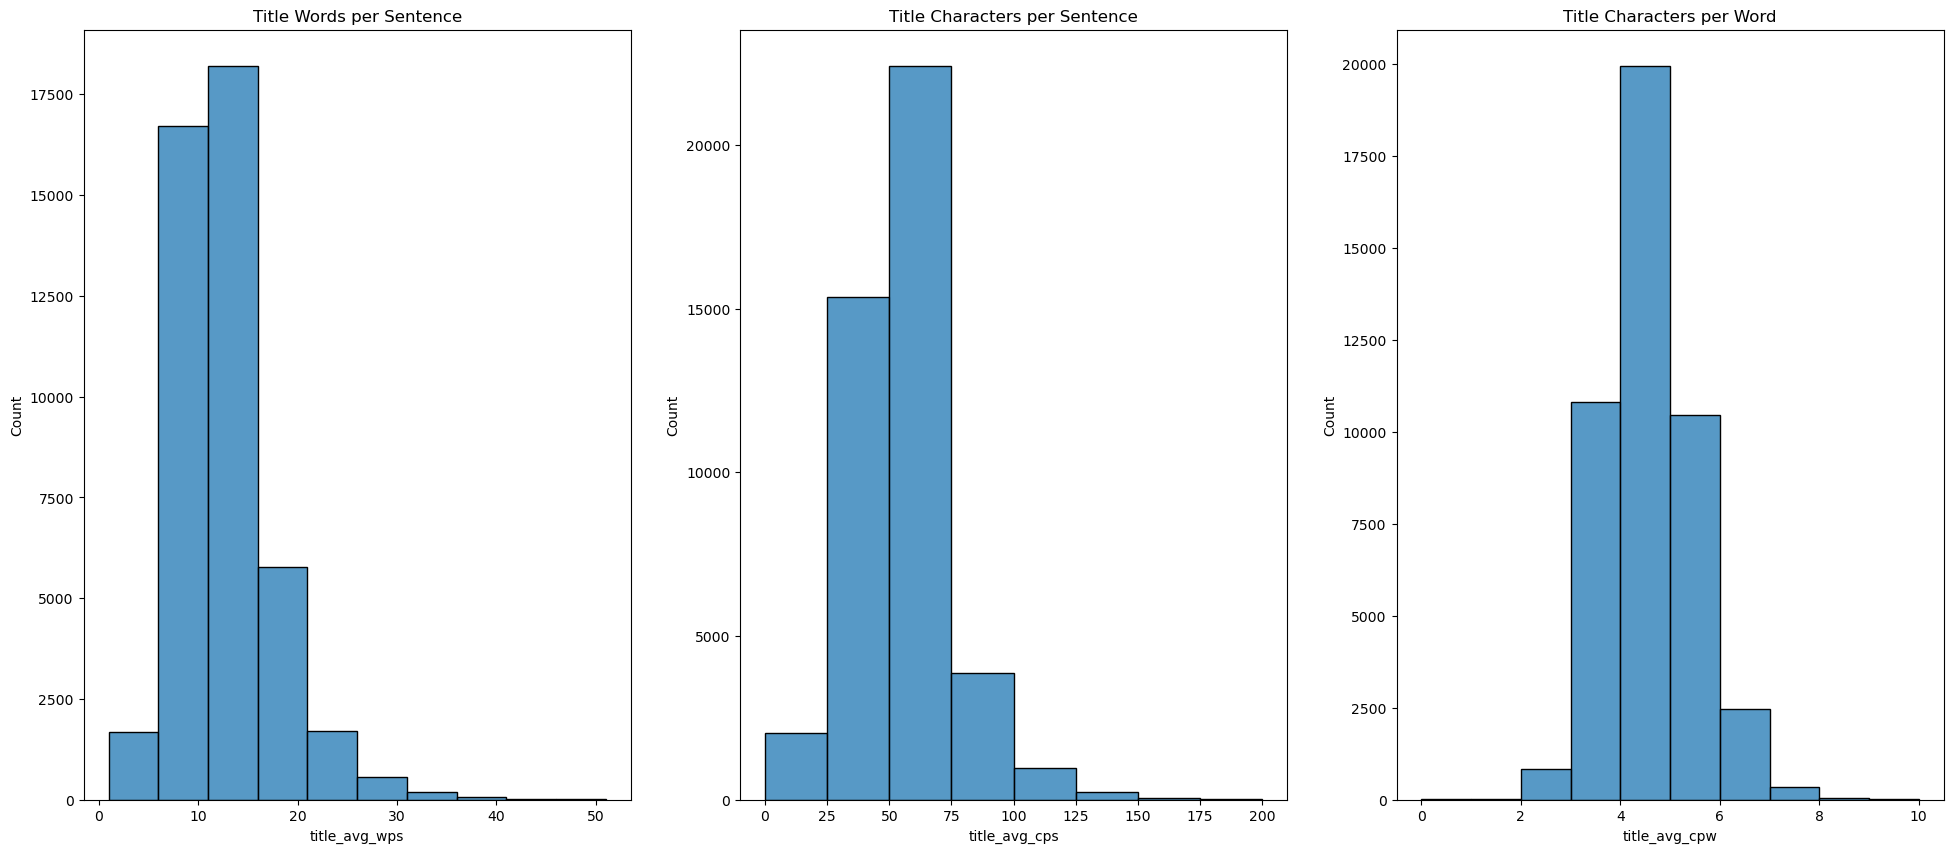

In [39]:
# Averages
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24,10))

# ax0 - wps
sns.histplot(data=full_df, x='title_avg_wps', binwidth=5, ax=ax0)
ax0.set_title('Title Words per Sentence')

# ax1 - cps
sns.histplot(data=full_df, x='title_avg_cps', binwidth=25, ax=ax1)
ax1.set_title('Title Characters per Sentence')

# ax2 - cpw
sns.histplot(data=full_df, x='title_avg_cpw', binwidth=1, ax=ax2)
ax2.set_title('Title Characters per Word')

Text(0, 0.5, 'Parts of Speech')

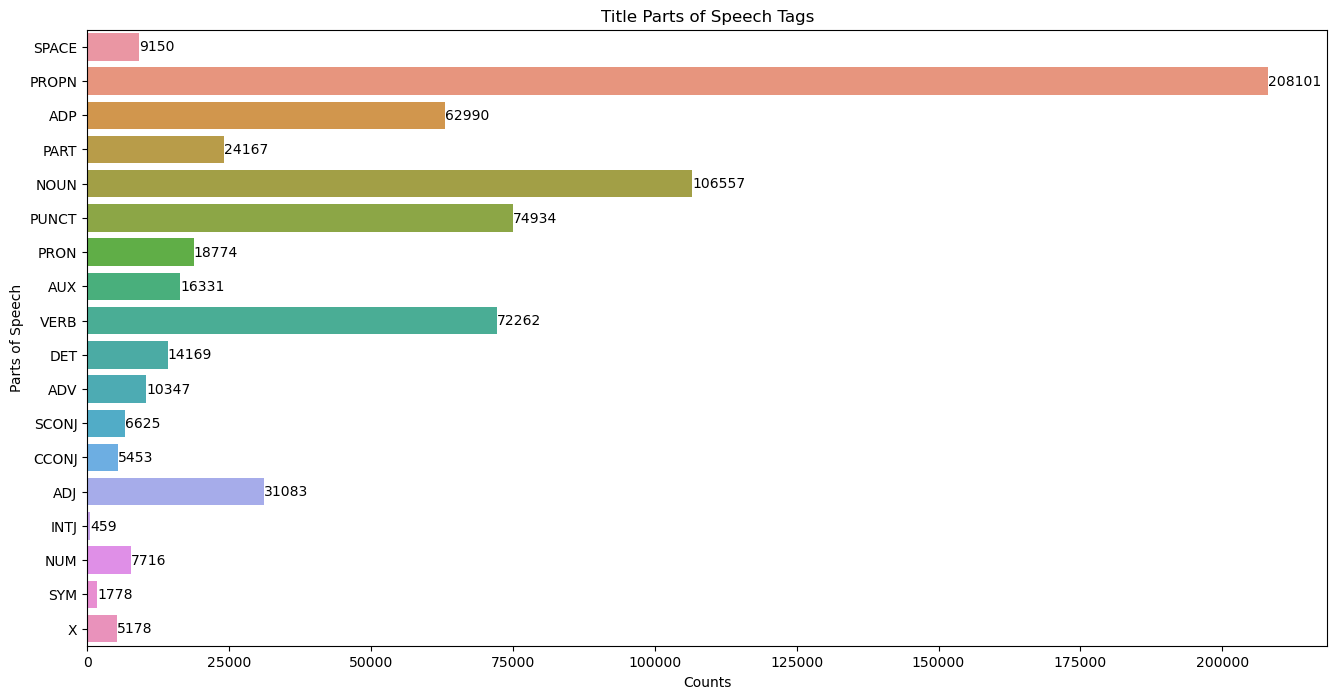

In [40]:
# Handling parts of speech
title_all_pos_tags = list(itertools.chain.from_iterable(full_df.title_pos_tags))

# Get counts
counter_title_pos_tags = Counter(title_all_pos_tags)

# Create a visualization
# Size
plt.figure(figsize=(16,8))

# Barplot
title_pos_barplot = sns.barplot(x=list(counter_title_pos_tags.values()), y=list(counter_title_pos_tags.keys()))
title_pos_barplot.bar_label(title_pos_barplot.containers[0])
title_pos_barplot.set_title('Title Parts of Speech Tags')
title_pos_barplot.set_xlabel('Counts')
title_pos_barplot.set_ylabel('Parts of Speech')

In [41]:
# Split NER 
def nerSplitter(ner_item:tuple) -> str:
    """
    Splits the tuple holding NER details.
    Isolates the NER tag.
    """
    # List holding NER tags
    ner_tags = []
    # ner_item can hold multiple tuples
    # Iterate ner_item
    for ner in ner_item:
        # Get the number of items in tuple
        ner_tuple_size = len(ner)
        # Append the last item in the tuple
        ner_tags.append(ner[ner_tuple_size-1])
    # Return
    return ner_tags
            

Text(0, 0.5, 'Named Entities')

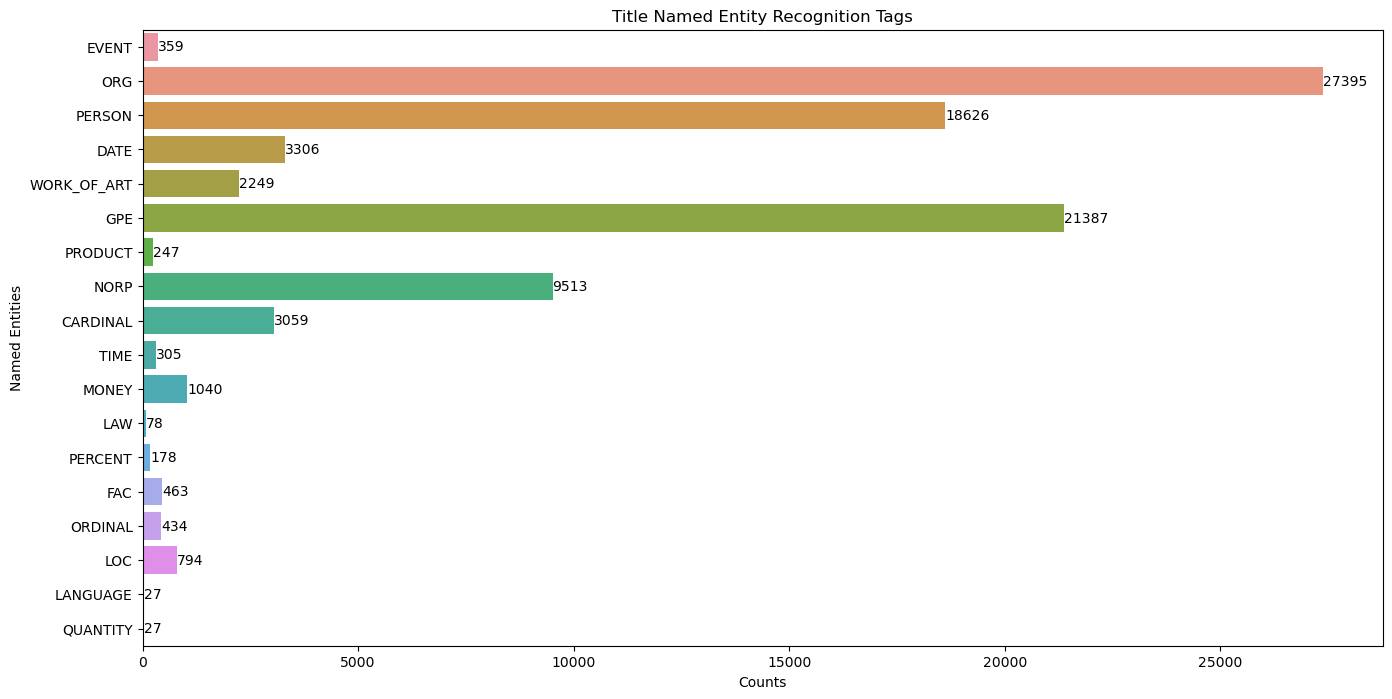

In [42]:
# Title lists of NER tags
title_only_ner = [nerSplitter(i) for i in full_df.title_ner_tags]

# Title NER meta list
title_meta_ner = list(itertools.chain.from_iterable(title_only_ner))

# Counter
counter_title_meta_ner = Counter(title_meta_ner)

# Visualize
# Size
plt.figure(figsize=(16,8))

# Barplot
title_ner_barplot = sns.barplot(x=list(counter_title_meta_ner.values()),y=list(counter_title_meta_ner.keys()))
title_ner_barplot.bar_label(title_ner_barplot.containers[0])
title_ner_barplot.set_title('Title Named Entity Recognition Tags')
title_ner_barplot.set_xlabel('Counts')
title_ner_barplot.set_ylabel('Named Entities')

In [43]:
# Count of NER tags per title
count_title_ner = [len(i) for i in title_only_ner]

# Append to dataframe
full_df['count_title_ner'] = count_title_ner

Text(0.5, 1.0, 'NER Tags in Titles')

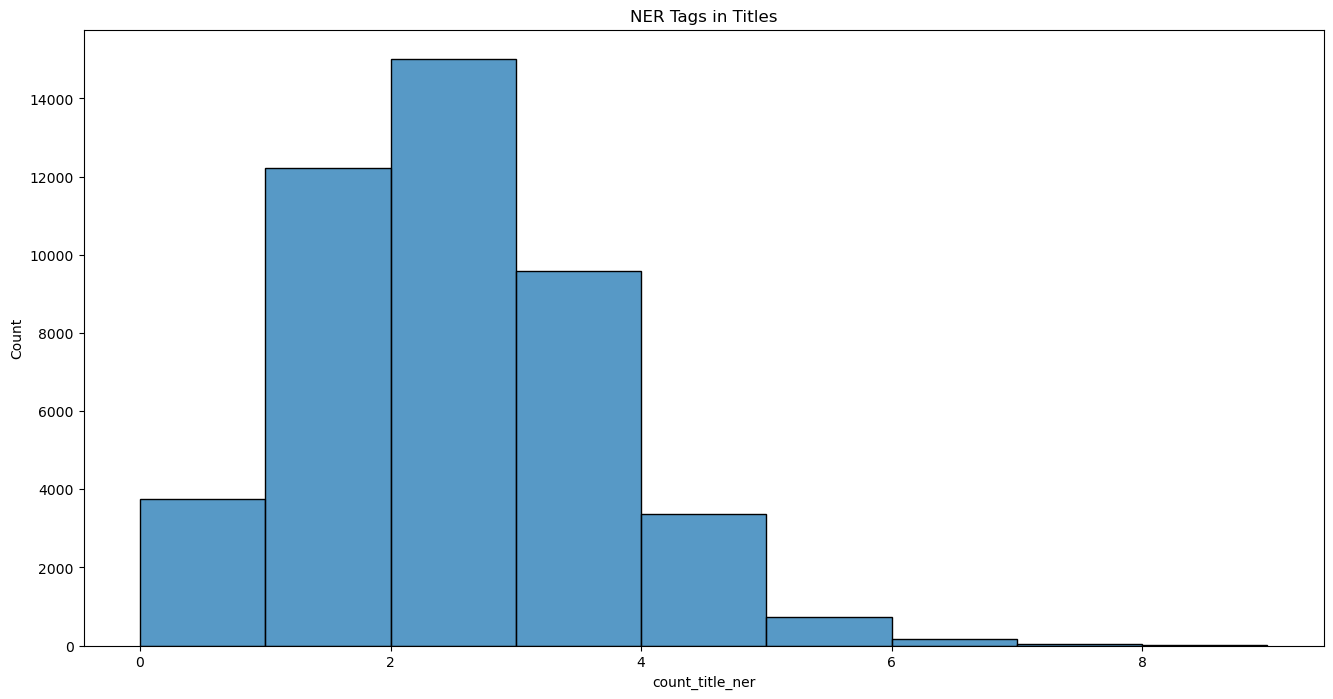

In [44]:
# Visualize 
# Size
plt.figure(figsize=(16,8))

# Histogram
title_ner_hist = sns.histplot(data=full_df, x='count_title_ner', binwidth=1)
title_ner_hist.set_title('NER Tags in Titles')

In [45]:
# Collect stopword counts
full_df['title_stopword_counts'] = [showStoppers(t) for t in full_df.title_tokens]

Text(0.5, 1.0, 'Title Stopword Counts')

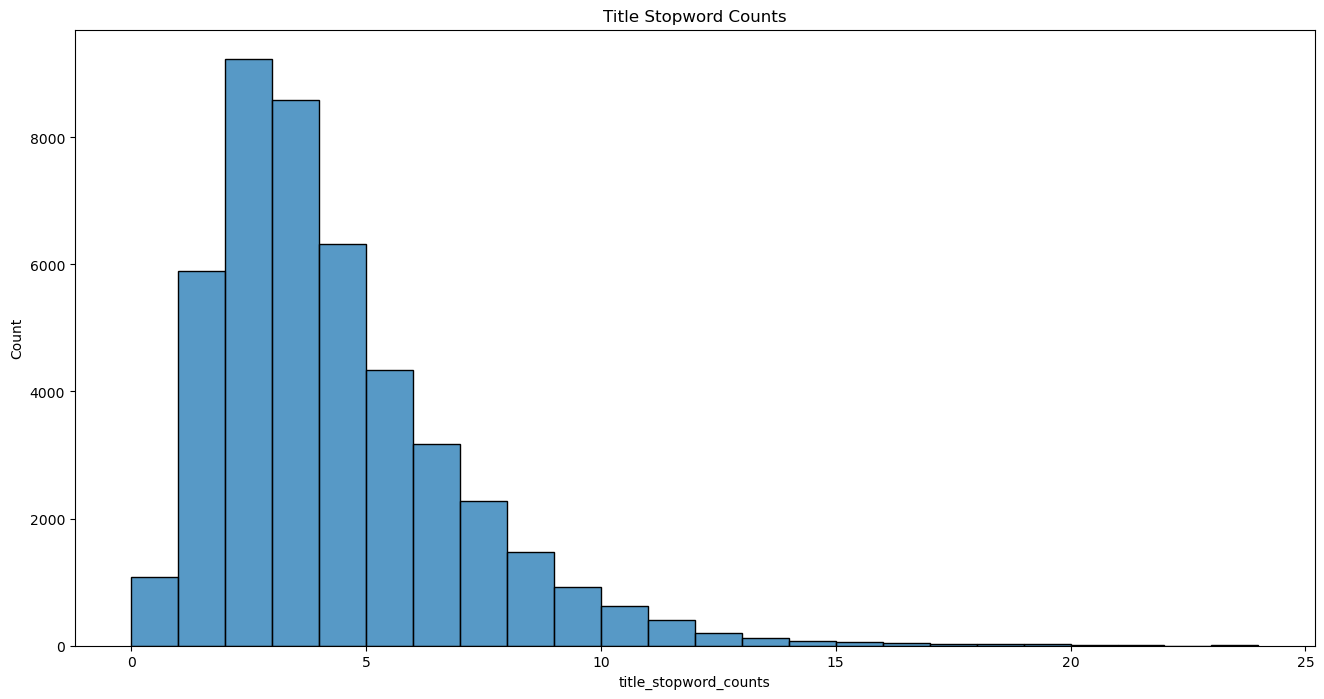

In [46]:
# Size
plt.figure(figsize=(16,8))

# Visualization
title_stopword_hist = sns.histplot(data=full_df, x='title_stopword_counts', binwidth=1)
title_stopword_hist.set_title('Title Stopword Counts')

### Text Exploration

In [47]:
# Columns to focus on 
text_stat_cols = ['texts_sentence_counts', 'texts_token_counts', 'texts_char_counts']

# Dictionary
text_stats_dict = {'Sentence Counts': {'Minimum': min(full_df.texts_sentence_counts), 
                                        'Maximum': max(full_df.texts_sentence_counts),
                                        'Mean': np.mean(full_df.texts_sentence_counts),
                                        'Median':statistics.median(full_df.texts_sentence_counts),
                                        'Mode': Counter(full_df.texts_sentence_counts).most_common(1)[0][0],
                                        'Standard Deviation': np.std(full_df.texts_sentence_counts)},
                    'Token Counts': {'Minimum': min(full_df.texts_token_counts), 
                                     'Maximum': max(full_df.texts_token_counts),
                                     'Mean': np.mean(full_df.texts_token_counts),
                                     'Median':statistics.median(full_df.texts_token_counts),
                                     'Mode': Counter(full_df.texts_token_counts).most_common(1)[0][0],
                                     'Standard Deviation': np.std(full_df.texts_token_counts)},
                    'Character Counts': {'Minimum': min(full_df.texts_char_counts), 
                                         'Maximum': max(full_df.texts_char_counts),
                                         'Mean': np.mean(full_df.texts_char_counts),
                                         'Median':statistics.median(full_df.texts_char_counts),
                                         'Mode': Counter(full_df.texts_char_counts).most_common(1)[0][0],
                                         'Standard Deviation': np.std(full_df.texts_char_counts)}}

In [48]:
# Create a table
text_stats_table = tabulate([['Statistics', 'Sentences', 'Tokens', 'Characters'],
                              ['Minimum', text_stats_dict['Sentence Counts']['Minimum'], text_stats_dict['Token Counts']['Minimum'], text_stats_dict['Character Counts']['Minimum']],
                              ['Maximum', text_stats_dict['Sentence Counts']['Maximum'], text_stats_dict['Token Counts']['Maximum'], text_stats_dict['Character Counts']['Maximum']], 
                              ['Mean', text_stats_dict['Sentence Counts']['Mean'], text_stats_dict['Token Counts']['Mean'], text_stats_dict['Character Counts']['Mean']], 
                              ['Median', text_stats_dict['Sentence Counts']['Median'], text_stats_dict['Token Counts']['Median'], text_stats_dict['Character Counts']['Median']], 
                              ['Mode', text_stats_dict['Sentence Counts']['Mode'], text_stats_dict['Token Counts']['Mode'], text_stats_dict['Character Counts']['Mode']], 
                              ['Std. Deviation', text_stats_dict['Sentence Counts']['Standard Deviation'], text_stats_dict['Token Counts']['Standard Deviation'], text_stats_dict['Character Counts']['Standard Deviation']]],
                            headers='firstrow',
                            tablefmt='prettytable')

# Show
print(text_stats_table)

Statistics        Sentences    Tokens    Characters
--------------  -----------  --------  ------------
Minimum              1          0              0
Maximum            372       9304          41864
Mean                18.3604   463.514       1964.89
Median              16        413           1739
Mode                 3          0              0
Std. Deviation      15.8447   403.421       1740.07


Text(0.5, 1.0, 'Text Character Counts')

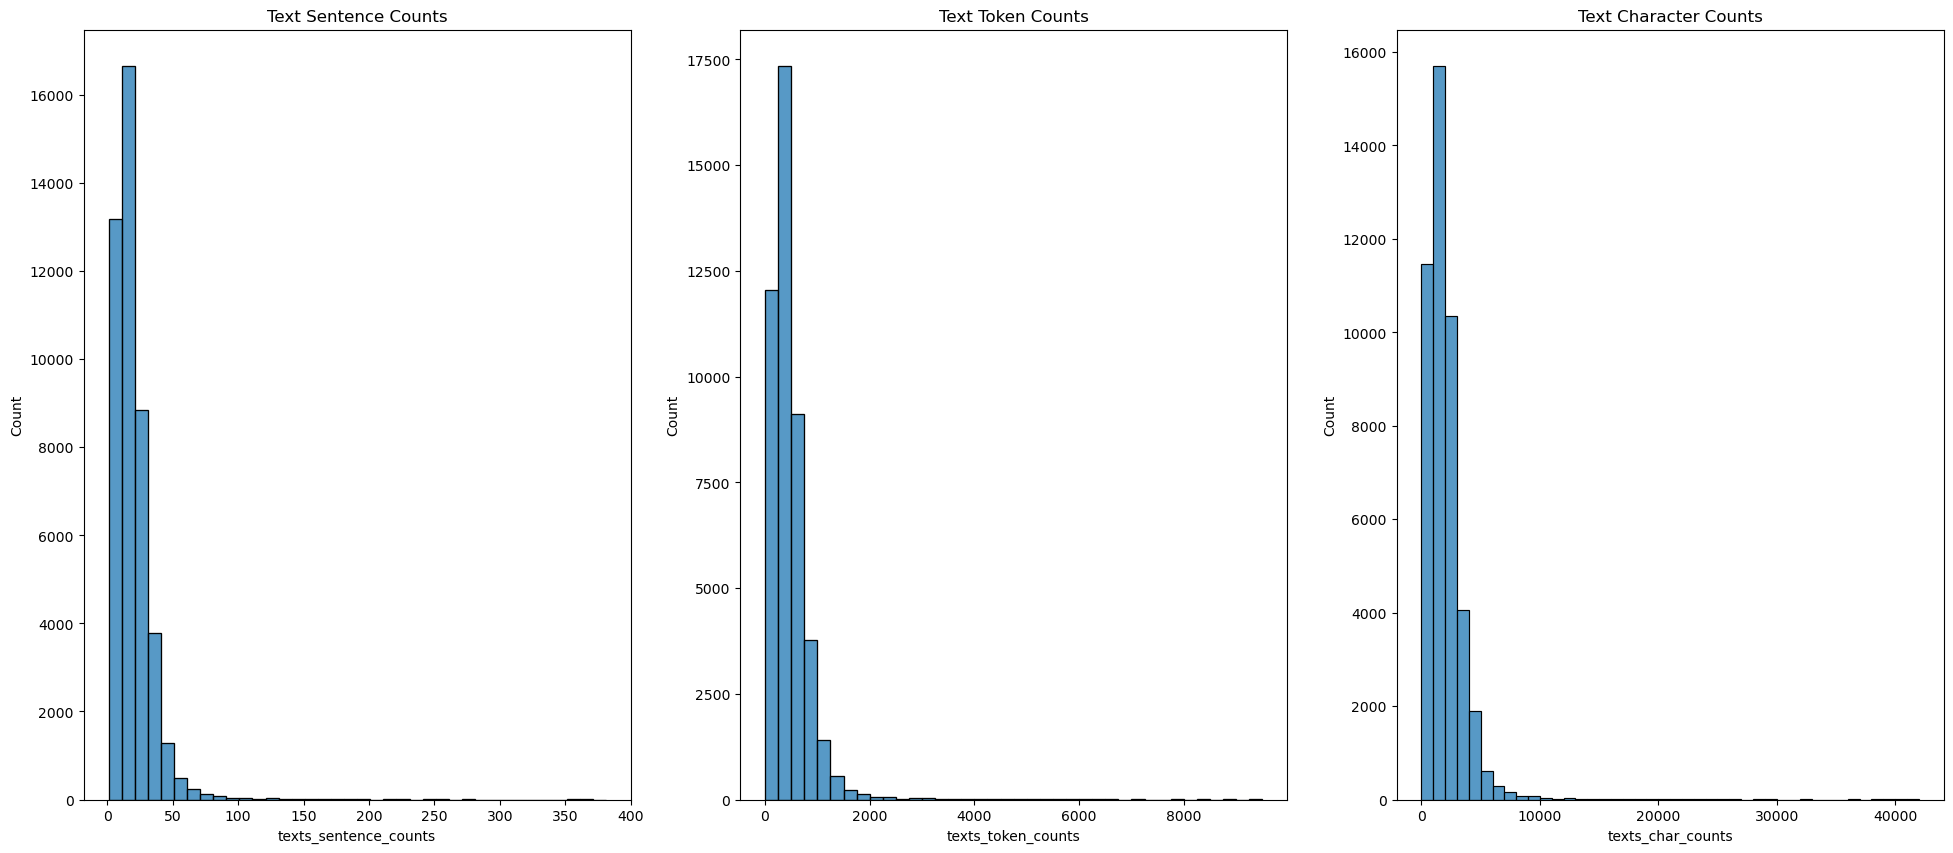

In [49]:
# Sentence, Token, Character counts
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24,10))

# ax0 - Sentence counts
sns.histplot(data=full_df, x='texts_sentence_counts', binwidth= 10, ax=ax0)
ax0.set_title('Text Sentence Counts')

# ax1 - Token counts
sns.histplot(data=full_df, x='texts_token_counts', binwidth=250, ax=ax1)
ax1.set_title('Text Token Counts')

# ax2 - Character counts
sns.histplot(data=full_df, x='texts_char_counts', binwidth=1000, ax=ax2)
ax2.set_title('Text Character Counts')

In [50]:
# Averages
full_df['text_avg_wps'] = avgCalcs(full_df.texts_token_counts, full_df.texts_sentence_counts) # Words per sentence
full_df['text_avg_cps'] = avgCalcs(full_df.texts_char_counts, full_df.texts_sentence_counts) # Characters per sentence
full_df['text_avg_cpw'] = avgCalcs(full_df.texts_char_counts, full_df.texts_token_counts) # Characters per word

In [51]:
# Create a table
text_avgs_table = tabulate([['Measure', 'Minimum', 'Maximum'],
                             ['Avg. Words per Sentence', min(full_df['text_avg_wps']), max(full_df['text_avg_wps'])],
                             ['Avg. Characters per Sentence', min(full_df['text_avg_cps']), max(full_df['text_avg_cps'])],
                             ['Avg. Characters per Words', min(full_df['text_avg_cpw']), max(full_df['text_avg_cpw'])]],
                            headers='firstrow',
                            tablefmt='prettytable')

# Show
print(text_avgs_table)

Measure                         Minimum    Maximum
----------------------------  ---------  ---------
Avg. Words per Sentence               0      150.4
Avg. Characters per Sentence          0      755.8
Avg. Characters per Words             0        9


Text(0.5, 1.0, 'Text Characters per Word')

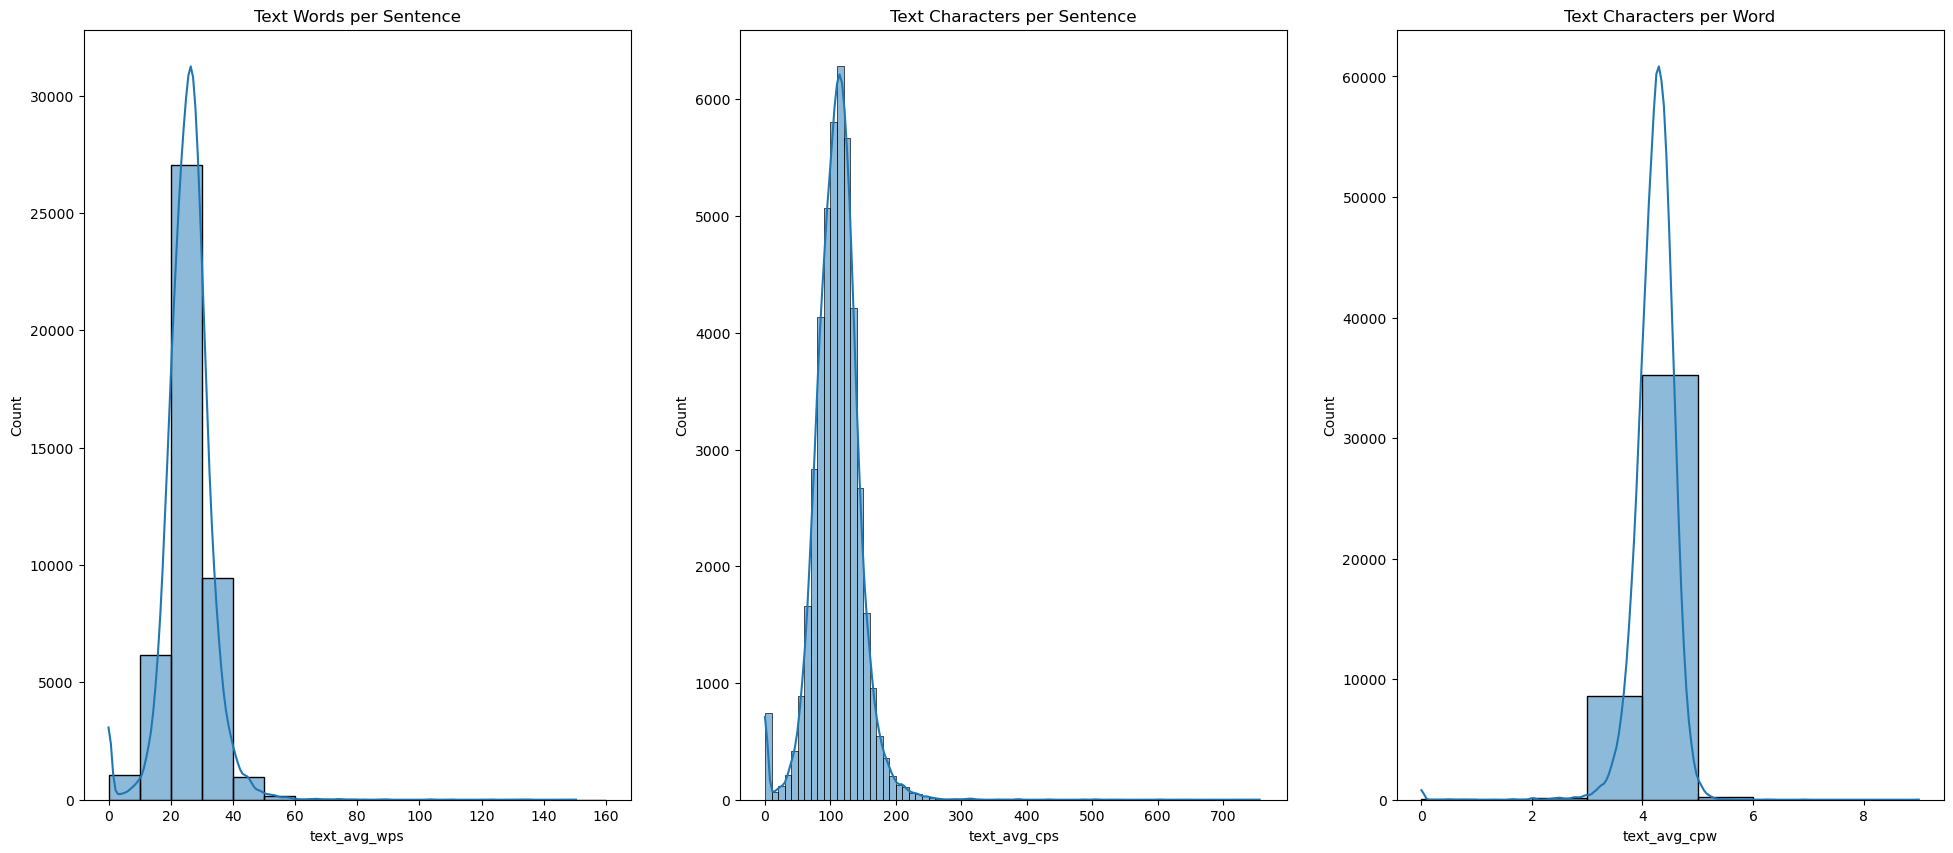

In [52]:
# Averages
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24,10))

# ax0 - wps
sns.histplot(data=full_df, x='text_avg_wps', binwidth=10, kde=True, ax=ax0)
ax0.set_title('Text Words per Sentence')

# ax1 - cps
sns.histplot(data=full_df, x='text_avg_cps', binwidth=10, kde=True, ax=ax1)
ax1.set_title('Text Characters per Sentence')

# ax2 - cpw
sns.histplot(data=full_df, x='text_avg_cpw', binwidth=1, kde=True, ax=ax2)
ax2.set_title('Text Characters per Word')

Text(0, 0.5, 'Parts of Speech')

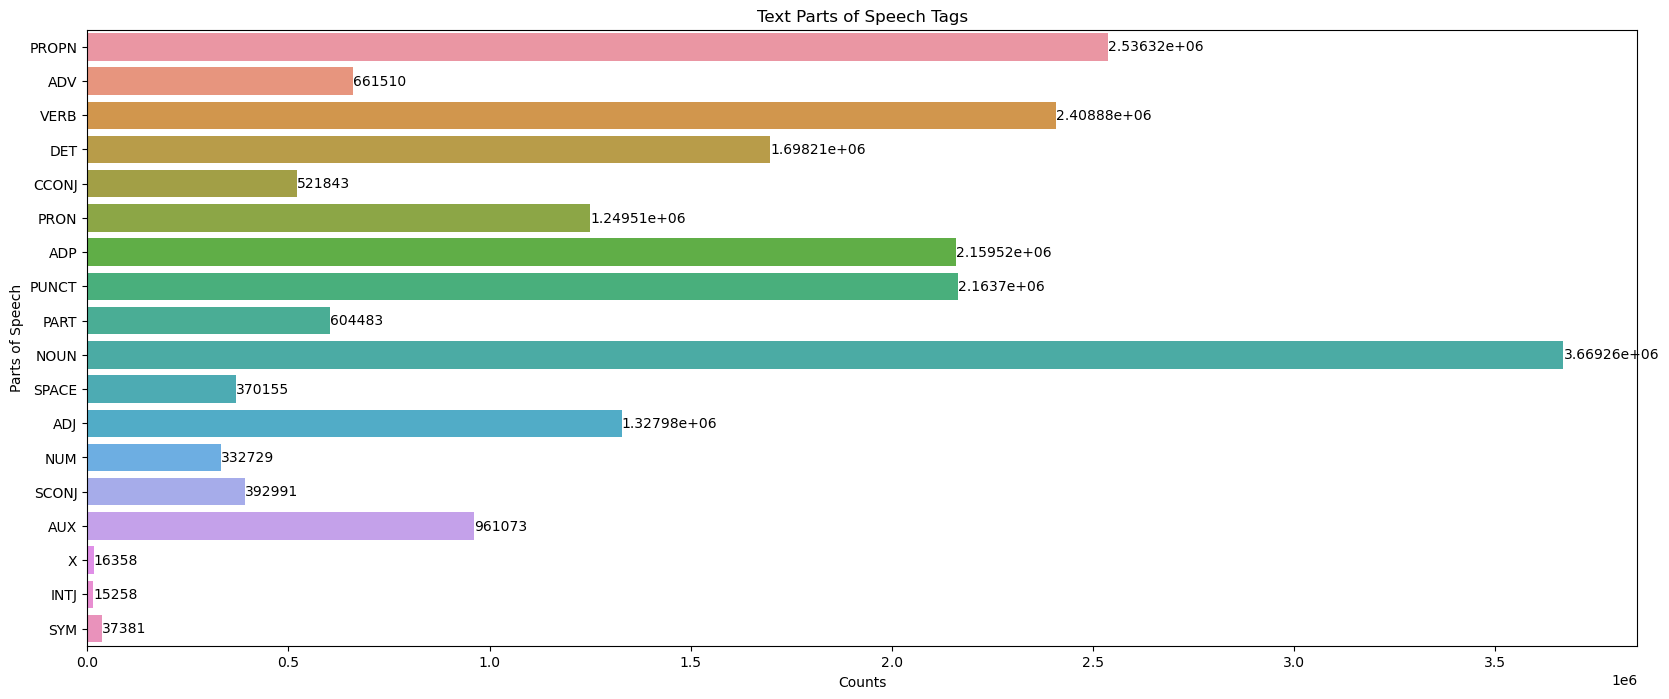

In [53]:
# Handling parts of speech
text_all_pos_tags = list(itertools.chain.from_iterable(full_df.texts_pos_tags))

# Get counts
counter_text_pos_tags = Counter(text_all_pos_tags)

# Create a visualization
# Size
plt.figure(figsize=(20,8))

# Barplot
text_pos_barplot = sns.barplot(x=list(counter_text_pos_tags.values()), y=list(counter_text_pos_tags.keys()))
text_pos_barplot.bar_label(text_pos_barplot.containers[0])
text_pos_barplot.set_title('Text Parts of Speech Tags')
text_pos_barplot.set_xlabel('Counts')
text_pos_barplot.set_ylabel('Parts of Speech')

Text(0, 0.5, 'Named Entities')

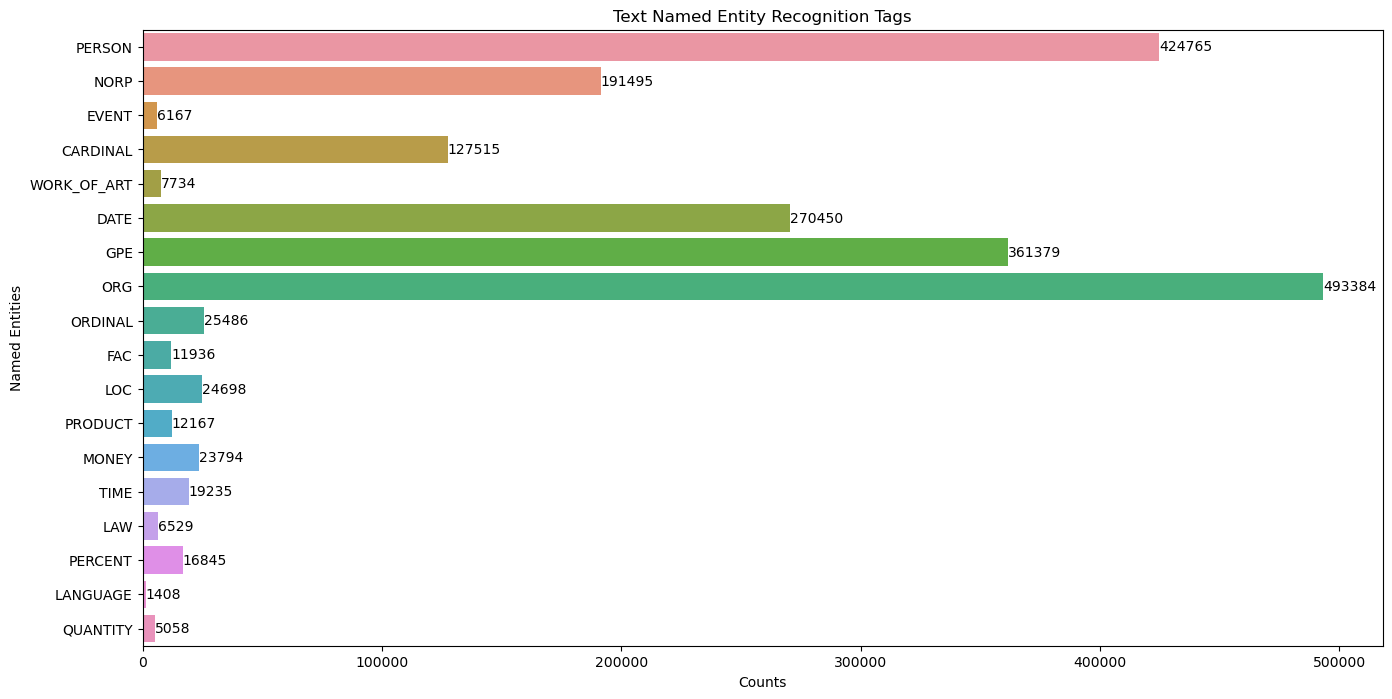

In [54]:
# Text lists of NER tags
text_only_ner = [nerSplitter(i) for i in full_df.texts_ner_tags]

# Text NER meta list
text_meta_ner = list(itertools.chain.from_iterable(text_only_ner))

# Counter
counter_text_meta_ner = Counter(text_meta_ner)

# Visualize
# Size
plt.figure(figsize=(16,8))

# Barplot
text_ner_barplot = sns.barplot(x=list(counter_text_meta_ner.values()),y=list(counter_text_meta_ner.keys()))
text_ner_barplot.bar_label(text_ner_barplot.containers[0])
text_ner_barplot.set_title('Text Named Entity Recognition Tags')
text_ner_barplot.set_xlabel('Counts')
text_ner_barplot.set_ylabel('Named Entities')

In [55]:
# Count of NER tags per text
count_text_ner = [len(i) for i in text_only_ner]

# Append to dataframe
full_df['count_text_ner'] = count_text_ner

Text(0.5, 1.0, 'NER Tags in Texts')

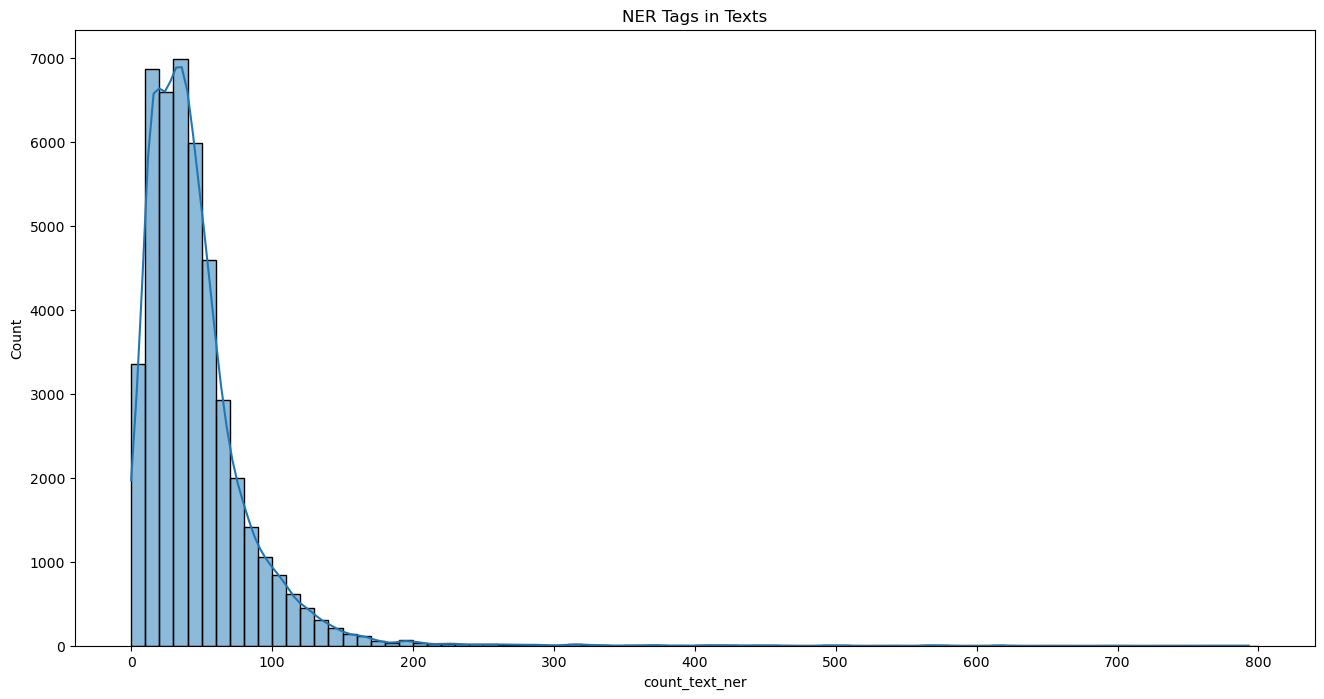

In [56]:
# Visualize 
# Size
plt.figure(figsize=(16,8))

# Histogram
text_ner_hist = sns.histplot(data=full_df, x='count_text_ner', binwidth=10, kde=True)
text_ner_hist.set_title('NER Tags in Texts')

In [57]:
# Collect stopword counts
full_df['text_stopword_counts'] = [showStoppers(t) for t in full_df.texts_tokens]

Text(0.5, 1.0, 'Text Stopword Counts')

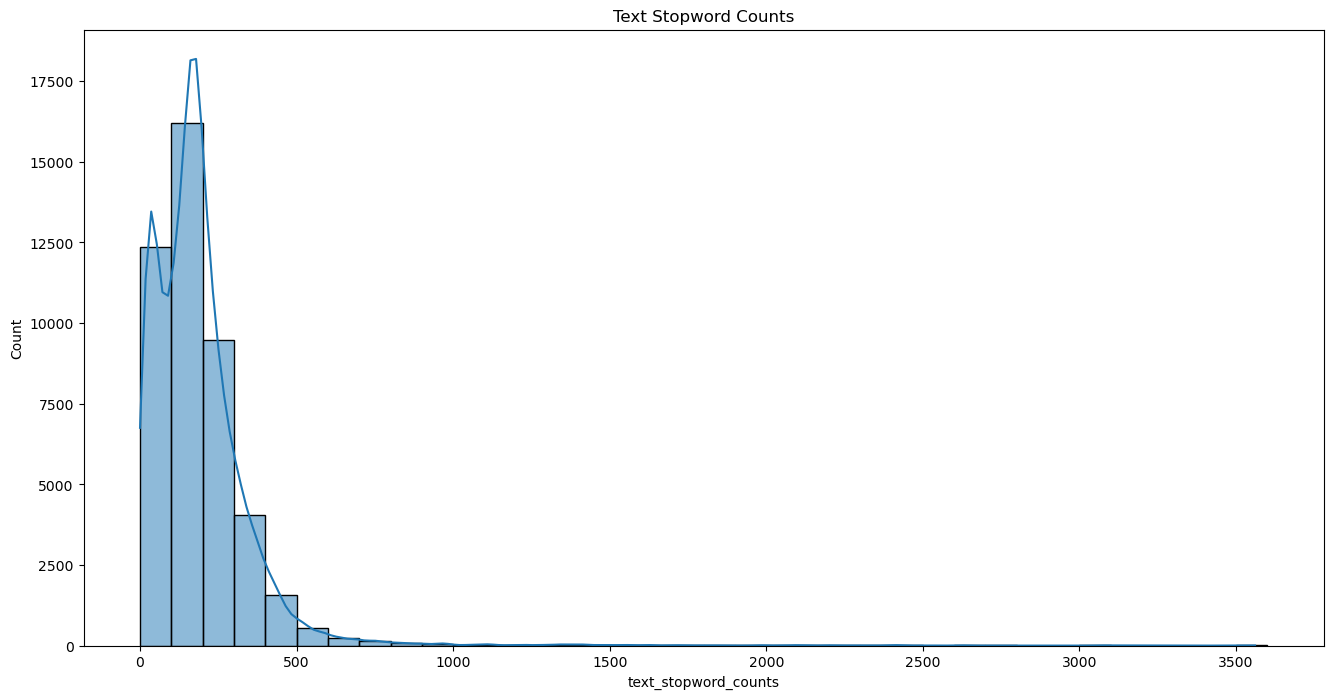

In [58]:
# Size
plt.figure(figsize=(16,8))

# Visualization
text_stopword_hist = sns.histplot(data=full_df, x='text_stopword_counts', binwidth=100, kde=True)
text_stopword_hist.set_title('Text Stopword Counts')

__Observation__

Looking at several of the count columns, there appears to be multiple peaks within their histograms. This suggests that there are at least two distinct groups based off these variables.

- Within texts:
    - Sentence counts
    - Token counts
    - Character counts
    - Stopword counts
    
Note that there does not appear to be the same pattern for titles. Regardless, the next step is to look at differences between fake and real news categories.

## Fake vs. Real News Comparisons

In [59]:
# Counts of each
count_fake = fake_df.shape[0]
count_real = true_df.shape[0]

### Titles

In [60]:
# Dictionary
true_title_stats_dict = {'Sentence Counts': {'Minimum': min(full_df.title_sentence_counts[full_df.label == 'true']), 
                                             'Maximum': max(full_df.title_sentence_counts[full_df.label == 'true']),
                                             'Mean': np.mean(full_df.title_sentence_counts[full_df.label == 'true']),
                                             'Median':statistics.median(full_df.title_sentence_counts[full_df.label == 'true']),
                                             'Mode': Counter(full_df.title_sentence_counts[full_df.label == 'true']).most_common(1)[0][0],
                                             'Standard Deviation': np.std(full_df.title_sentence_counts[full_df.label == 'true'])},
                    'Token Counts': {'Minimum': min(full_df.title_token_counts[full_df.label == 'true']), 
                                     'Maximum': max(full_df.title_token_counts[full_df.label == 'true']),
                                     'Mean': np.mean(full_df.title_token_counts[full_df.label == 'true']),
                                     'Median':statistics.median(full_df.title_token_counts[full_df.label == 'true']),
                                     'Mode': Counter(full_df.title_token_counts[full_df.label == 'true']).most_common(1)[0][0],
                                     'Standard Deviation': np.std(full_df.title_token_counts[full_df.label == 'true'])},
                    'Character Counts': {'Minimum': min(full_df.title_char_counts[full_df.label == 'true']), 
                                         'Maximum': max(full_df.title_char_counts[full_df.label == 'true']),
                                         'Mean': np.mean(full_df.title_char_counts[full_df.label == 'true']),
                                         'Median':statistics.median(full_df.title_char_counts[full_df.label == 'true']),
                                         'Mode': Counter(full_df.title_char_counts[full_df.label == 'true']).most_common(1)[0][0],
                                         'Standard Deviation': np.std(full_df.title_char_counts[full_df.label == 'true'])}}

In [61]:
# Dictionary
fake_title_stats_dict = {'Sentence Counts': {'Minimum': min(full_df.title_sentence_counts[full_df.label == 'fake']), 
                                             'Maximum': max(full_df.title_sentence_counts[full_df.label == 'fake']),
                                             'Mean': np.mean(full_df.title_sentence_counts[full_df.label == 'fake']),
                                             'Median':statistics.median(full_df.title_sentence_counts[full_df.label == 'fake']),
                                             'Mode': Counter(full_df.title_sentence_counts[full_df.label == 'fake']).most_common(1)[0][0],
                                             'Standard Deviation': np.std(full_df.title_sentence_counts[full_df.label == 'fake'])},
                    'Token Counts': {'Minimum': min(full_df.title_token_counts[full_df.label == 'fake']), 
                                     'Maximum': max(full_df.title_token_counts[full_df.label == 'fake']),
                                     'Mean': np.mean(full_df.title_token_counts[full_df.label == 'fake']),
                                     'Median':statistics.median(full_df.title_token_counts[full_df.label == 'fake']),
                                     'Mode': Counter(full_df.title_token_counts[full_df.label == 'fake']).most_common(1)[0][0],
                                     'Standard Deviation': np.std(full_df.title_token_counts[full_df.label == 'fake'])},
                    'Character Counts': {'Minimum': min(full_df.title_char_counts[full_df.label == 'fake']), 
                                         'Maximum': max(full_df.title_char_counts[full_df.label == 'fake']),
                                         'Mean': np.mean(full_df.title_char_counts[full_df.label == 'fake']),
                                         'Median':statistics.median(full_df.title_char_counts[full_df.label == 'fake']),
                                         'Mode': Counter(full_df.title_char_counts[full_df.label == 'fake']).most_common(1)[0][0],
                                         'Standard Deviation': np.std(full_df.title_char_counts[full_df.label == 'fake'])}}

In [62]:
# Create a table
true_false_title_stats_table = tabulate([['Statistics', 'Sentences (Real)', 'Sentences (Fake)', 'Tokens (Real)', 'Tokens (Fake)', 'Characters (Real)', 'Characters (Fake)'],
                              ['Minimum', true_title_stats_dict['Sentence Counts']['Minimum'], fake_title_stats_dict['Sentence Counts']['Minimum'], true_title_stats_dict['Token Counts']['Minimum'], fake_title_stats_dict['Token Counts']['Minimum'], true_title_stats_dict['Character Counts']['Minimum'], fake_title_stats_dict['Character Counts']['Minimum']],
                              ['Maximum', true_title_stats_dict['Sentence Counts']['Maximum'], fake_title_stats_dict['Sentence Counts']['Maximum'], true_title_stats_dict['Token Counts']['Maximum'], fake_title_stats_dict['Token Counts']['Maximum'], true_title_stats_dict['Character Counts']['Maximum'], fake_title_stats_dict['Character Counts']['Maximum']], 
                              ['Mean', true_title_stats_dict['Sentence Counts']['Mean'], fake_title_stats_dict['Sentence Counts']['Mean'], true_title_stats_dict['Token Counts']['Mean'], fake_title_stats_dict['Token Counts']['Mean'], true_title_stats_dict['Character Counts']['Mean'], fake_title_stats_dict['Character Counts']['Mean']], 
                              ['Median', true_title_stats_dict['Sentence Counts']['Median'], fake_title_stats_dict['Sentence Counts']['Median'], true_title_stats_dict['Token Counts']['Median'], fake_title_stats_dict['Token Counts']['Median'], true_title_stats_dict['Character Counts']['Median'], fake_title_stats_dict['Character Counts']['Median']], 
                              ['Mode', true_title_stats_dict['Sentence Counts']['Mode'], fake_title_stats_dict['Sentence Counts']['Mode'], true_title_stats_dict['Token Counts']['Mode'], fake_title_stats_dict['Token Counts']['Mode'], true_title_stats_dict['Character Counts']['Mode'], fake_title_stats_dict['Character Counts']['Mode']], 
                              ['Std. Deviation', true_title_stats_dict['Sentence Counts']['Standard Deviation'], fake_title_stats_dict['Sentence Counts']['Standard Deviation'], true_title_stats_dict['Token Counts']['Standard Deviation'], fake_title_stats_dict['Token Counts']['Standard Deviation'], true_title_stats_dict['Character Counts']['Standard Deviation'], fake_title_stats_dict['Character Counts']['Standard Deviation']]],
                            headers='firstrow',
                            tablefmt='prettytable')

# Show
print(true_false_title_stats_table)

Statistics        Sentences (Real)    Sentences (Fake)    Tokens (Real)    Tokens (Fake)    Characters (Real)    Characters (Fake)
--------------  ------------------  ------------------  ---------------  ---------------  -------------------  -------------------
Minimum                   1                   1                 4                1                   22                     0
Maximum                   3                   6                24               54                  108                   228
Mean                      1.04025             1.58162          11.1616          18.2249              53.2982               75.5355
Median                    1                   1                11               17                   53                    72
Mode                      1                   1                11               15                   51                    68
Std. Deviation            0.201004            0.761825          2.18525          5.89984              7

Text(0.5, 1.0, 'Title Character Counts (True)')

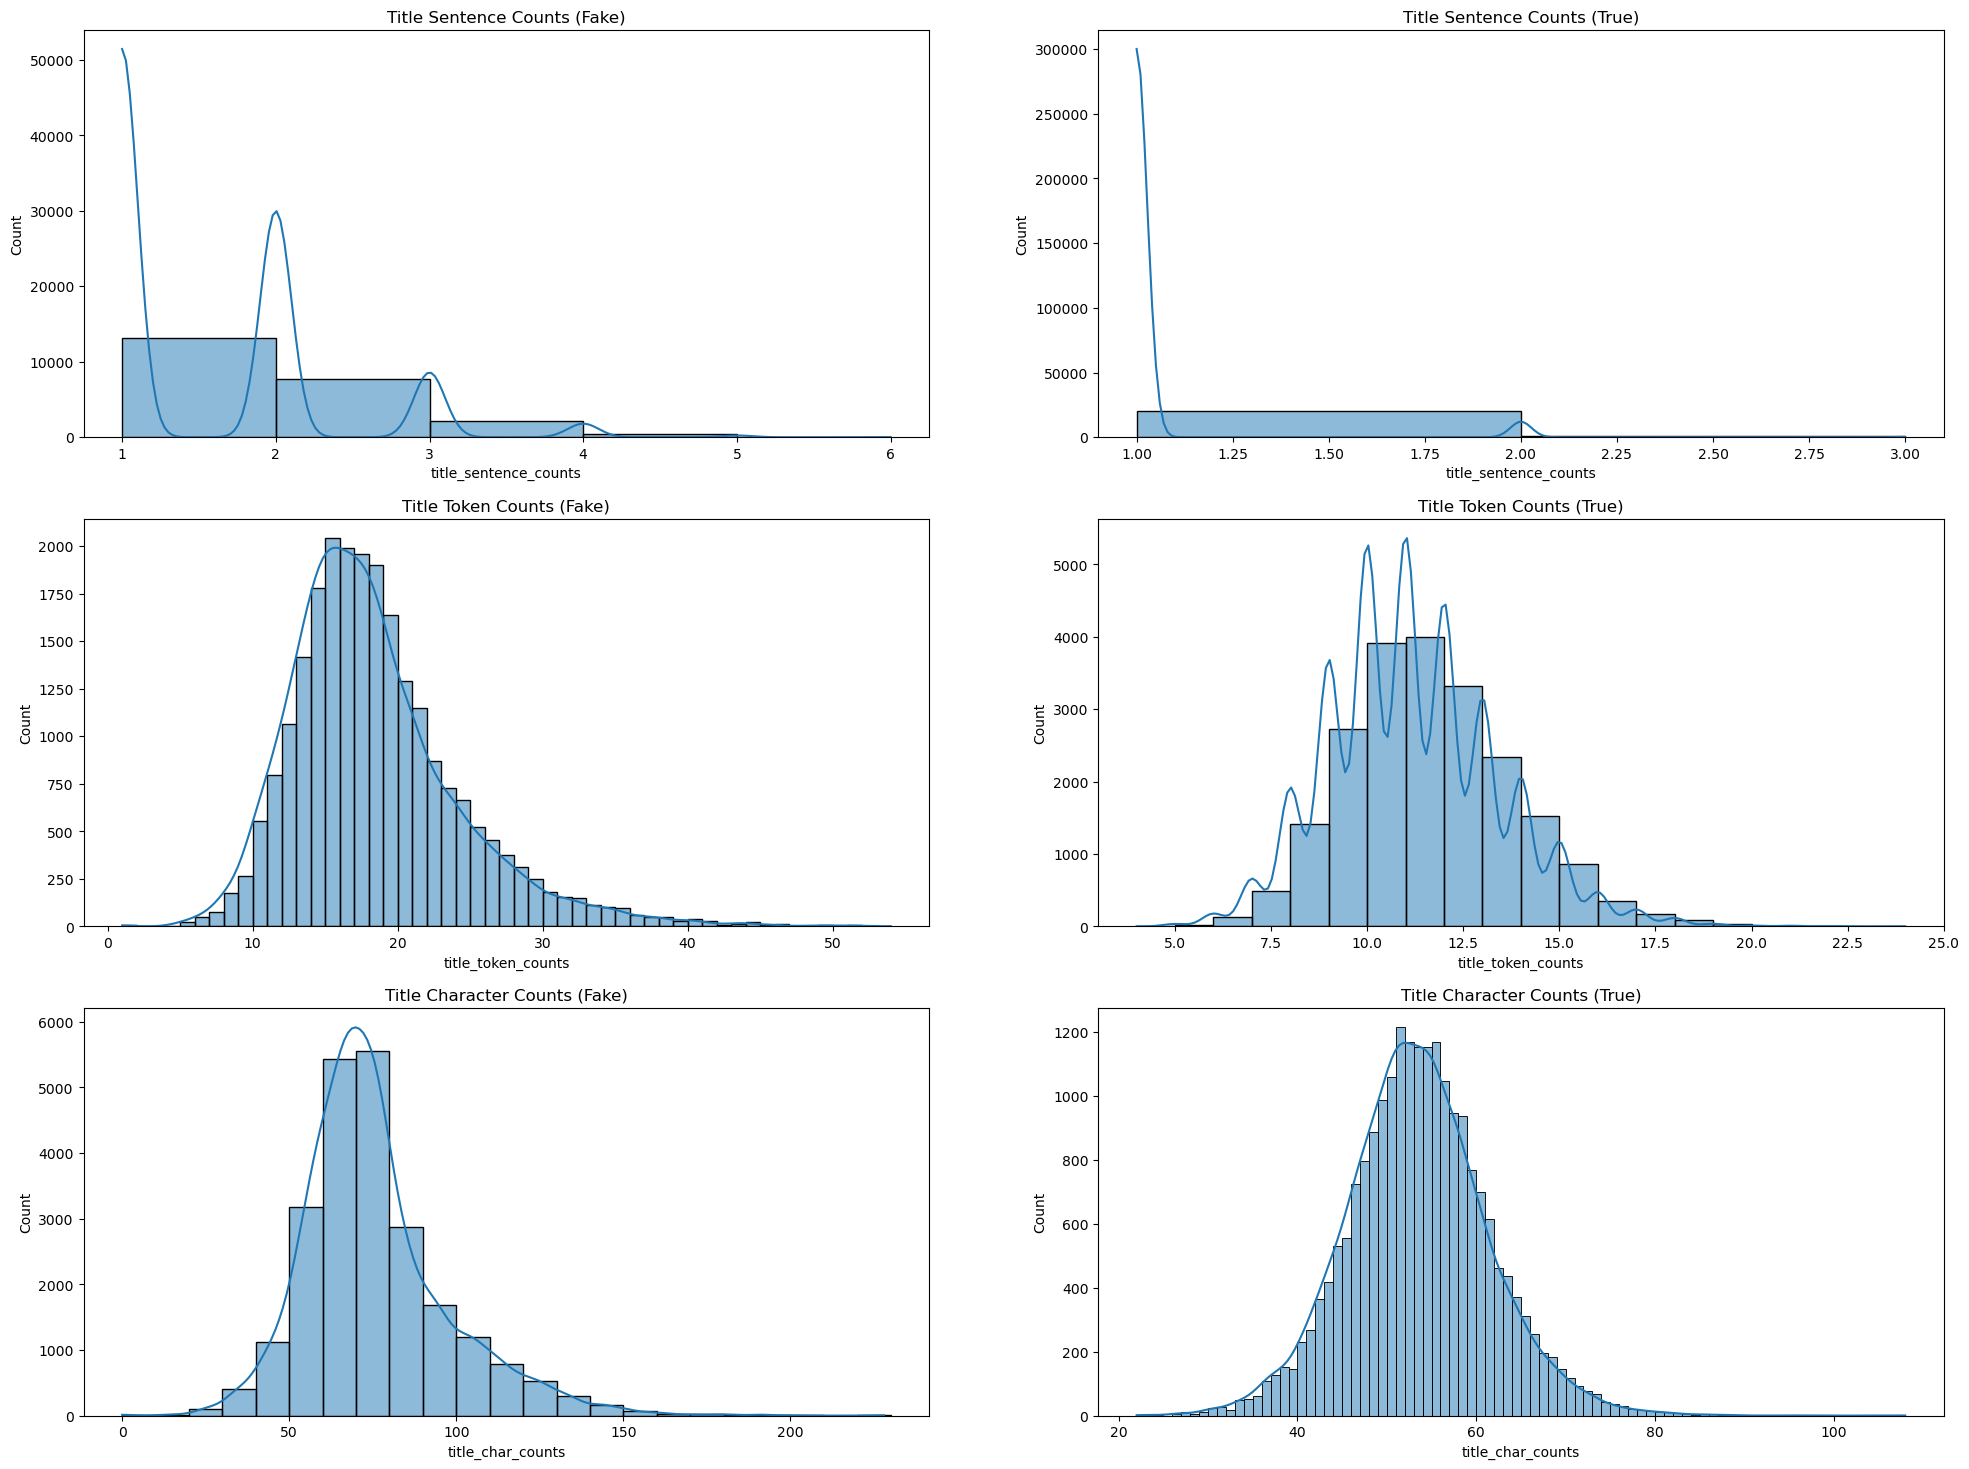

In [63]:
# Sentence, Token, Character counts
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, figsize=(24,18))

# ax0 - Sentence counts, fake
sns.histplot(data=full_df[full_df.label == 'fake'], x='title_sentence_counts', binwidth=1, kde=True, ax=ax0)
ax0.set_title('Title Sentence Counts (Fake)')

# ax1 - Sentence counts, true
sns.histplot(data=full_df[full_df.label == 'true'], x='title_sentence_counts', binwidth=1, kde=True, ax=ax1)
ax1.set_title('Title Sentence Counts (True)')

# ax2 - Token counts, fake
sns.histplot(data=full_df[full_df.label == 'fake'], x='title_token_counts', binwidth=1, kde=True, ax=ax2)
ax2.set_title('Title Token Counts (Fake)')

# ax3 - Token counts, true
sns.histplot(data=full_df[full_df.label == 'true'], x='title_token_counts', binwidth=1, kde=True, ax=ax3)
ax3.set_title('Title Token Counts (True)')

# ax4 - Character counts, fake
sns.histplot(data=full_df[full_df.label == 'fake'], x='title_char_counts', binwidth=10, kde=True, ax=ax4)
ax4.set_title('Title Character Counts (Fake)')

# ax5 - Character counts, fake
sns.histplot(data=full_df[full_df.label == 'true'], x='title_char_counts', binwidth=1, kde=True, ax=ax5)
ax5.set_title('Title Character Counts (True)')

In [64]:
# Create a table
true_false_title_avgs_table = tabulate([['Measure', 'Minimum (Fake)', 'Minimum (True)', 'Maximum (Fake)', 'Maximum (True)'],
                                        ['Avg. Words per Sentence', min(full_df['title_avg_wps'][full_df.label == 'fake']), min(full_df['title_avg_wps'][full_df.label == 'true']), max(full_df['title_avg_wps'][full_df.label == 'fake']), max(full_df['title_avg_wps'][full_df.label == 'true']),],
                                        ['Avg. Characters per Sentence', min(full_df['title_avg_cps'][full_df.label == 'fake']), min(full_df['title_avg_cps'][full_df.label == 'true']), max(full_df['title_avg_cps'][full_df.label == 'fake']), max(full_df['title_avg_cps'][full_df.label == 'true'])],
                                        ['Avg. Characters per Words', min(full_df['title_avg_cpw'][full_df.label == 'fake']), min(full_df['title_avg_cpw'][full_df.label == 'true']), max(full_df['title_avg_cpw'][full_df.label == 'fake']), max(full_df['title_avg_cpw'][full_df.label == 'true'])]],
                                       headers='firstrow',
                                       tablefmt='prettytable')

# Show
print(true_false_title_avgs_table)

Measure                         Minimum (Fake)    Minimum (True)    Maximum (Fake)    Maximum (True)
----------------------------  ----------------  ----------------  ----------------  ----------------
Avg. Words per Sentence                      1              3                 48               22
Avg. Characters per Sentence                 0             10                191              108
Avg. Characters per Words                    0              2.12               9.6              9.83


Text(0.5, 1.0, 'Title Characters per Word (True)')

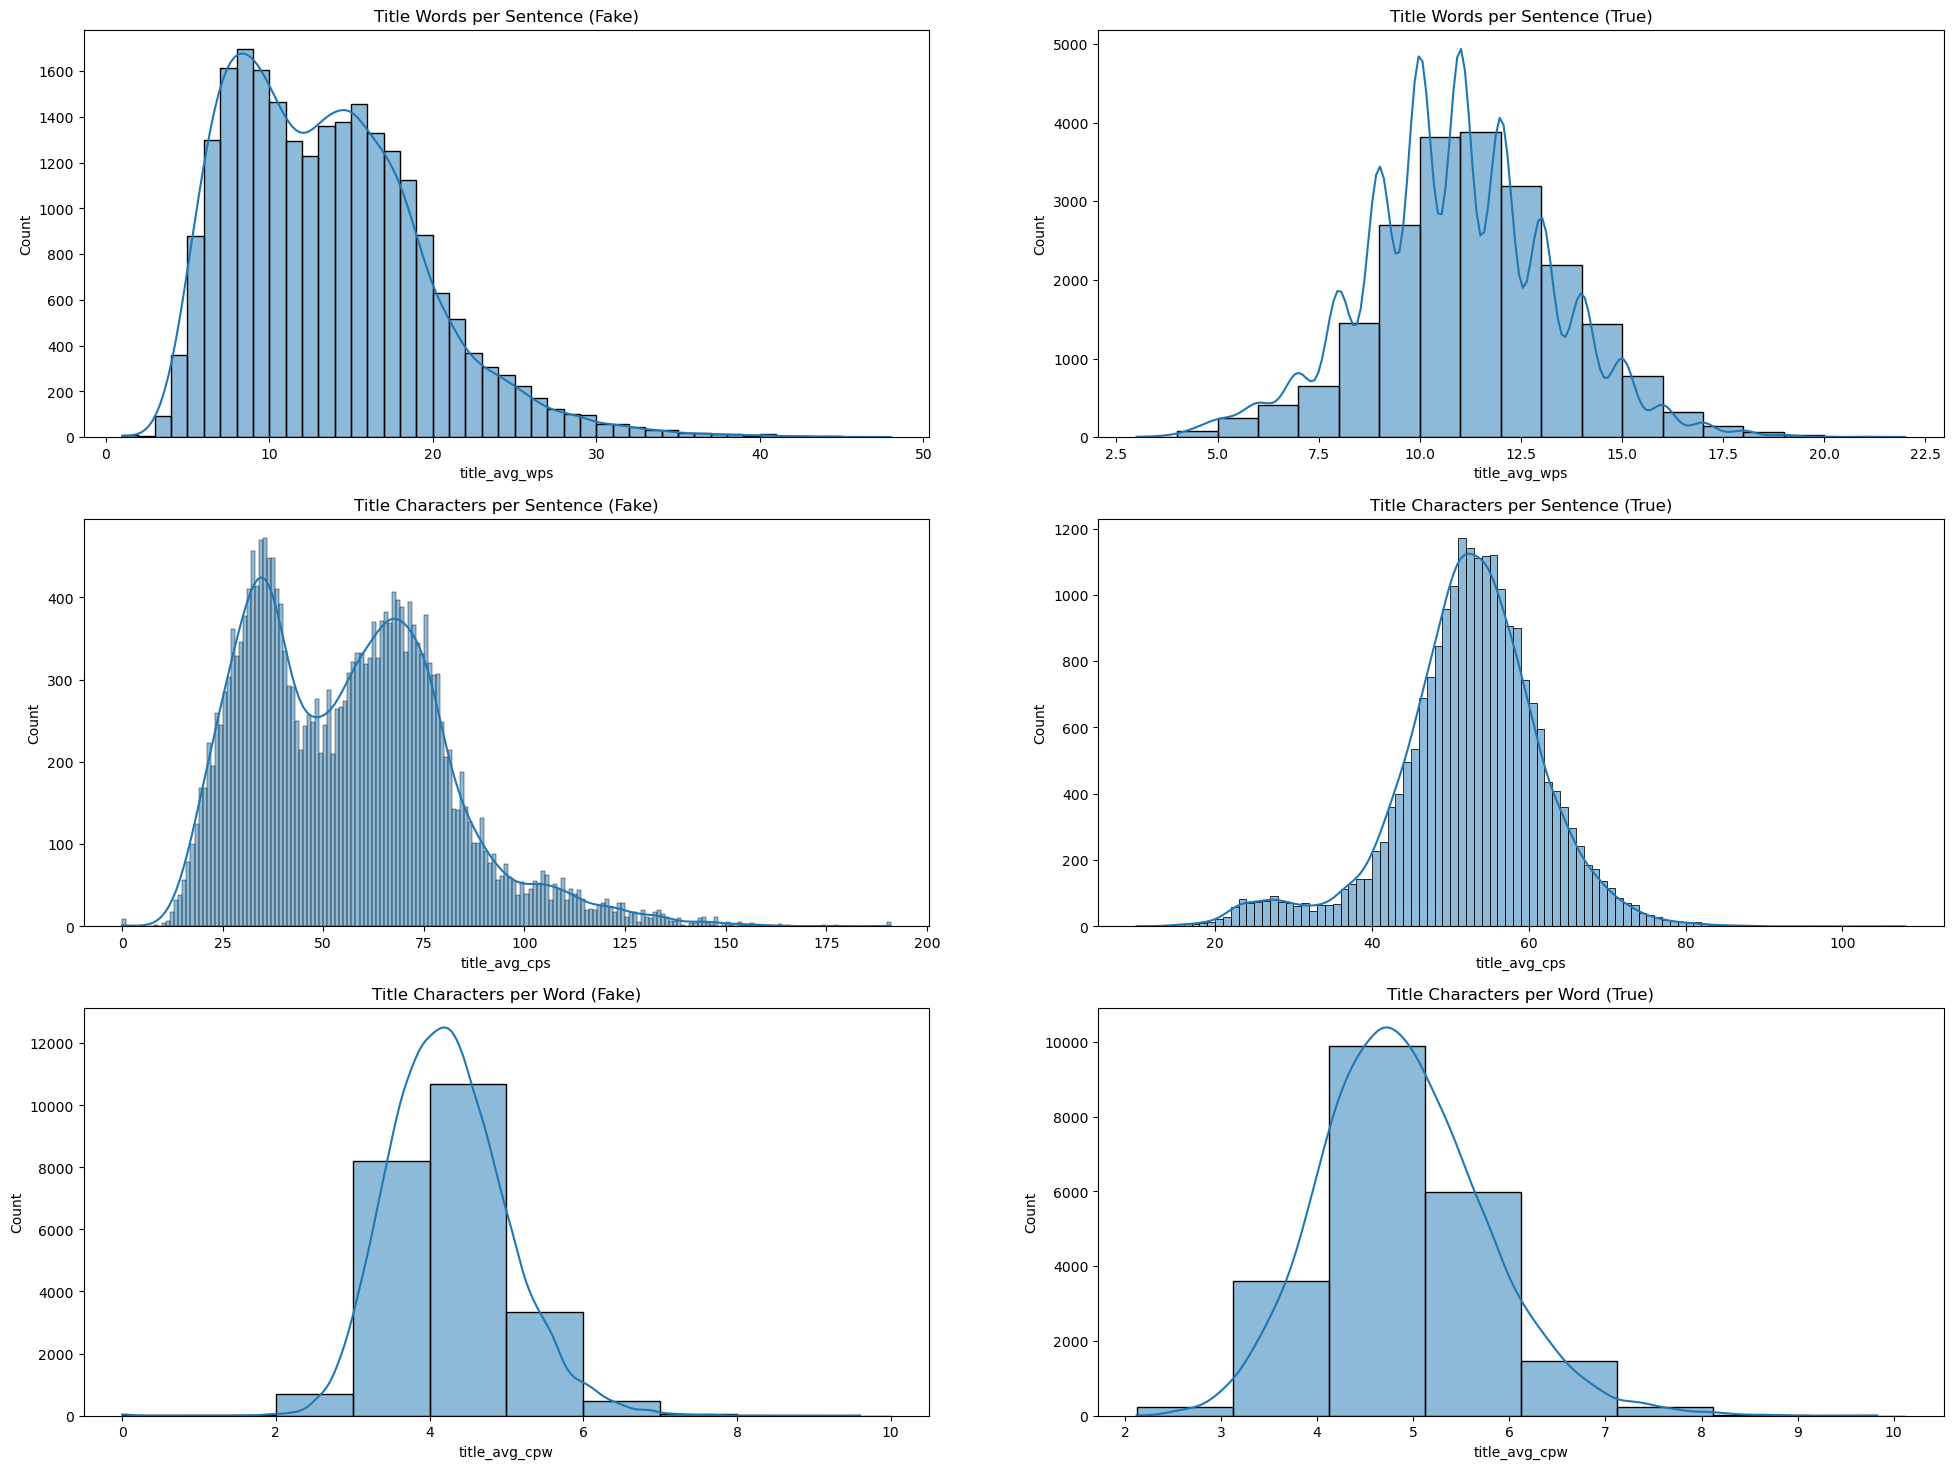

In [65]:
# Averages
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, figsize=(24,18))

# ax0 - wps
sns.histplot(data=full_df[full_df.label == 'fake'], x='title_avg_wps', binwidth=1, kde=True, ax=ax0)
ax0.set_title('Title Words per Sentence (Fake)')

# ax1 - wps
sns.histplot(data=full_df[full_df.label == 'true'], x='title_avg_wps', binwidth=1, kde=True, ax=ax1)
ax1.set_title('Title Words per Sentence (True)')

# ax2 - cps
sns.histplot(data=full_df[full_df.label == 'fake'], x='title_avg_cps', binwidth=1, kde=True, ax=ax2)
ax2.set_title('Title Characters per Sentence (Fake)')

# ax3 - cps
sns.histplot(data=full_df[full_df.label == 'true'], x='title_avg_cps', binwidth=1, kde=True, ax=ax3)
ax3.set_title('Title Characters per Sentence (True)')

# ax4 - cpw
sns.histplot(data=full_df[full_df.label == 'fake'], x='title_avg_cpw', binwidth=1, kde=True, ax=ax4)
ax4.set_title('Title Characters per Word (Fake)')

# ax5 - cpw
sns.histplot(data=full_df[full_df.label == 'true'], x='title_avg_cpw', binwidth=1, kde=True, ax=ax5)
ax5.set_title('Title Characters per Word (True)')

In [66]:
# Handling parts of speech
fake_title_all_pos_tags = list(itertools.chain.from_iterable(full_df.title_pos_tags[full_df.label == 'fake']))
true_title_all_pos_tags = list(itertools.chain.from_iterable(full_df.title_pos_tags[full_df.label == 'true']))

# Get counts
counter_fake_title_pos_tags = Counter(fake_title_all_pos_tags)
counter_true_title_pos_tags = Counter(true_title_all_pos_tags)

Text(0.5, 1.0, 'Title PoS Tags (True)')

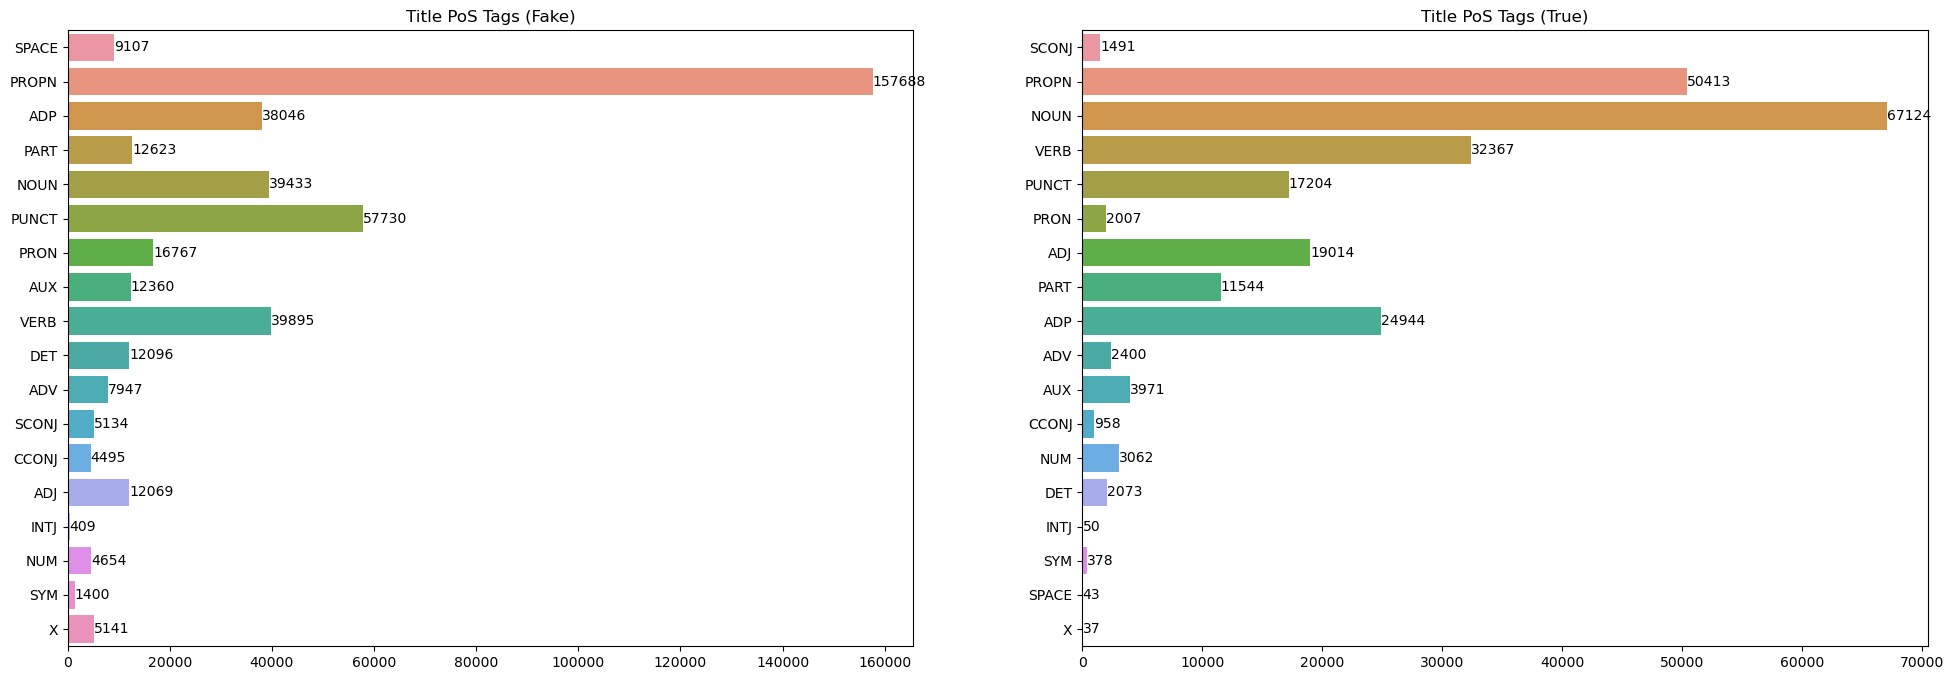

In [67]:
# Create a visualization
# Size
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(24,8))

# ax0, barplot of fake labels
fake_pos_bars = sns.barplot(x=list(counter_fake_title_pos_tags.values()), y=list(counter_fake_title_pos_tags.keys()), ax=ax0)
fake_pos_bars.bar_label(fake_pos_bars.containers[0])
fake_pos_bars.set_title('Title PoS Tags (Fake)')

# ax1, barplot of real labels
real_pos_bars = sns.barplot(x=list(counter_true_title_pos_tags.values()), y=list(counter_true_title_pos_tags.keys()), ax=ax1)
real_pos_bars.bar_label(real_pos_bars.containers[0])
real_pos_bars.set_title('Title PoS Tags (True)')

In [68]:
# Title lists of NER tags
fake_title_only_ner = [nerSplitter(i) for i in full_df.title_ner_tags[full_df.label == 'fake']]
true_title_only_ner = [nerSplitter(i) for i in full_df.title_ner_tags[full_df.label == 'true']]

# Title NER meta list
fake_title_meta_ner = list(itertools.chain.from_iterable(fake_title_only_ner))
true_title_meta_ner = list(itertools.chain.from_iterable(true_title_only_ner))

# Counter
counter_fake_title_meta_ner = Counter(fake_title_meta_ner)
counter_true_title_meta_ner = Counter(true_title_meta_ner)

Text(0.5, 1.0, 'Title NER Tags (True)')

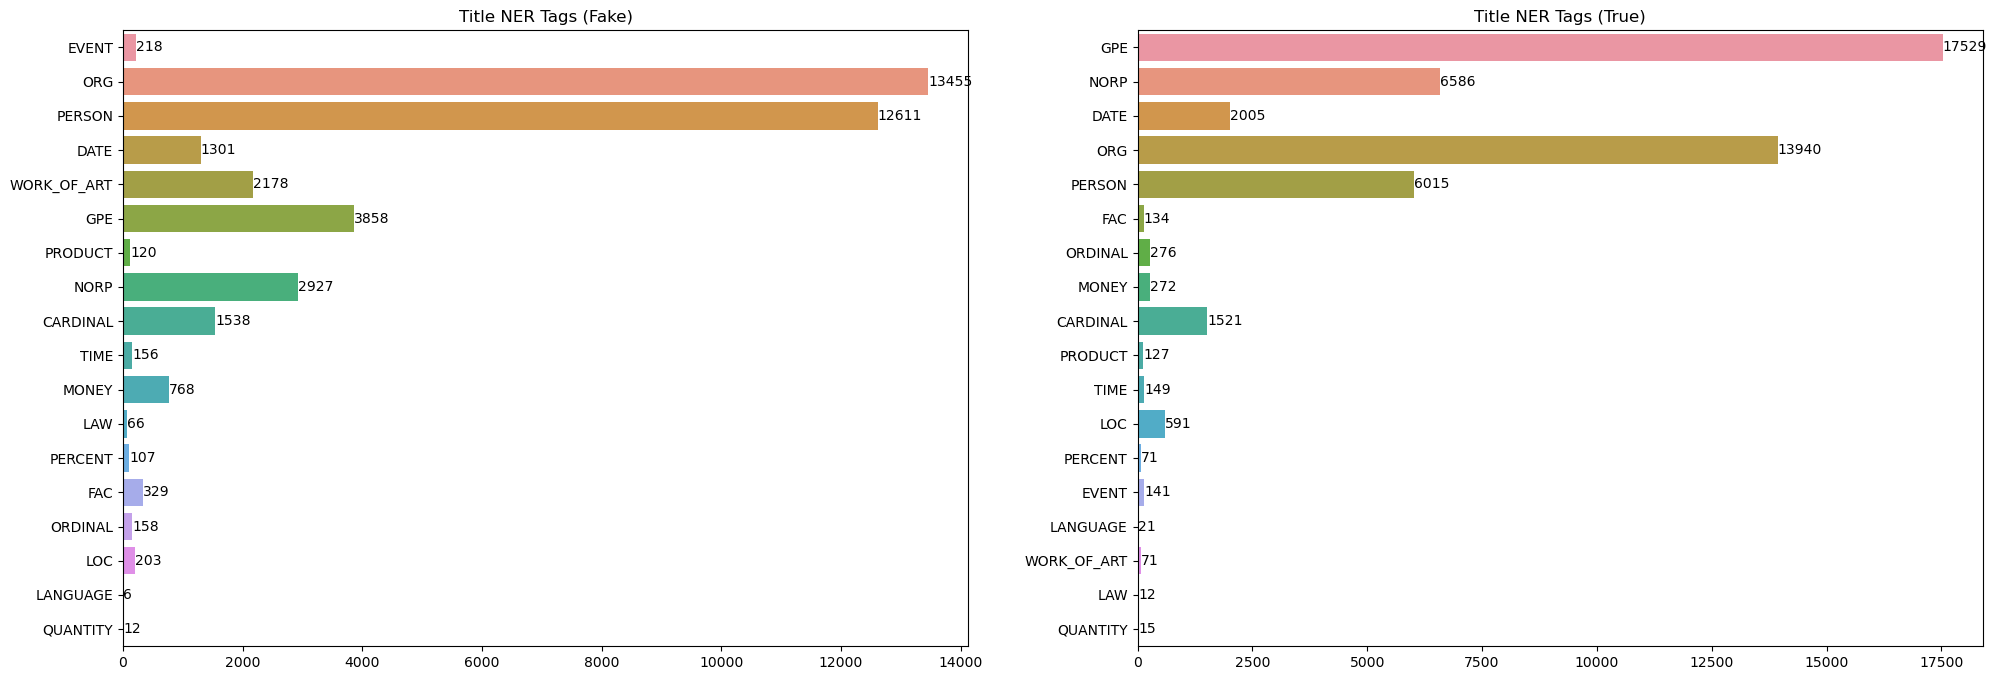

In [69]:
# Create a visualization
# Size
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(24,8))

# ax0, barplot of fake labels
fake_ner_bars = sns.barplot(x=list(counter_fake_title_meta_ner.values()), y=list(counter_fake_title_meta_ner.keys()), ax=ax0)
fake_ner_bars.bar_label(fake_ner_bars.containers[0])
fake_ner_bars.set_title('Title NER Tags (Fake)')

# ax1, barplot of real labels
real_ner_bars = sns.barplot(x=list(counter_true_title_meta_ner.values()), y=list(counter_true_title_meta_ner.keys()), ax=ax1)
real_ner_bars.bar_label(real_ner_bars.containers[0])
real_ner_bars.set_title('Title NER Tags (True)')

Text(0.5, 1.0, 'Title NER Distribution (True)')

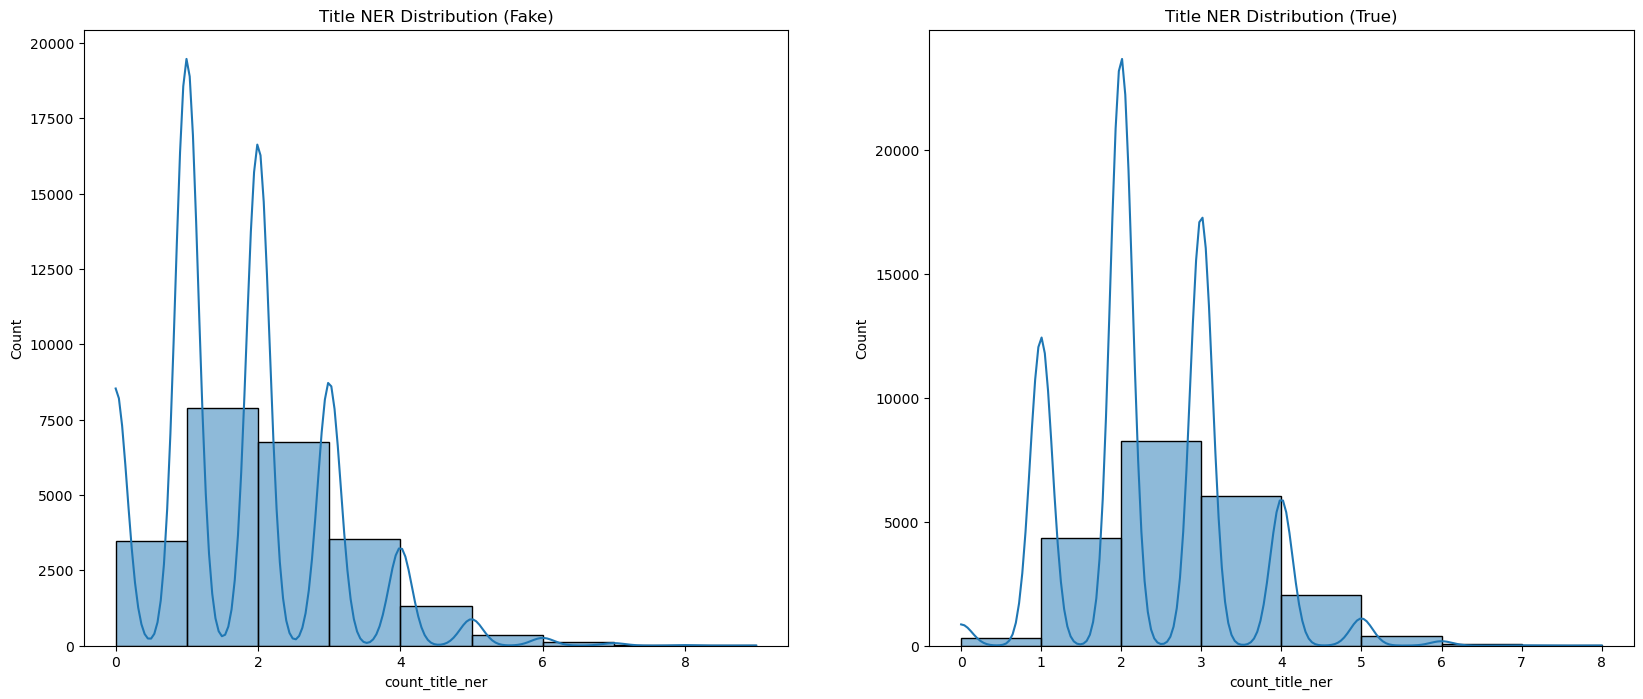

In [70]:
# Visualize - NER counts per title by label
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,8))

# ax0, fake
fake_title_ner_count = sns.histplot(data=full_df[full_df.label == 'fake'], x='count_title_ner', binwidth=1, kde=True, ax=ax0)
fake_title_ner_count.set_title('Title NER Distribution (Fake)')

# ax1, true
true_title_ner_count = sns.histplot(data=full_df[full_df.label == 'true'], x='count_title_ner', binwidth=1, kde=True, ax=ax1)
true_title_ner_count.set_title('Title NER Distribution (True)')

Text(0.5, 1.0, 'Title Stopwords Distribution (True)')

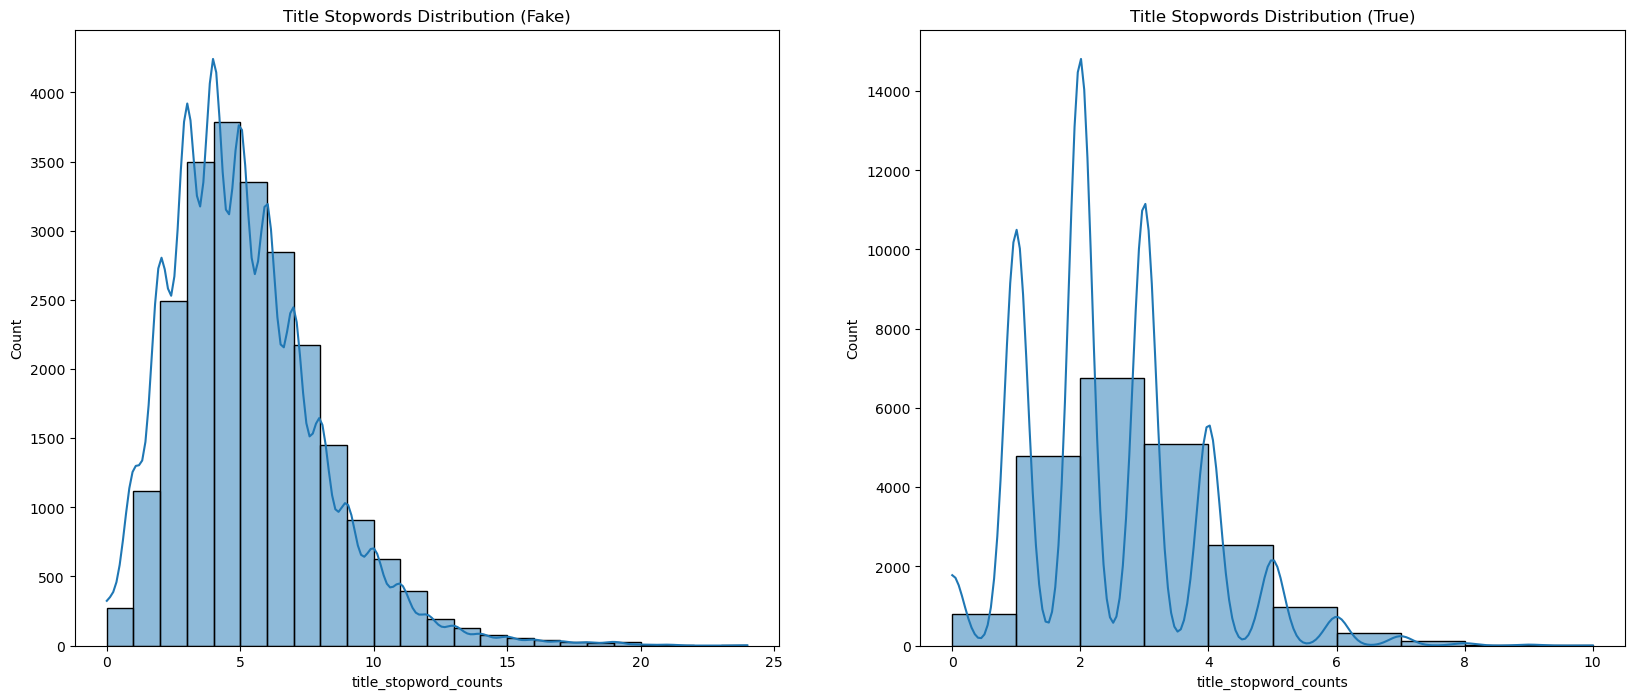

In [71]:
# Visualize stopwords distributions
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,8))

# ax0, fake
fake_title_stopwords = sns.histplot(data=full_df[full_df.label == 'fake'], x='title_stopword_counts', binwidth=1, kde=True, ax=ax0)
fake_title_stopwords.set_title('Title Stopwords Distribution (Fake)')

# ax1, true
true_title_stopwords = sns.histplot(data=full_df[full_df.label == 'true'], x='title_stopword_counts', binwidth=1, kde=True, ax=ax1)
true_title_stopwords.set_title('Title Stopwords Distribution (True)')

### Texts

In [72]:
# Dictionary
true_texts_stats_dict = {'Sentence Counts': {'Minimum': min(full_df.texts_sentence_counts[full_df.label == 'true']), 
                                             'Maximum': max(full_df.texts_sentence_counts[full_df.label == 'true']),
                                             'Mean': np.mean(full_df.texts_sentence_counts[full_df.label == 'true']),
                                             'Median':statistics.median(full_df.texts_sentence_counts[full_df.label == 'true']),
                                             'Mode': Counter(full_df.texts_sentence_counts[full_df.label == 'true']).most_common(1)[0][0],
                                             'Standard Deviation': np.std(full_df.texts_sentence_counts[full_df.label == 'true'])},
                    'Token Counts': {'Minimum': min(full_df.texts_token_counts[full_df.label == 'true']), 
                                     'Maximum': max(full_df.texts_token_counts[full_df.label == 'true']),
                                     'Mean': np.mean(full_df.texts_token_counts[full_df.label == 'true']),
                                     'Median':statistics.median(full_df.texts_token_counts[full_df.label == 'true']),
                                     'Mode': Counter(full_df.texts_token_counts[full_df.label == 'true']).most_common(1)[0][0],
                                     'Standard Deviation': np.std(full_df.texts_token_counts[full_df.label == 'true'])},
                    'Character Counts': {'Minimum': min(full_df.texts_char_counts[full_df.label == 'true']), 
                                         'Maximum': max(full_df.texts_char_counts[full_df.label == 'true']),
                                         'Mean': np.mean(full_df.texts_char_counts[full_df.label == 'true']),
                                         'Median':statistics.median(full_df.texts_char_counts[full_df.label == 'true']),
                                         'Mode': Counter(full_df.texts_char_counts[full_df.label == 'true']).most_common(1)[0][0],
                                         'Standard Deviation': np.std(full_df.texts_char_counts[full_df.label == 'true'])}}

In [73]:
# Dictionary
fake_texts_stats_dict = {'Sentence Counts': {'Minimum': min(full_df.texts_sentence_counts[full_df.label == 'fake']), 
                                             'Maximum': max(full_df.texts_sentence_counts[full_df.label == 'fake']),
                                             'Mean': np.mean(full_df.texts_sentence_counts[full_df.label == 'fake']),
                                             'Median':statistics.median(full_df.texts_sentence_counts[full_df.label == 'fake']),
                                             'Mode': Counter(full_df.texts_sentence_counts[full_df.label == 'fake']).most_common(1)[0][0],
                                             'Standard Deviation': np.std(full_df.texts_sentence_counts[full_df.label == 'fake'])},
                    'Token Counts': {'Minimum': min(full_df.texts_token_counts[full_df.label == 'fake']), 
                                     'Maximum': max(full_df.texts_token_counts[full_df.label == 'fake']),
                                     'Mean': np.mean(full_df.texts_token_counts[full_df.label == 'fake']),
                                     'Median':statistics.median(full_df.texts_token_counts[full_df.label == 'fake']),
                                     'Mode': Counter(full_df.texts_token_counts[full_df.label == 'fake']).most_common(1)[0][0],
                                     'Standard Deviation': np.std(full_df.texts_token_counts[full_df.label == 'fake'])},
                    'Character Counts': {'Minimum': min(full_df.texts_char_counts[full_df.label == 'fake']), 
                                         'Maximum': max(full_df.texts_char_counts[full_df.label == 'fake']),
                                         'Mean': np.mean(full_df.texts_char_counts[full_df.label == 'fake']),
                                         'Median':statistics.median(full_df.texts_char_counts[full_df.label == 'fake']),
                                         'Mode': Counter(full_df.texts_char_counts[full_df.label == 'fake']).most_common(1)[0][0],
                                         'Standard Deviation': np.std(full_df.texts_char_counts[full_df.label == 'fake'])}}

In [74]:
# Create a table
true_false_texts_stats_table = tabulate([['Statistics', 'Sentences (Real)', 'Sentences (Fake)', 'Tokens (Real)', 'Tokens (Fake)', 'Characters (Real)', 'Characters (Fake)'],
                              ['Minimum', true_texts_stats_dict['Sentence Counts']['Minimum'], fake_texts_stats_dict['Sentence Counts']['Minimum'], true_texts_stats_dict['Token Counts']['Minimum'], fake_texts_stats_dict['Token Counts']['Minimum'], true_texts_stats_dict['Character Counts']['Minimum'], fake_texts_stats_dict['Character Counts']['Minimum']],
                              ['Maximum', true_texts_stats_dict['Sentence Counts']['Maximum'], fake_texts_stats_dict['Sentence Counts']['Maximum'], true_texts_stats_dict['Token Counts']['Maximum'], fake_texts_stats_dict['Token Counts']['Maximum'], true_texts_stats_dict['Character Counts']['Maximum'], fake_texts_stats_dict['Character Counts']['Maximum']], 
                              ['Mean', true_texts_stats_dict['Sentence Counts']['Mean'], fake_texts_stats_dict['Sentence Counts']['Mean'], true_texts_stats_dict['Token Counts']['Mean'], fake_texts_stats_dict['Token Counts']['Mean'], true_texts_stats_dict['Character Counts']['Mean'], fake_texts_stats_dict['Character Counts']['Mean']], 
                              ['Median', true_texts_stats_dict['Sentence Counts']['Median'], fake_texts_stats_dict['Sentence Counts']['Median'], true_texts_stats_dict['Token Counts']['Median'], fake_texts_stats_dict['Token Counts']['Median'], true_texts_stats_dict['Character Counts']['Median'], fake_texts_stats_dict['Character Counts']['Median']], 
                              ['Mode', true_texts_stats_dict['Sentence Counts']['Mode'], fake_texts_stats_dict['Sentence Counts']['Mode'], true_texts_stats_dict['Token Counts']['Mode'], fake_texts_stats_dict['Token Counts']['Mode'], true_texts_stats_dict['Character Counts']['Mode'], fake_texts_stats_dict['Character Counts']['Mode']], 
                              ['Std. Deviation', true_texts_stats_dict['Sentence Counts']['Standard Deviation'], fake_texts_stats_dict['Sentence Counts']['Standard Deviation'], true_texts_stats_dict['Token Counts']['Standard Deviation'], fake_texts_stats_dict['Token Counts']['Standard Deviation'], true_texts_stats_dict['Character Counts']['Standard Deviation'], fake_texts_stats_dict['Character Counts']['Standard Deviation']]],
                            headers='firstrow',
                            tablefmt='prettytable')

# Show
print(true_false_texts_stats_table)

Statistics        Sentences (Real)    Sentences (Fake)    Tokens (Real)    Tokens (Fake)    Characters (Real)    Characters (Fake)
--------------  ------------------  ------------------  ---------------  ---------------  -------------------  -------------------
Minimum                     1                   1                 0                0                     0                    0
Maximum                   372                 368              5920             9304                 23566                41864
Mean                       16.0286             20.4873          440.98           484.068              1915.38              2010.05
Median                     14                  18               409              416                  1786                 1711
Mode                        3                   1                88                0                   429                    0
Std. Deviation             12.2405             18.2728          315.264          468.67        

Text(0.5, 1.0, 'Texts Character Counts (True)')

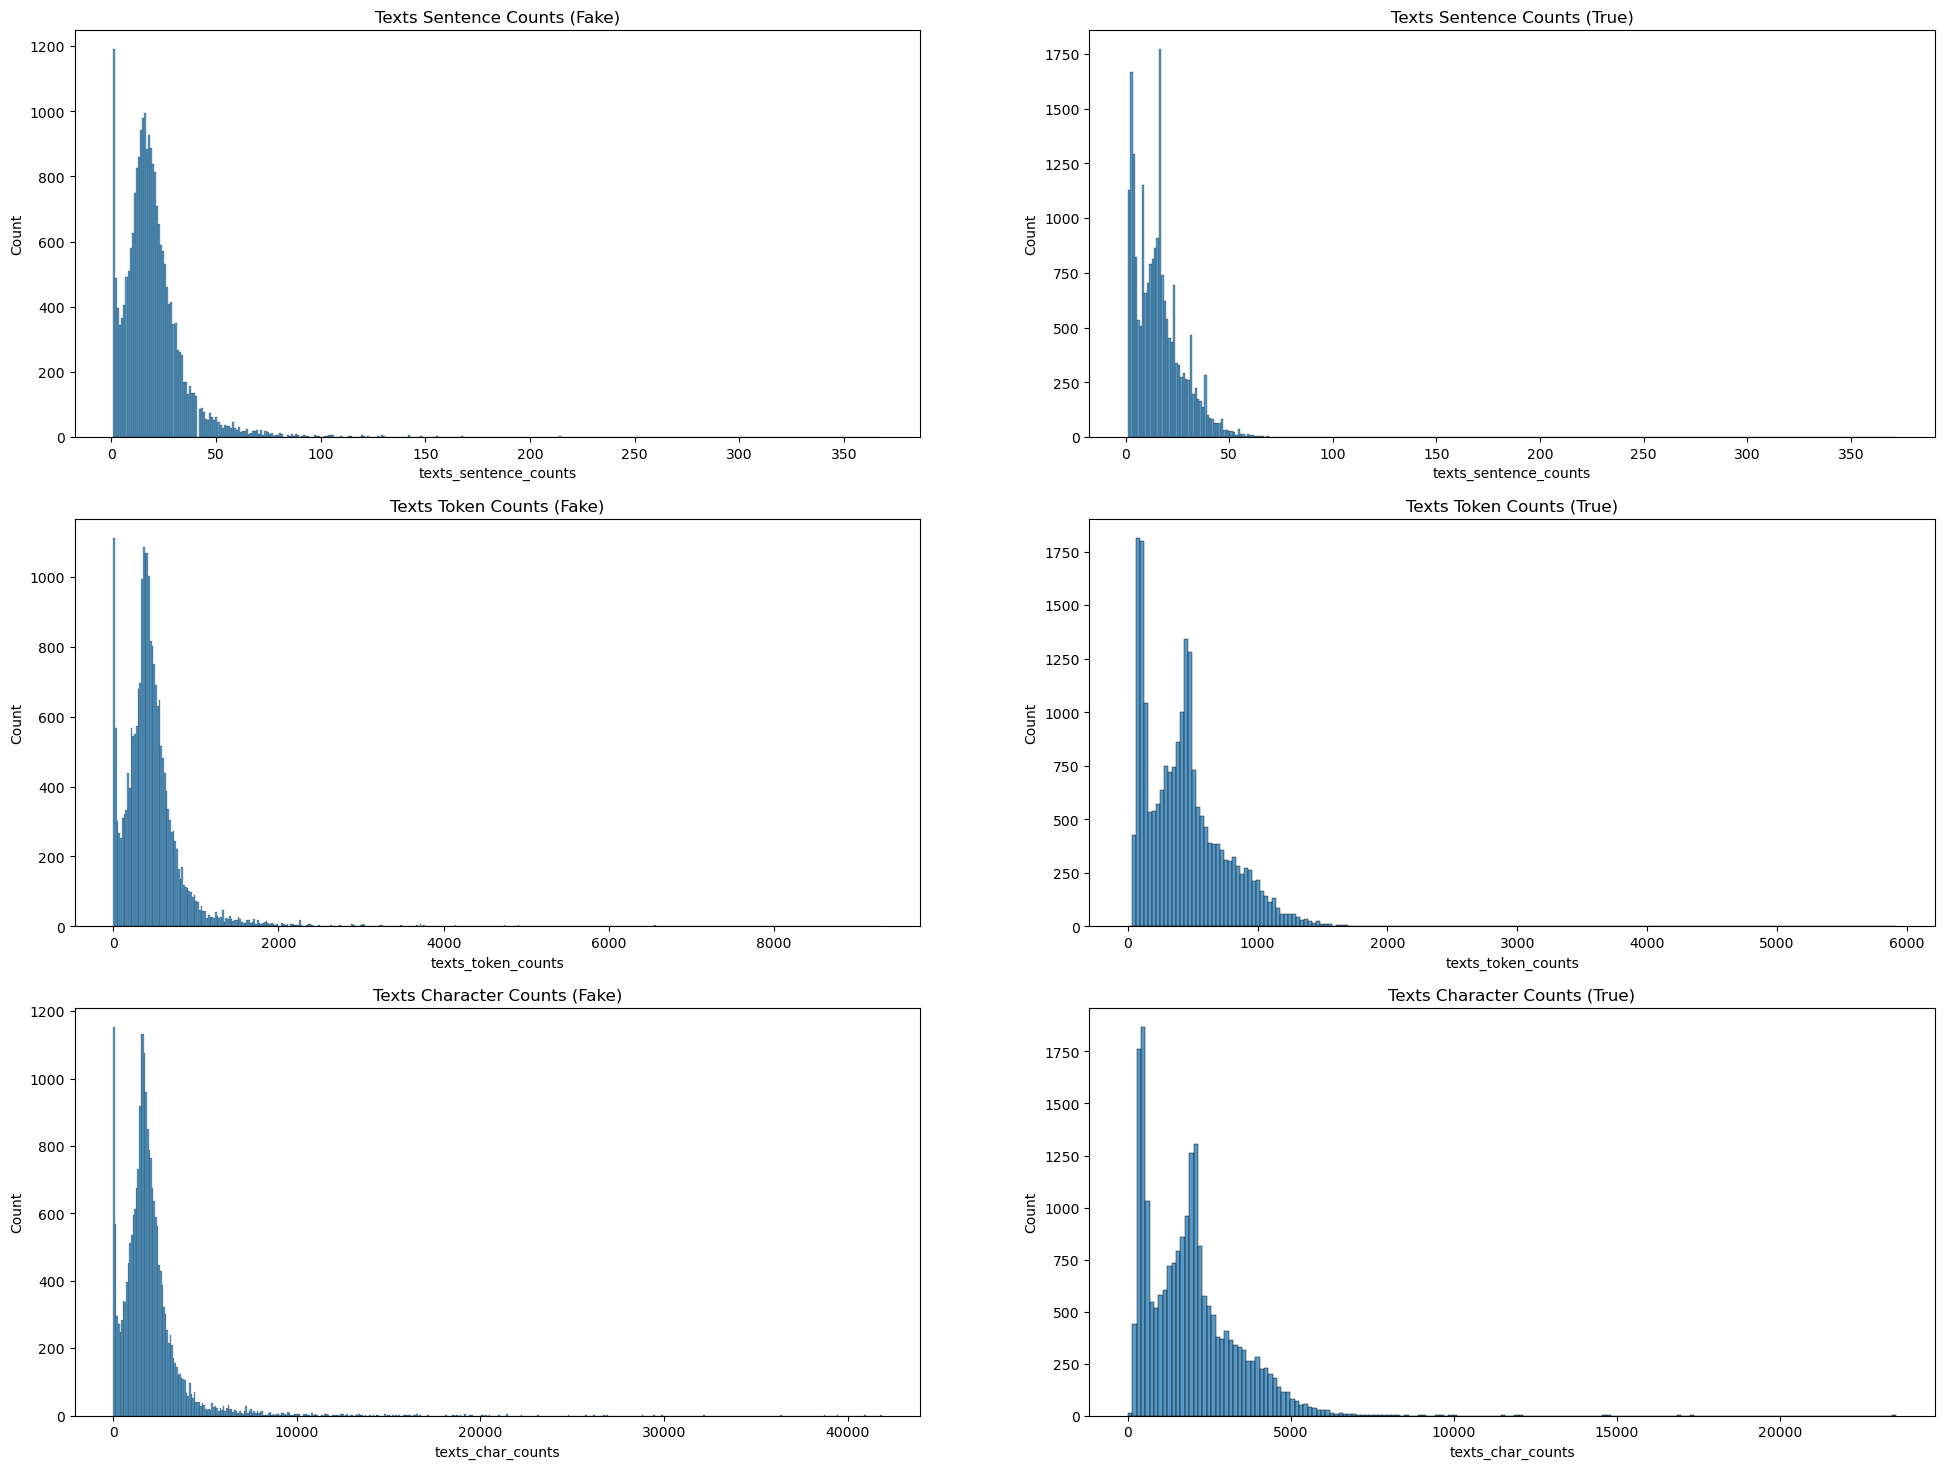

In [75]:
# Sentence, Token, Character counts
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, figsize=(24,18))

# ax0 - Sentence counts, fake
sns.histplot(data=full_df[full_df.label == 'fake'], x='texts_sentence_counts', ax=ax0)
ax0.set_title('Texts Sentence Counts (Fake)')

# ax1 - Sentence counts, true
sns.histplot(data=full_df[full_df.label == 'true'], x='texts_sentence_counts', ax=ax1)
ax1.set_title('Texts Sentence Counts (True)')

# ax2 - Token counts, fake
sns.histplot(data=full_df[full_df.label == 'fake'], x='texts_token_counts', ax=ax2)
ax2.set_title('Texts Token Counts (Fake)')

# ax3 - Token counts, true
sns.histplot(data=full_df[full_df.label == 'true'], x='texts_token_counts', ax=ax3)
ax3.set_title('Texts Token Counts (True)')

# ax4 - Character counts, fake
sns.histplot(data=full_df[full_df.label == 'fake'], x='texts_char_counts', ax=ax4)
ax4.set_title('Texts Character Counts (Fake)')

# ax5 - Character counts, fake
sns.histplot(data=full_df[full_df.label == 'true'], x='texts_char_counts', ax=ax5)
ax5.set_title('Texts Character Counts (True)')

In [76]:
# Create a table
true_false_texts_avgs_table = tabulate([['Measure', 'Minimum (Fake)', 'Minimum (True)', 'Maximum (Fake)', 'Maximum (True)'],
                                        ['Avg. Words per Sentence', min(full_df['text_avg_wps'][full_df.label == 'fake']), min(full_df['text_avg_wps'][full_df.label == 'true']), max(full_df['text_avg_wps'][full_df.label == 'fake']), max(full_df['text_avg_wps'][full_df.label == 'true']),],
                                        ['Avg. Characters per Sentence', min(full_df['text_avg_cps'][full_df.label == 'fake']), min(full_df['text_avg_cps'][full_df.label == 'true']), max(full_df['text_avg_cps'][full_df.label == 'fake']), max(full_df['text_avg_cps'][full_df.label == 'true'])],
                                        ['Avg. Characters per Words', min(full_df['text_avg_cpw'][full_df.label == 'fake']), min(full_df['text_avg_cpw'][full_df.label == 'true']), max(full_df['text_avg_cpw'][full_df.label == 'fake']), max(full_df['text_avg_cpw'][full_df.label == 'true'])]],
                                       headers='firstrow',
                                       tablefmt='prettytable')

# Show
print(true_false_texts_avgs_table)

Measure                         Minimum (Fake)    Minimum (True)    Maximum (Fake)    Maximum (True)
----------------------------  ----------------  ----------------  ----------------  ----------------
Avg. Words per Sentence                      0              0                  135             150.4
Avg. Characters per Sentence                 0              0                  603             755.8
Avg. Characters per Words                    0              2.36                 9               5.5


Text(0.5, 1.0, 'Text Characters per Word (True)')

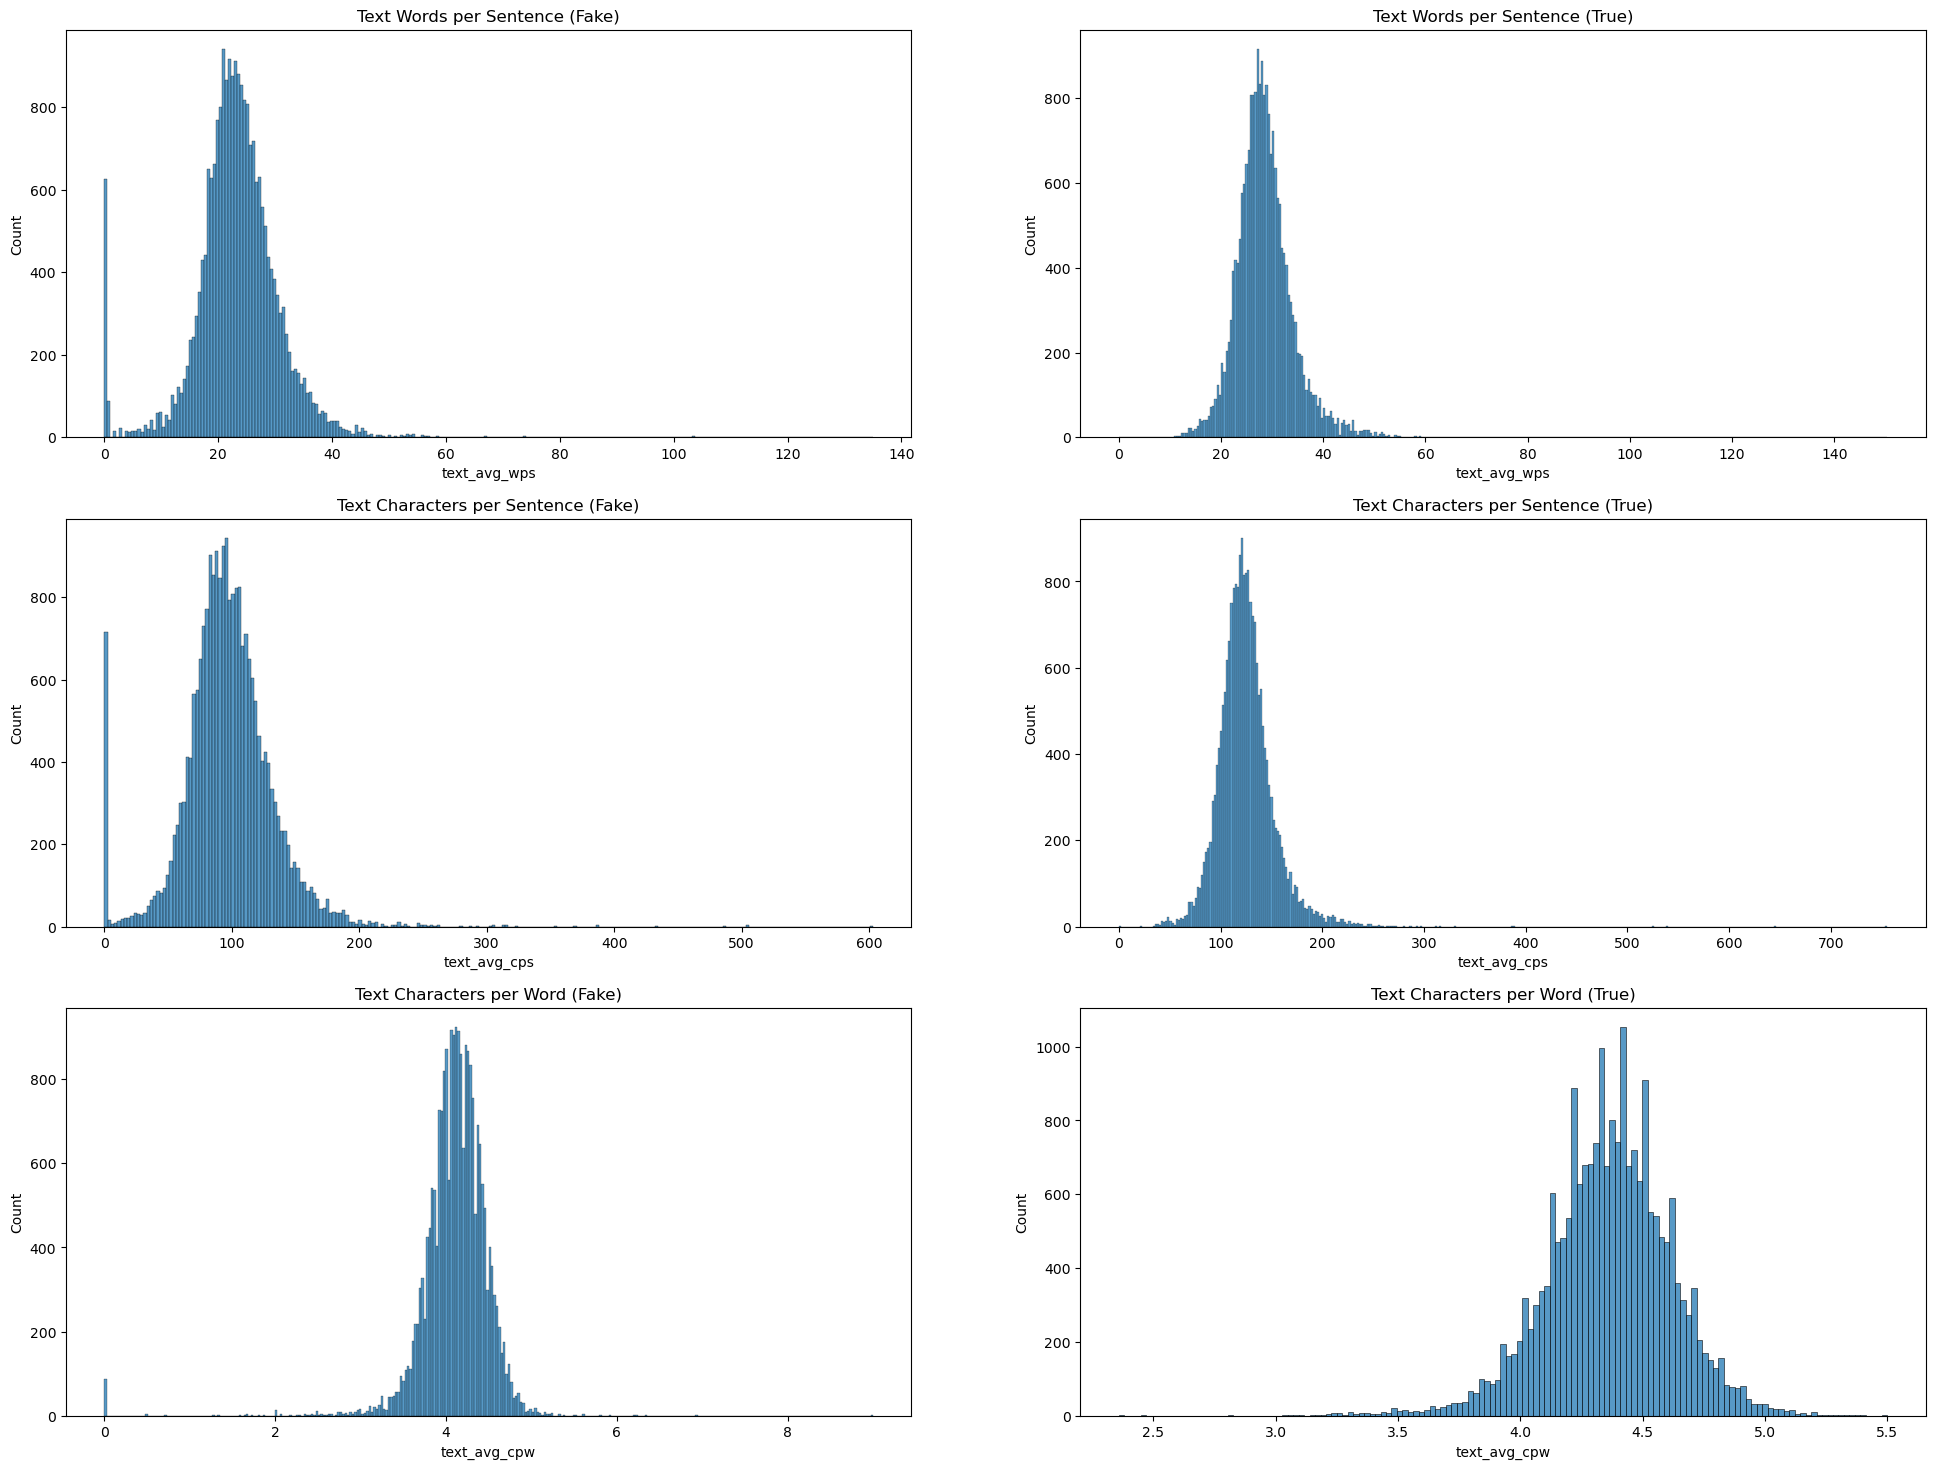

In [77]:
# Averages
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, figsize=(24,18))

# ax0 - wps
sns.histplot(data=full_df[full_df.label == 'fake'], x='text_avg_wps', ax=ax0)
ax0.set_title('Text Words per Sentence (Fake)')

# ax1 - wps
sns.histplot(data=full_df[full_df.label == 'true'], x='text_avg_wps', ax=ax1)
ax1.set_title('Text Words per Sentence (True)')

# ax2 - cps
sns.histplot(data=full_df[full_df.label == 'fake'], x='text_avg_cps', ax=ax2)
ax2.set_title('Text Characters per Sentence (Fake)')

# ax3 - cps
sns.histplot(data=full_df[full_df.label == 'true'], x='text_avg_cps', ax=ax3)
ax3.set_title('Text Characters per Sentence (True)')

# ax4 - cpw
sns.histplot(data=full_df[full_df.label == 'fake'], x='text_avg_cpw', ax=ax4)
ax4.set_title('Text Characters per Word (Fake)')

# ax5 - cpw
sns.histplot(data=full_df[full_df.label == 'true'], x='text_avg_cpw', ax=ax5)
ax5.set_title('Text Characters per Word (True)')

In [78]:
# Handling parts of speech
fake_text_all_pos_tags = list(itertools.chain.from_iterable(full_df.texts_pos_tags[full_df.label == 'fake']))
true_text_all_pos_tags = list(itertools.chain.from_iterable(full_df.texts_pos_tags[full_df.label == 'true']))

# Get counts
counter_fake_text_pos_tags = Counter(fake_text_all_pos_tags)
counter_true_text_pos_tags = Counter(true_text_all_pos_tags)

Text(0.5, 1.0, 'Text PoS Tags (True)')

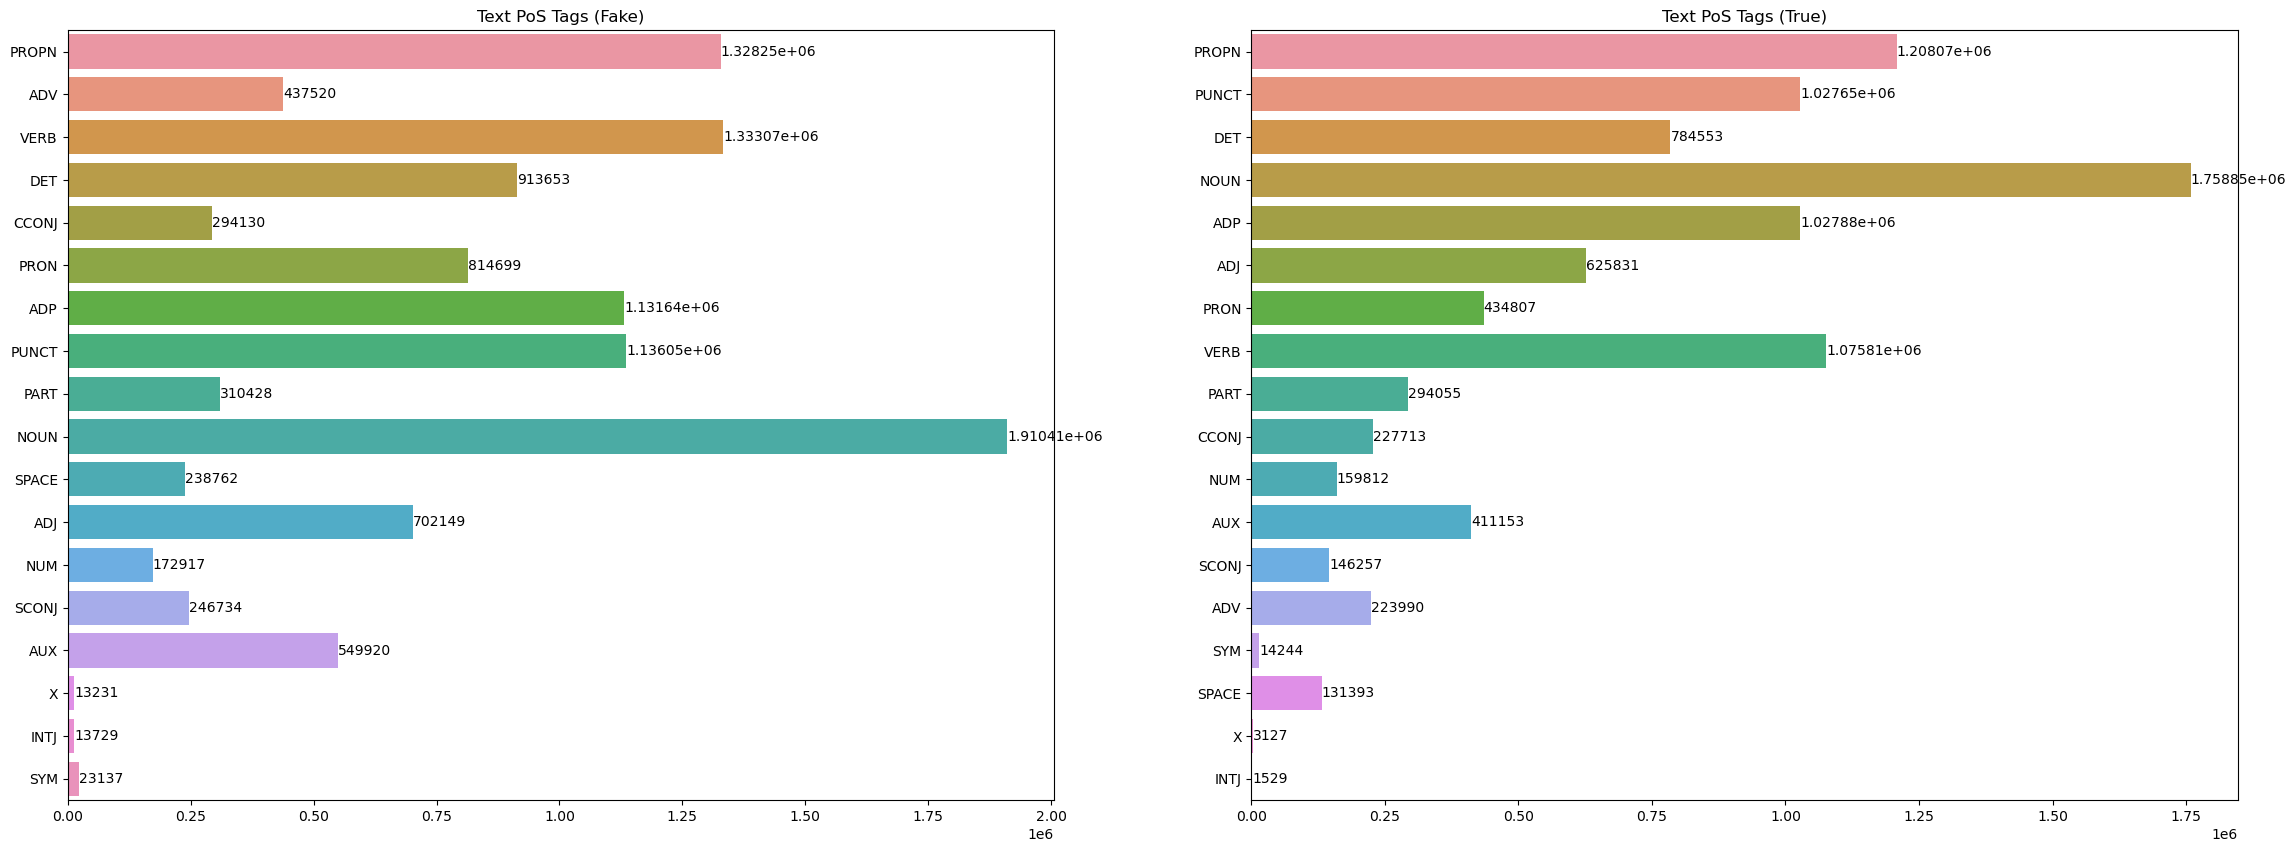

In [79]:
# Create a visualization
# Size
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(28,10))

# ax0, barplot of fake labels
fake_pos_text_bars = sns.barplot(x=list(counter_fake_text_pos_tags.values()), y=list(counter_fake_text_pos_tags.keys()), ax=ax0)
fake_pos_text_bars.bar_label(fake_pos_text_bars.containers[0])
fake_pos_text_bars.set_title('Text PoS Tags (Fake)')

# ax1, barplot of real labels
real_pos_text_bars = sns.barplot(x=list(counter_true_text_pos_tags.values()), y=list(counter_true_text_pos_tags.keys()), ax=ax1)
real_pos_text_bars.bar_label(real_pos_text_bars.containers[0])
real_pos_text_bars.set_title('Text PoS Tags (True)')

In [80]:
# Text lists of NER tags
fake_text_only_ner = [nerSplitter(i) for i in full_df.texts_ner_tags[full_df.label == 'fake']]
true_text_only_ner = [nerSplitter(i) for i in full_df.texts_ner_tags[full_df.label == 'true']]

# Title NER meta list
fake_text_meta_ner = list(itertools.chain.from_iterable(fake_text_only_ner))
true_text_meta_ner = list(itertools.chain.from_iterable(true_text_only_ner))

# Counter
counter_fake_text_meta_ner = Counter(fake_text_meta_ner)
counter_true_text_meta_ner = Counter(true_text_meta_ner)

Text(0.5, 1.0, 'Text NER Tags (True)')

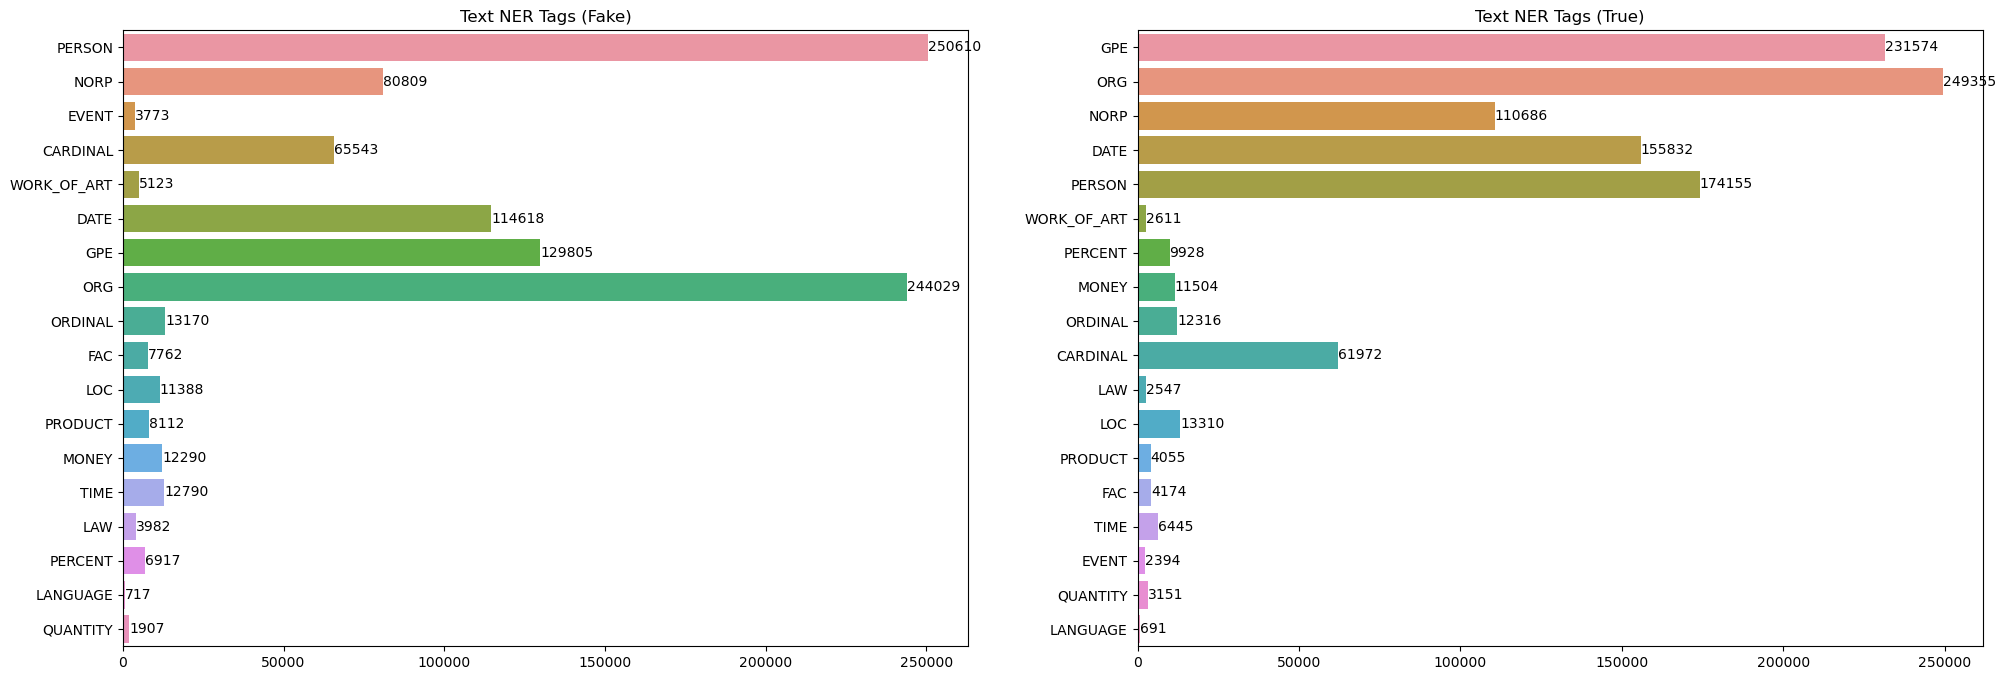

In [81]:
# Create a visualization
# Size
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(24,8))

# ax0, barplot of fake labels
fake_text_ner_bars = sns.barplot(x=list(counter_fake_text_meta_ner.values()), y=list(counter_fake_text_meta_ner.keys()), ax=ax0)
fake_text_ner_bars.bar_label(fake_text_ner_bars.containers[0])
fake_text_ner_bars.set_title('Text NER Tags (Fake)')

# ax1, barplot of real labels
real_text_ner_bars = sns.barplot(x=list(counter_true_text_meta_ner.values()), y=list(counter_true_text_meta_ner.keys()), ax=ax1)
real_text_ner_bars.bar_label(real_text_ner_bars.containers[0])
real_text_ner_bars.set_title('Text NER Tags (True)')

Text(0.5, 1.0, 'Text NER Distribution (True)')

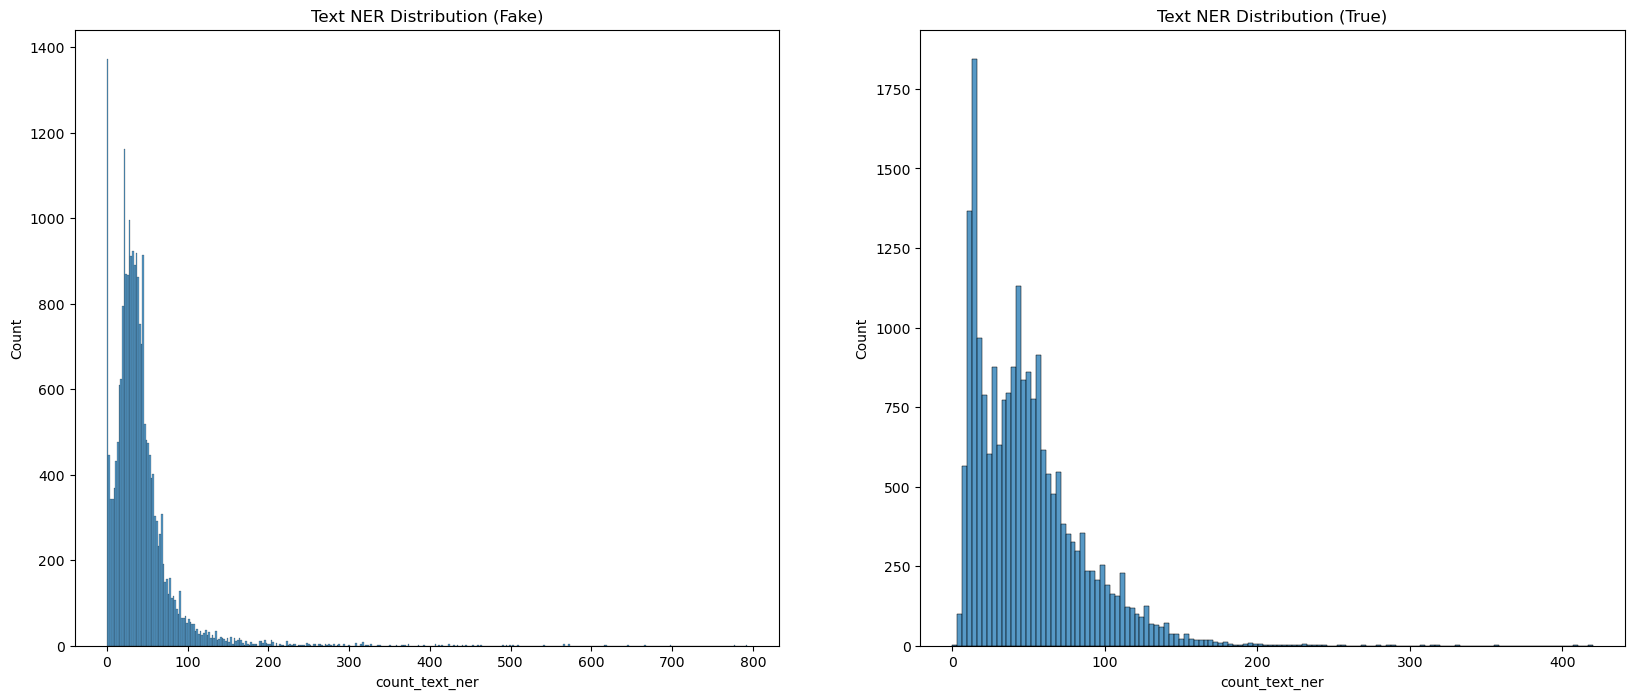

In [82]:
# Visualize - NER counts per title by label
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,8))

# ax0, fake
fake_text_ner_count = sns.histplot(data=full_df[full_df.label == 'fake'], x='count_text_ner', ax=ax0)
fake_text_ner_count.set_title('Text NER Distribution (Fake)')

# ax1, true
true_text_ner_count = sns.histplot(data=full_df[full_df.label == 'true'], x='count_text_ner', ax=ax1)
true_text_ner_count.set_title('Text NER Distribution (True)')

Text(0.5, 1.0, 'Text Stopwords Distribution (True)')

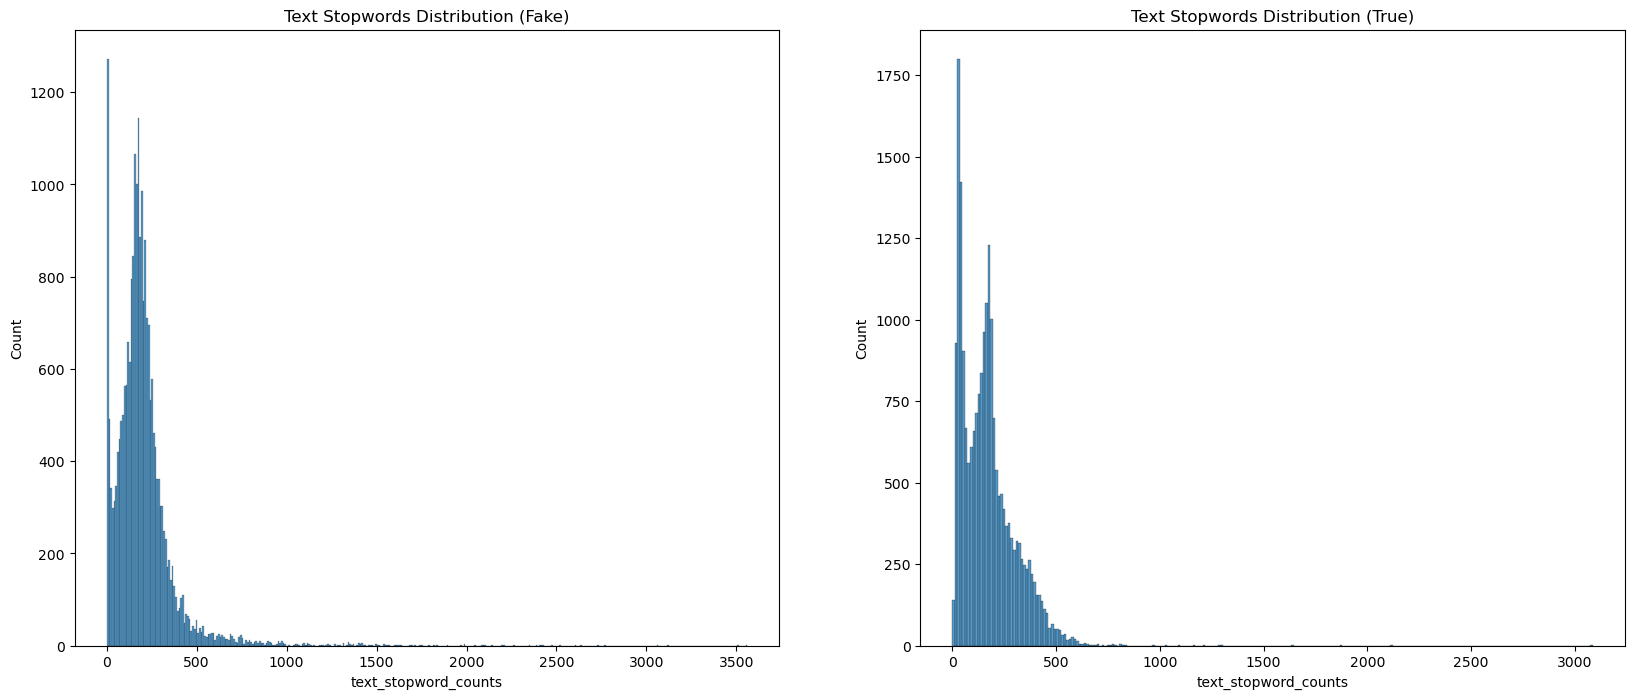

In [83]:
# Visualize stopwords distributions
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,8))

# ax0, fake
fake_text_stopwords = sns.histplot(data=full_df[full_df.label == 'fake'], x='text_stopword_counts', ax=ax0)
fake_text_stopwords.set_title('Text Stopwords Distribution (Fake)')

# ax1, true
true_text_stopwords = sns.histplot(data=full_df[full_df.label == 'true'], x='text_stopword_counts', ax=ax1)
true_text_stopwords.set_title('Text Stopwords Distribution (True)')

In [84]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  44898 non-null  object 
 1   text                   44898 non-null  object 
 2   subject                44898 non-null  object 
 3   date                   44898 non-null  object 
 4   label                  44898 non-null  object 
 5   title_tokens           44898 non-null  object 
 6   title_sentences        44898 non-null  object 
 7   title_pos_tags         44898 non-null  object 
 8   title_ner_tags         44898 non-null  object 
 9   title_lemmas           44898 non-null  object 
 10  title_token_counts     44898 non-null  int64  
 11  title_char_counts      44898 non-null  int64  
 12  title_sentence_counts  44898 non-null  int64  
 13  texts_tokens           44898 non-null  object 
 14  texts_sentences        44898 non-null  object 
 15  te

Text(0.5, 1.0, 'Subjects for Real Texts')

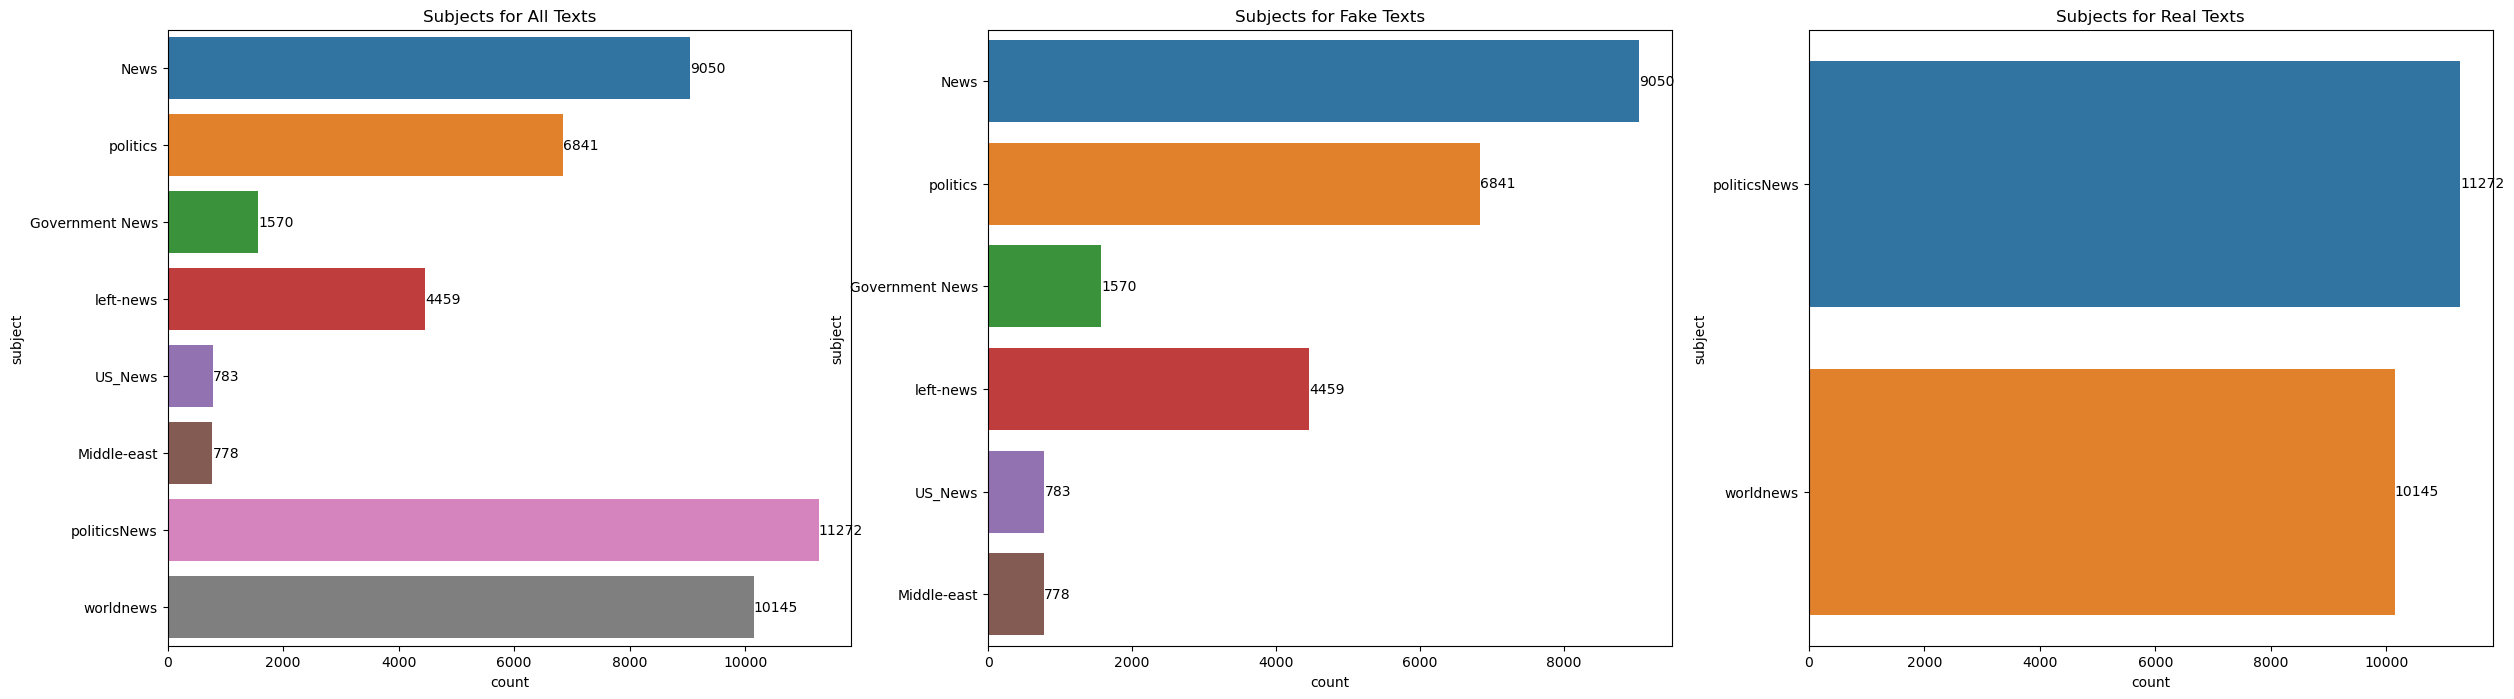

In [85]:
# Subject visualization
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(30, 8))

# ax0
full_subjects = sns.countplot(data=full_df, y='subject', ax=ax0)
full_subjects.bar_label(full_subjects.containers[0])
full_subjects.set_title('Subjects for All Texts')

# ax1
fake_subjects = sns.countplot(data=full_df[full_df.label =='fake'], y='subject', ax=ax1)
fake_subjects.bar_label(fake_subjects.containers[0])
fake_subjects.set_title('Subjects for Fake Texts')


# ax2
true_subjects = sns.countplot(data=full_df[full_df.label == 'true'], y='subject', ax=ax2)
true_subjects.bar_label(true_subjects.containers[0])
true_subjects.set_title('Subjects for Real Texts')


The definitions of some of these categories is unclear, so Subjects will be excluded during a formal analysis.

## Feature Selection

Before building a model for prediction, the variables for the prediction analysis need to be selected.

- Target variable: label
- Potential predictor variables: Any count or count-based variables.

It's worth noting that the predictor variables are all count variables, which may follow a Poisson distribution (can't be less than 0, counts are independent among all elements). For some of the algorithms, an Anscombe correction might be necessary.

In [86]:
# Load the pickle file
count_df = pd.read_pickle('/kaggle/input/count-features/count_features_df.pkl')

# Check
count_df.head(3)

,title_token_counts,title_char_counts,title_sentence_counts,texts_token_counts,texts_char_counts,texts_sentence_counts,title_ner_counts,texts_ner_counts,title_avg_wps,title_avg_cps,title_avg_cpw,title_stopword_counts,text_avg_wps,text_avg_cps,text_avg_cpw,text_stopword_counts,label
0,14,64,2,600,2071,31,1,78,7.0,32.0,4.57,4,19.35,66.81,3.45,203,fake
1,8,61,1,348,1544,15,1,44,8.0,61.0,7.62,0,23.20,102.93,4.44,135,fake
2,17,73,1,692,2521,33,1,67,17.0,73.0,4.29,6,20.97,76.39,3.64,248,fake


<Axes: >

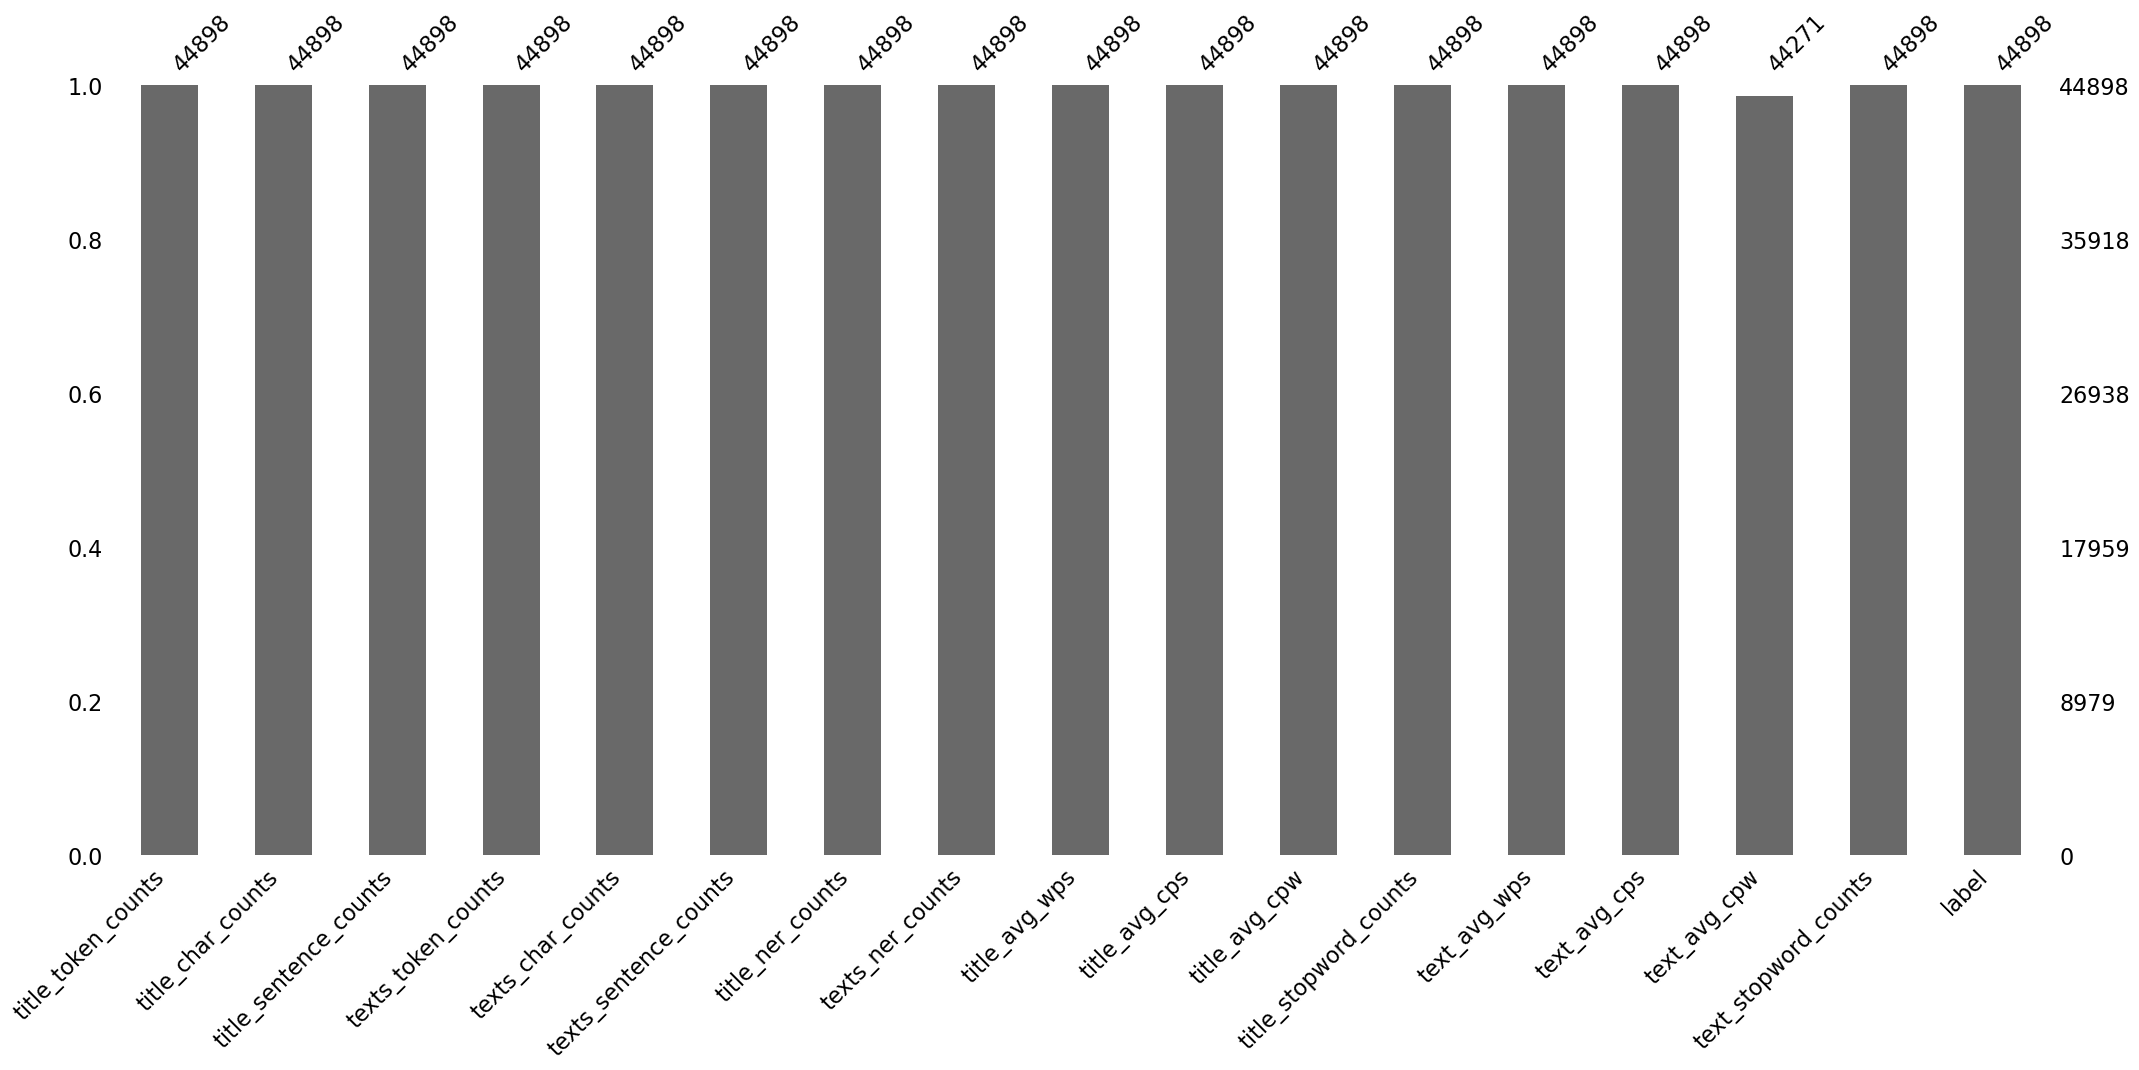

In [87]:
# See if there are missing values
msno.bar(count_df)

There are so few missing values that it is acceptable to remove them without imputation or other considerations.

In [88]:
# Remove na
count_df.dropna(axis=0, inplace=True)

# Check
count_df.shape

(44271, 17)

In [89]:
# Variables
y = count_df.label

x = count_df[[col for col in count_df.columns if col != 'label']]

# Split data set - train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

# Check sizing
print(f'Training set: {x_train.shape} | Test set: {x_test.shape}')

Training set: (30989, 16) | Test set: (13282, 16)


/tmp/ipykernel_26/3873347115.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(x_train.corr(), dtype=np.bool))


<Axes: >

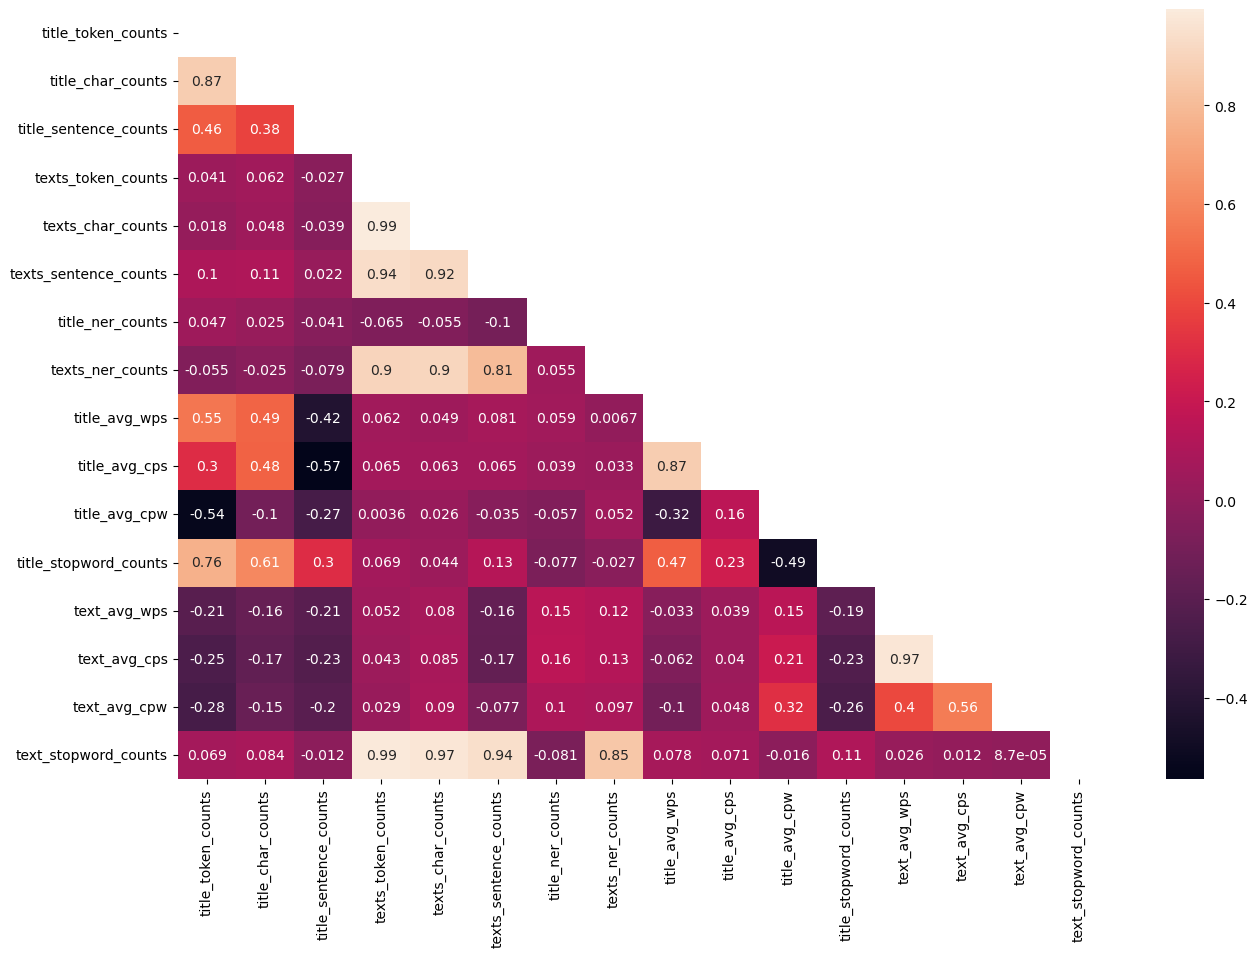

In [90]:
# Sizing
plt.figure(figsize=(15,10))

# Correlation matrix
mask = np.triu(np.ones_like(x_train.corr(), dtype=np.bool))
sns.heatmap(x_train.corr(), mask=mask, annot=True)

There is some notable multicollinearity among predictor variables. Before looking at VIF values, the data should be transformed.

In [91]:
# Square root transformation
def sqrtTfrm(x):
    return np.sqrt(x)

In [92]:
# Function Transformer
sqrt_transformer = FunctionTransformer(func=sqrtTfrm, validate=True)

# Initialize a pipeline
pipeline = Pipeline([('sqrt-tfrm', sqrt_transformer)])

# Get the transformed training data
x_train_tfrm = pipeline.fit_transform(x_train)

In [93]:
# Transform test sets
x_test_tfrm = pipeline.transform(x_test)

# Convert back to dataframes
x_test_tfrm_df = pd.DataFrame(x_test_tfrm, columns=x_test.columns)

In [94]:
# Convert back to dataframe for VIF
x_train_tfrm_df = pd.DataFrame(x_train_tfrm, columns=x_train.columns)

In [95]:
# Calculate VIF
vif_data = pd.DataFrame() 
vif_data["feature"] = x_train_tfrm_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(x_train_tfrm_df.values, i) for i in range(len(x_train_tfrm_df.columns))] 

# View
vif_data = vif_data.sort_values(by='VIF', ascending=False)
vif_data

,feature,VIF
3,texts_token_counts,8285.302867
12,text_avg_wps,6570.198423
13,text_avg_cps,5984.148960
9,title_avg_cps,5946.932559
4,texts_char_counts,5456.631180
0,title_token_counts,5119.838239
1,title_char_counts,5039.593722
8,title_avg_wps,4872.645928
10,title_avg_cpw,1203.510464
14,text_avg_cpw,986.462097


To reduce the cells used, the high VIF values will be removed iteratively. In the cell below.
'title_avg_wps',
                                          'text_avg_cps',
                                          'texts_char_counts',
                                          'title_token_counts',
                                          'text_stopword_counts'

In [96]:
# Start
tfrm_copy = x_train_tfrm_df.drop(columns=['texts_token_counts',
                                          'title_avg_cps',
                                          'text_avg_cps',
                                          'title_token_counts',
                                          'texts_char_counts',
                                          'text_avg_cpw',
                                          'texts_sentence_counts',
                                          'title_char_counts',
                                          'title_avg_cpw',
                                          'text_avg_wps',
                                          'texts_ner_counts',
                                          'title_avg_wps',
                                          'title_sentence_counts'])

# New VIF values
vif2 = [variance_inflation_factor(tfrm_copy.values, i) for i in range(len(tfrm_copy.columns))]

# Combine
vif2_list = list(zip(tfrm_copy.columns, vif2))

# Show
print(sorted(vif2_list, key=lambda x: -x[1]))

[('title_stopword_counts', 5.899026502021394), ('text_stopword_counts', 5.486732309863487), ('title_ner_counts', 4.524560246333411)]


In [97]:
# Build the final predictor set
x_train_final = x_train_tfrm_df.drop(columns=['texts_token_counts',
                                              'title_avg_cps',
                                              'text_avg_cps',
                                              'title_token_counts',
                                              'texts_char_counts',
                                              'text_avg_cpw',
                                              'texts_sentence_counts',
                                              'title_char_counts',
                                              'title_avg_cpw',
                                              'text_avg_wps',
                                              'texts_ner_counts',
                                              'title_avg_wps',
                                              'title_sentence_counts'])

# Check
x_train_final.head(3)

,title_ner_counts,title_stopword_counts,text_stopword_counts
0,1.000000,2.449490,16.970563
1,1.414214,1.414214,12.569805
2,2.000000,2.828427,8.185353


In [98]:
# Update the test sets
x_test_final = x_test_tfrm_df.drop(columns=['texts_token_counts',
                                              'title_avg_cps',
                                              'text_avg_cps',
                                              'title_token_counts',
                                              'texts_char_counts',
                                              'text_avg_cpw',
                                              'texts_sentence_counts',
                                              'title_char_counts',
                                              'title_avg_cpw',
                                              'text_avg_wps',
                                              'texts_ner_counts',
                                              'title_avg_wps',
                                              'title_sentence_counts'])

## Logistic Regression

Although the final set of predictors was chosen based on VIF scores, this analysis will also employ l1 regularization (lasso) and cross-validation to guard against potential overfitting.

In [99]:
# Initialize logistic regression
lr_base = LogisticRegression(penalty='l1', solver='saga', random_state=0, max_iter=200, n_jobs=-1)

In [100]:
# Cross validation
lr_cv_scores = cross_val_score(lr_base, x_train_final, y_train, cv=10)

In [101]:
# View the CV Scores
lr_cv_df = pd.DataFrame(lr_cv_scores, columns=['logistic_regression'])

# Show
lr_cv_df

,logistic_regression
0,0.771539
1,0.788964
2,0.774121
3,0.776057
4,0.774766
5,0.782833
6,0.777025
7,0.787028
8,0.776379
9,0.778890


In [102]:
# Fit the model
lr_base.fit(x_train_final, y_train)

LogisticRegression(max_iter=200, n_jobs=-1, penalty='l1', random_state=0,
                   solver='saga')

In [103]:
# Get the regression equation values
lr_base_intercept = lr_base.intercept_

# Get the coefficients
lr_base_coefs = lr_base.coef_

# Show
lr_base_df = pd.DataFrame(lr_base_coefs, columns=lr_base.feature_names_in_).T
lr_base_df.loc['intercept'] = lr_base_intercept
lr_base_df.loc['r2'] = lr_base.score(x_train_final, y_train)
lr_base_df

,0
title_ner_counts,1.496660
title_stopword_counts,-2.399992
text_stopword_counts,-0.025848
intercept,2.573265
r2,0.778986


In [104]:
# Run on the test set
y_lr = lr_base.predict(x_test_final)

In [105]:
# Classification report
lr_classification_report = classification_report(y_test, y_lr)
lr_dict = classification_report(y_test, y_lr, output_dict=True)

# Show
print(lr_classification_report)

              precision    recall  f1-score   support

        fake       0.80      0.75      0.78      6848
        true       0.75      0.80      0.78      6434

    accuracy                           0.78     13282
   macro avg       0.78      0.78      0.78     13282
weighted avg       0.78      0.78      0.78     13282



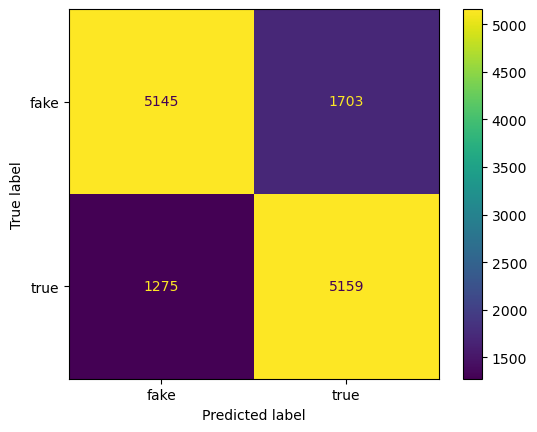

In [106]:
# Make a confusion matrix
lr_conf_matrix = confusion_matrix(y_test, y_lr)

# Visualize
lr_cmdisplay = ConfusionMatrixDisplay(lr_conf_matrix, display_labels=['fake', 'true'])

# Show
lr_cmdisplay.plot()

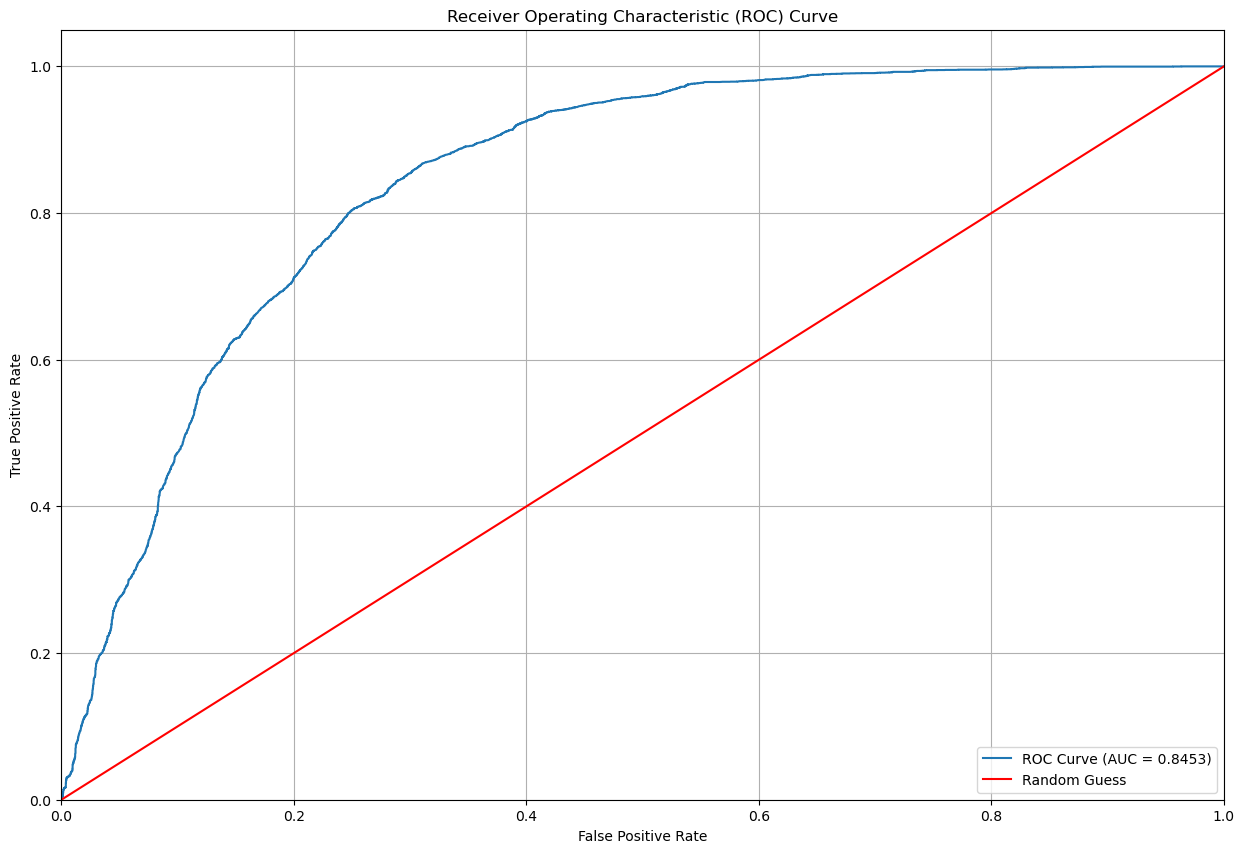

In [107]:
# Calculate ROC 
fpr, tpr, thresholds = roc_curve(y_test, lr_base.predict_proba(x_test_final)[:, 1], pos_label='true')

# You can also calculate the AUC (Area Under the Curve) using roc_auc_score
auc = roc_auc_score(y_test, lr_base.predict_proba(x_test_final)[:,1])

# Plot the ROC curve
plt.figure(figsize=(15, 10))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], color='red', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

It is possible to calculate feature importance from the coefficient values generated from the logistic regression.

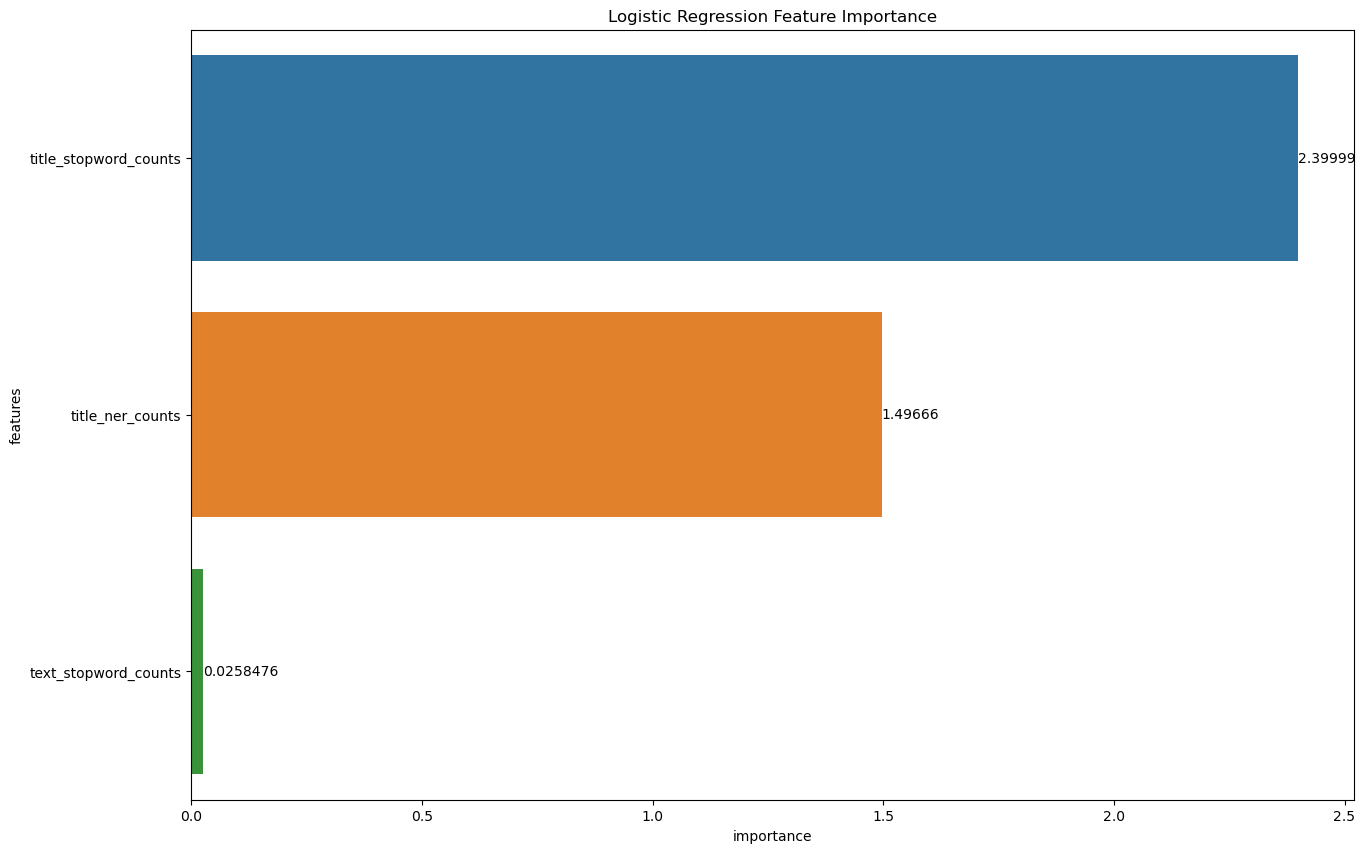

In [108]:
# Calculate feature importance
feature_names = list(x_train_final.columns)

# New Dataframe
feat_importance = pd.DataFrame({'features':feature_names,
                                'importance': np.abs(lr_base_coefs[0])}).sort_values('importance', ascending=False)

# Show
plt.figure(figsize=(15,10))
lr_feat_importance = sns.barplot(data=feat_importance, y='features', x='importance')
lr_feat_importance.bar_label(lr_feat_importance.containers[0])
lr_feat_importance.set_title('Logistic Regression Feature Importance')
plt.show()

## SVM

In [109]:
# Initialize the SVC
svc_base = SVC(probability=True, kernel='linear')

In [110]:
# Cross validation
svc_cv_scores = cross_val_score(svc_base, x_train_final, y_train, cv=10)

In [111]:
# View the CV Scores
svc_cv_df = pd.DataFrame(svc_cv_scores, columns=['svc'])

# Show
svc_cv_df

,svc
0,0.770571
1,0.789610
2,0.772507
3,0.775411
4,0.773475
5,0.784447
6,0.774443
7,0.790578
8,0.775734
9,0.777276


In [112]:
# Fit the model
svc_base.fit(x_train_final, y_train)

# Make predictions
y_svc = svc_base.predict(x_test_final)

In [113]:
# Classification report
svc_classification_report = classification_report(y_test, y_svc)
svc_dict = classification_report(y_test, y_svc, output_dict=True)

# Show
print(svc_classification_report)

              precision    recall  f1-score   support

        fake       0.81      0.74      0.77      6848
        true       0.75      0.81      0.78      6434

    accuracy                           0.77     13282
   macro avg       0.78      0.78      0.77     13282
weighted avg       0.78      0.77      0.77     13282



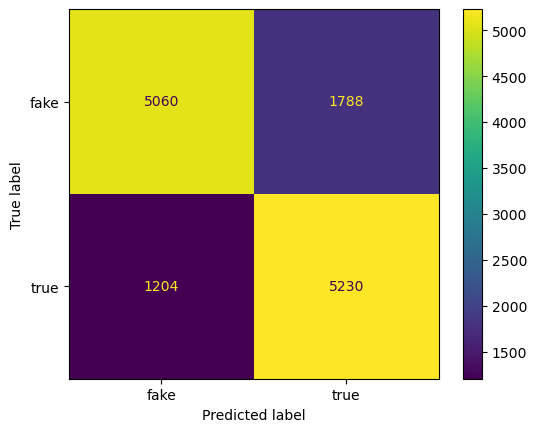

In [114]:
# Make a confusion matrix
svc_conf_matrix = confusion_matrix(y_test, y_svc)

# Visualize
svc_cmdisplay = ConfusionMatrixDisplay(svc_conf_matrix, display_labels=['fake', 'true'])

# Show
svc_cmdisplay.plot()

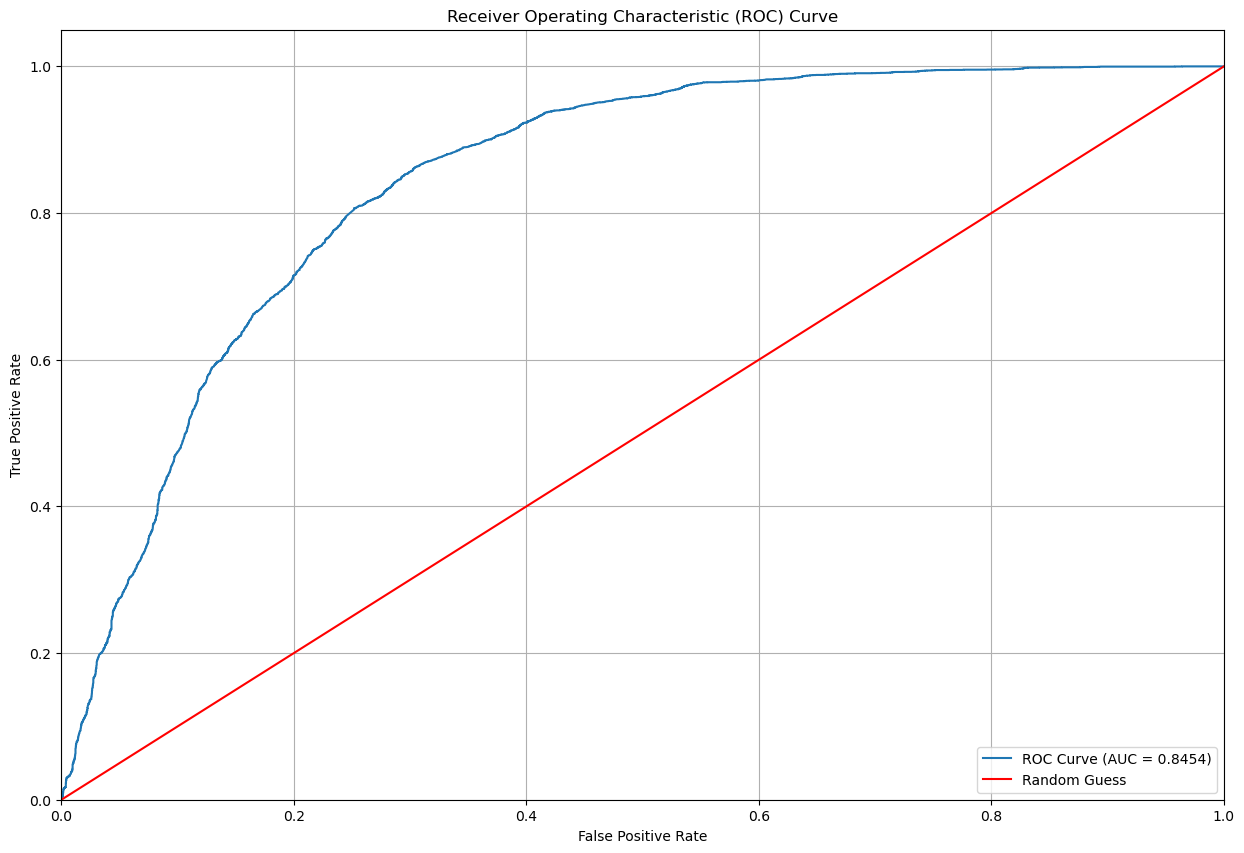

In [115]:
# Calculate ROC 
fpr, tpr, thresholds = roc_curve(y_test, svc_base.predict_proba(x_test_final)[:, 1], pos_label='true')

# You can also calculate the AUC (Area Under the Curve) using roc_auc_score
auc = roc_auc_score(y_test, svc_base.predict_proba(x_test_final)[:,1])

# Plot the ROC curve
plt.figure(figsize=(15, 10))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], color='red', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Feature importance can also be derived from a SVM classifier algorithm provided it uses a linear kernel.

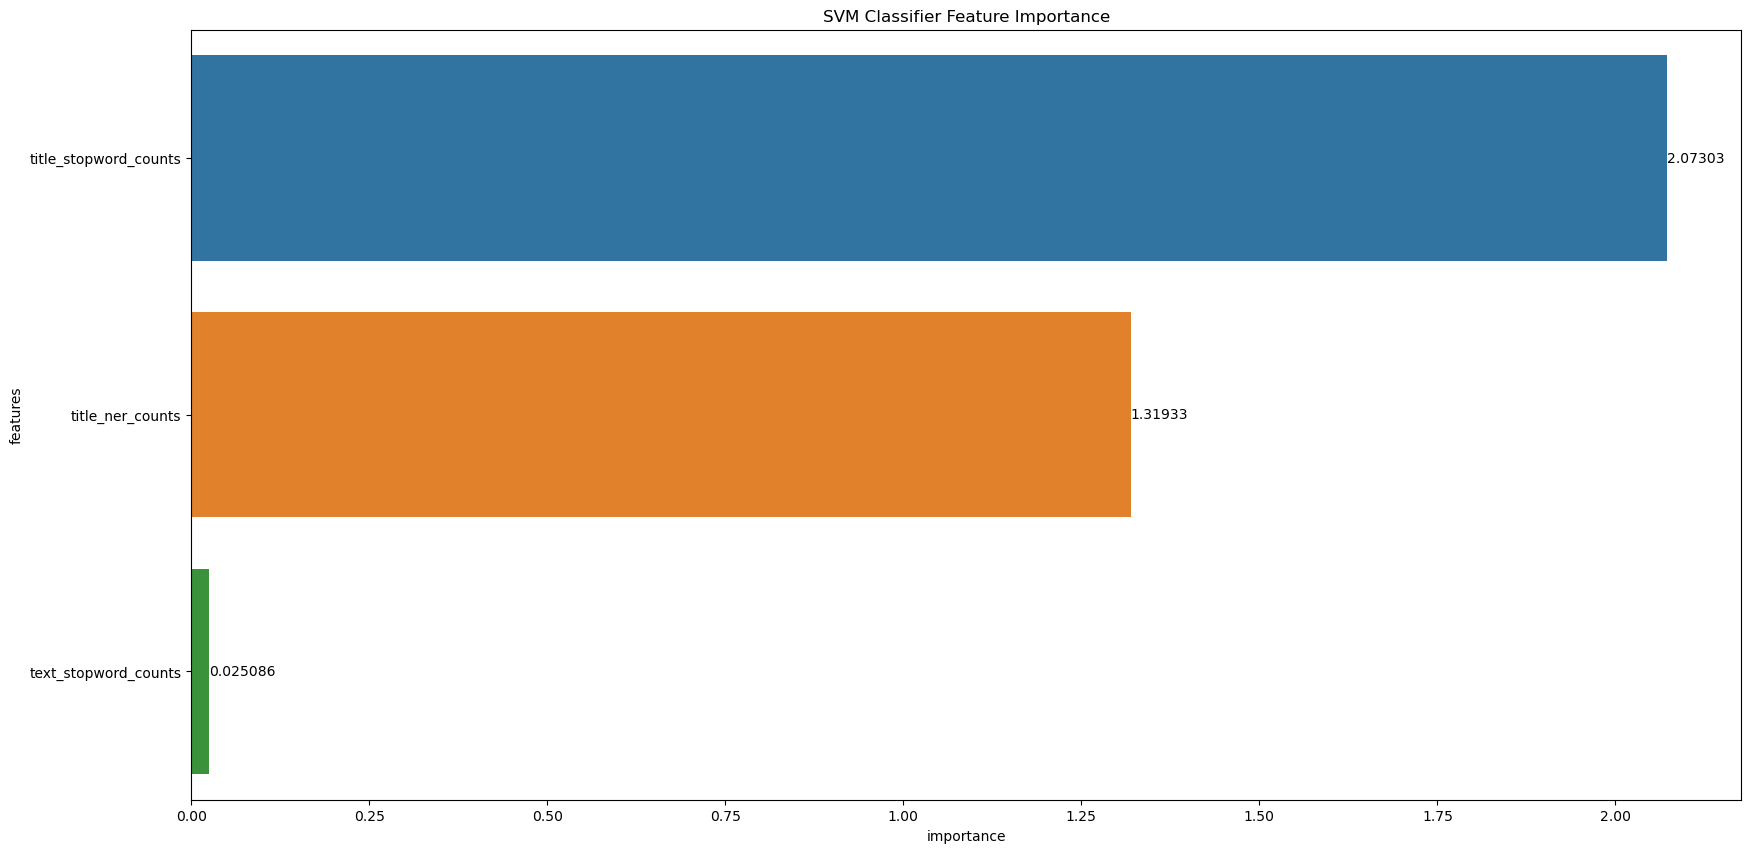

In [116]:
# Build dataframe for feature importance
feature_names = x_train_final.columns.tolist()
svc_base_coefs = svc_base.coef_[0]

# Create a datafram
svc_feat_imp = pd.DataFrame({'features': feature_names,
                             'importance': np.abs(svc_base_coefs)}).sort_values('importance', ascending=False)

# Visualization
plt.figure(figsize=(20,10))
svc_feat_bar = sns.barplot(data=svc_feat_imp, y='features', x='importance')
svc_feat_bar.bar_label(svc_feat_bar.containers[0])
svc_feat_bar.set_title('SVM Classifier Feature Importance')
plt.show()

## XGBoost

Despite the unexpectedly good results from the previous two algorithms, a more advanced algorithm like XGBoost is worth trying as literature seems to indicate a performance difference in discriminating fake news vs. real news based on algorithm complexity. Therefore, the purpose of this exploration is to determine whether or not there is any difference in performance using XGBoost.

- Please note that given the performance of the pervious two models, this portion of the exploration won't use GridSearch to test parameters.

In [117]:
# Parameters for xgboost
params = {'objective':'binary:logistic',
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 5, 
          'alpha': 10}

# Numeric conversion
y_train_xgb = [0 if label=='fake' else 1 for label in y_train]
y_test_xgb = [0 if label=='fake' else 1 for label in y_test]

# Convert to a datamatrix
xgb_training = xgb.DMatrix(x_train_final, y_train_xgb)
xgb_testing = xgb.DMatrix(x_test_final, y_test_xgb)

# Cross validation callbacks
cv_callbacks = []

# Cross validation
xgb_cv_df = cv(params=params, dtrain=xgb_training, early_stopping_rounds=3, nfold=10, metrics=['error','auc'], as_pandas=True, seed=0)

In [118]:
# See cross_validation results
xgb_cv_df

,train-error-mean,train-error-std,train-auc-mean,train-auc-std,test-error-mean,test-error-std,test-auc-mean,test-auc-std
0,0.369680,0.000773,0.662286,0.001018,0.369680,0.006961,0.661795,0.007602
1,0.296898,0.063940,0.768543,0.069056,0.296425,0.068815,0.769537,0.071360
2,0.256880,0.061670,0.816074,0.065382,0.259123,0.059078,0.815997,0.063405


Note that accuracy = 1-error, so it is easy to calculate the accuracy values for the training and test sets in each cv fold above.

In [119]:
# Run a classifier model with the parameters defined
xgbc_base = XGBClassifier(objective='binary:logistic',
                          colsample_bytree=0.3,
                          learning_rate = 0.1,
                          max_depth=5, 
                          eval_metric=['error','auc'],
                          alpha=10)

# Fit
xgbc_base.fit(x_train_final, y_train_xgb)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['error', 'auc'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [120]:
# Predictions
y_xgbc = xgbc_base.predict(x_test_final)

In [121]:
# Classification report
xgbc_classification_report = classification_report(y_test_xgb, y_xgbc)
xgbc_dict = classification_report(y_test_xgb, y_xgbc, output_dict=True)

# Show
print(xgbc_classification_report)

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      6848
           1       0.76      0.84      0.80      6434

    accuracy                           0.80     13282
   macro avg       0.80      0.80      0.80     13282
weighted avg       0.80      0.80      0.80     13282



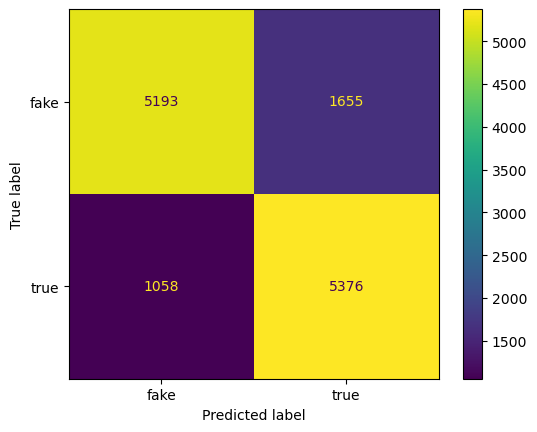

In [122]:
# Make a confusion matrix
xgbc_conf_matrix = confusion_matrix(y_test_xgb, y_xgbc)

# Visualize
xgbc_cmdisplay = ConfusionMatrixDisplay(xgbc_conf_matrix, display_labels=['fake', 'true'])

# Show
xgbc_cmdisplay.plot()

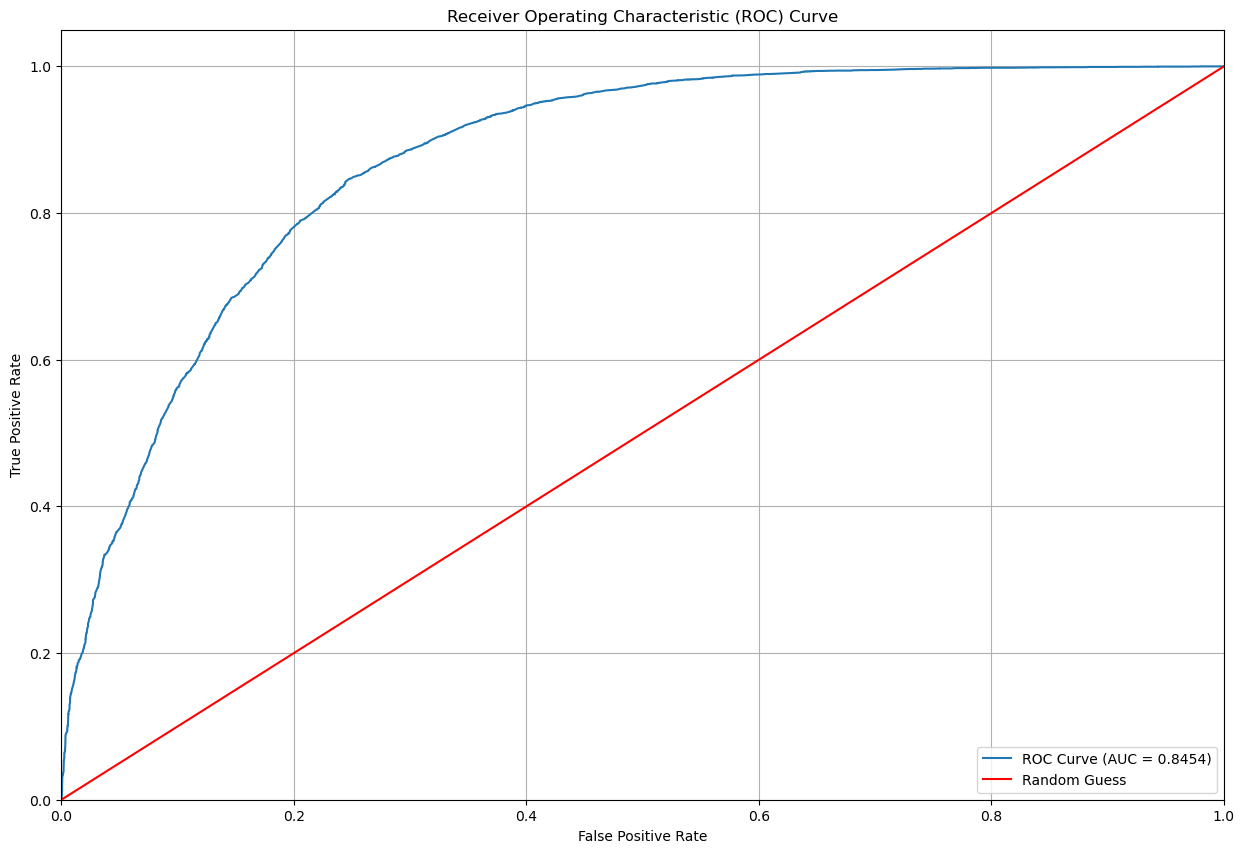

In [123]:
# Calculate ROC 
fpr, tpr, thresholds = roc_curve(y_test_xgb, xgbc_base.predict_proba(x_test_final)[:,1], pos_label=1)

# You can also calculate the AUC (Area Under the Curve) using roc_auc_score
auc = roc_auc_score(y_test_xgb, svc_base.predict_proba(x_test_final)[:,1])

# Plot the ROC curve
plt.figure(figsize=(15, 10))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], color='red', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

To get a better understanding of this model, it is possible to determine the importance of each feature included in the model.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1500x1000 with 0 Axes>

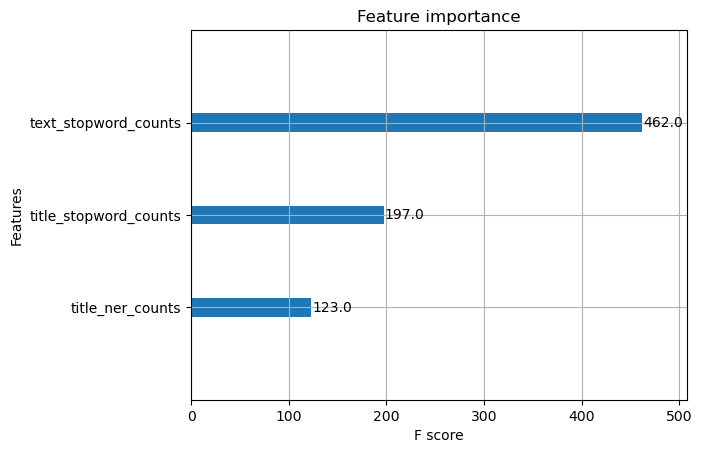

In [124]:
# Sizing
plt.figure(figsize = (15, 10))

# Use plot_importance
xgb_plot = xgb.plot_importance(xgbc_base)

# View
xgb_plot

## Summary

1. Classification metrics
2. Confusion Matrices
3. Feature Importance

### Classification Metrics

Based upon the metrics below, the logistic regression and SVM classifier models appeared to perform fairly similarly. The XGBoost classifier had slightly better performance. More than likely, this is due to a performance gain stemming from the nature of boosting algorithms.

Although it might seem most intuitive to focus on accuracy for each model, it's important to consider the F1 score.

$F1 score = 2*(\frac{precision*recall}{precision+recall})$

As the value of the F1 score approaches 1.0, the better the model performance is (in terms of detecting each class as it should). This means that model has higher values for precision (of all positive predictions, what proportion is actually positive) and recall (of all actual positive cases, how many are predicted positive).

For this activity, XGBoost classifier yielded the highest F1 score of 0.80. Logistic regression and SVM classifier both yielded F1 scores of 0.78 and 0.77, respectively.

In [125]:
# Print out each model as a dataframe for comparison
class_dict_list = [lr_dict, svc_dict, xgbc_dict]
dict_name = ['Logistic Regression', 'SVM Classifier', 'XGBoost Classifier']

# Iterate
for name,class_dict in zip(dict_name, class_dict_list):
    print(name.upper())
    if name != 'XGBoost Classifier':
        print(f"Fake:")
        for k,v in class_dict['fake'].items():
            print(f"\t{k}: {class_dict['fake'][k]}")
        print(f"True:")
        for k,v in class_dict['true'].items():
            print(f"\t{k}: {class_dict['true'][k]}")
        print('-------------------------------------------------------------------------')
    else:
        print(f"Fake:")
        for k,v in class_dict['0'].items():
            print(f"\t{k}: {class_dict['0'][k]}")
        print(f"True:")
        for k,v in class_dict['1'].items():
            print(f"\t{k}: {class_dict['1'][k]}")
    

LOGISTIC REGRESSION
Fake:
	precision: 0.8014018691588785
	recall: 0.7513142523364486
	f1-score: 0.7755501959602049
	support: 6848
True:
	precision: 0.7518216263480035
	recall: 0.8018340068386696
	f1-score: 0.7760228640192539
	support: 6434
-------------------------------------------------------------------------
SVM CLASSIFIER
Fake:
	precision: 0.8077905491698595
	recall: 0.7389018691588785
	f1-score: 0.7718120805369126
	support: 6848
True:
	precision: 0.7452265602735823
	recall: 0.8128691327323594
	f1-score: 0.7775795420755278
	support: 6434
-------------------------------------------------------------------------
XGBOOST CLASSIFIER
Fake:
	precision: 0.8307470804671253
	recall: 0.7583235981308412
	f1-score: 0.7928849530498512
	support: 6848
True:
	precision: 0.7646138529369934
	recall: 0.8355610817531862
	f1-score: 0.7985146676568883
	support: 6434


### Confusion Matrices

The models all perform slightly differently in terms of the amounts of fake and true articles predicted. However, one trend emerged, and it's that each model overpredicted true articles. Further details can be seen below.

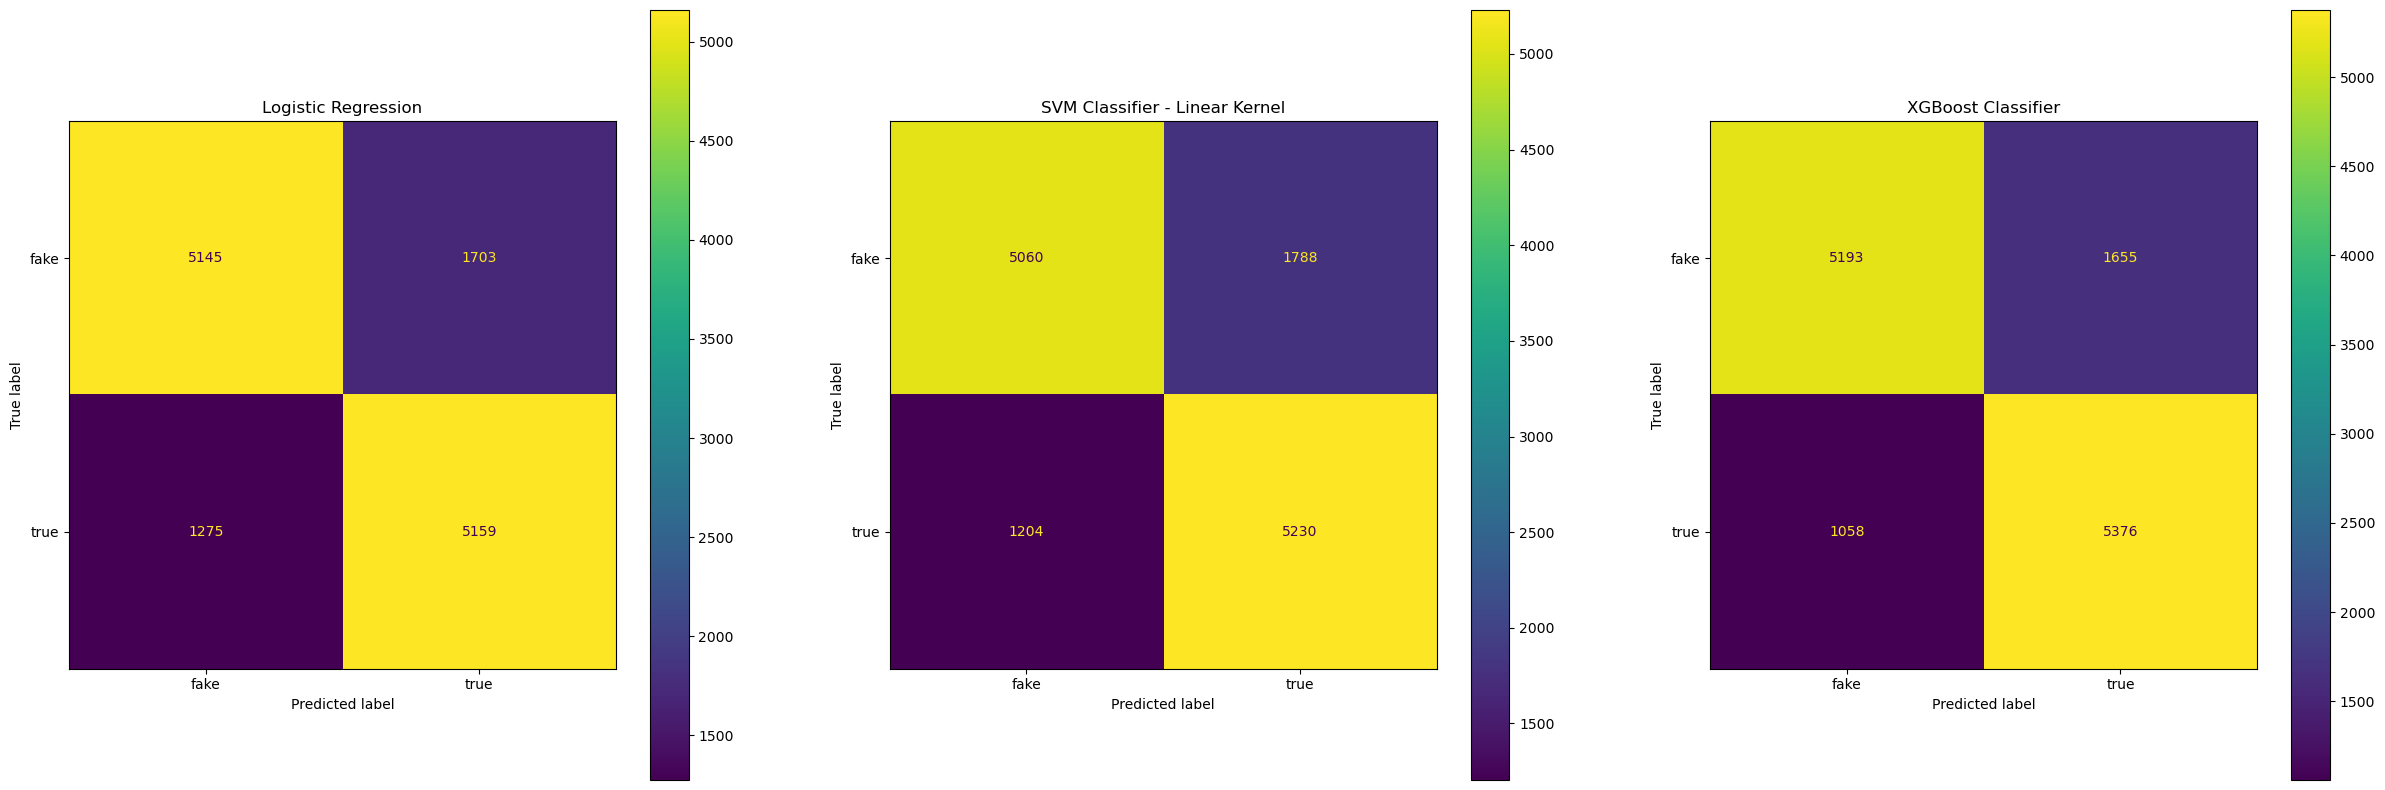

In [126]:
## Confusion Matrices
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(30, 10))

# Axes
lr_cmdisplay.plot(ax=ax0)
ax0.set_title('Logistic Regression')

svc_cmdisplay.plot(ax=ax1)
ax1.set_title('SVM Classifier - Linear Kernel')

xgbc_cmdisplay.plot(ax=ax2)
ax2.set_title('XGBoost Classifier')

plt.show()

In [127]:
# Build a summary table
print(tabulate({'Model':['Logistic Regression','SVM Classifier', 'XGBoost Classifier', 'Actual Classifications'],
                'Fake': [5145+1275, 5060+1204, 5193+1058, len(y_test[y_test=='fake'])],
                'True': [1703+5159, 1788+5230, 1655+5376, len(y_test[y_test=='true'])],
                'Performance Description': ['Overclassification of trues', 'Overclassification of trues', 'Overclassification of trues', '---']},
               headers='keys'))

Model                     Fake    True  Performance Description
----------------------  ------  ------  ---------------------------
Logistic Regression       6420    6862  Overclassification of trues
SVM Classifier            6264    7018  Overclassification of trues
XGBoost Classifier        6251    7031  Overclassification of trues
Actual Classifications    6848    6434  ---


### Feature Importance

__Note:__ The XGBoost Classifier chart looks different because the library's plot_importance() function was used.

As can be seen from the charts below, each model had differences in the importance of features. For example, the most important feature in logistic regression and the SVM classifier analyses was title_stopword_counts (amount of characters in a title), but it was texts_stopword_counts (number of named entities in a text) in the XGBoost Classifier analysis. For the logistic regression and the SVM classifier, text_stopword_counts was the least imporant, while title_ner_counts was least important for the XGBoost Classifier.

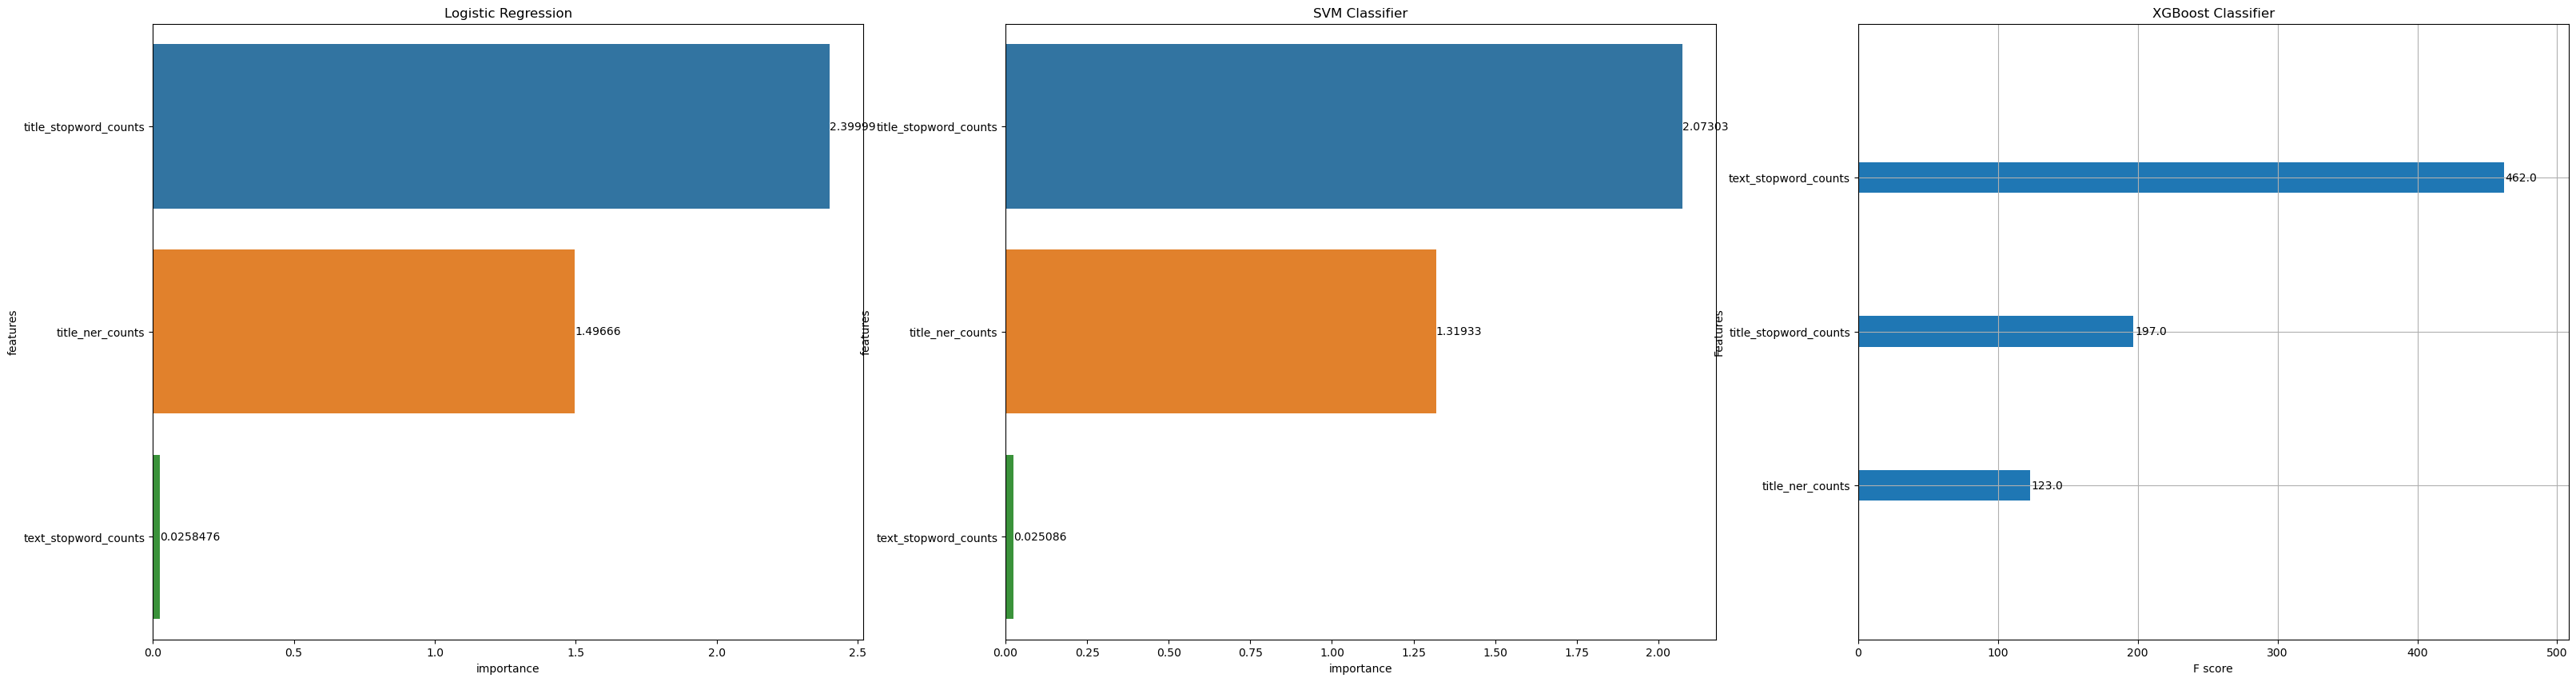

In [128]:
## Confusion Matrices
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(39, 10))

# Axes
sns.barplot(data=feat_importance, y='features', x='importance', ax=ax0)
ax0.bar_label(ax0.containers[0])
ax0.set_title('Logistic Regression')

sns.barplot(data=svc_feat_imp, y='features', x='importance', ax=ax1)
ax1.bar_label(ax1.containers[0])
ax1.set_title('SVM Classifier')

xgb.plot_importance(xgbc_base, ax=ax2)
ax2.set_title('XGBoost Classifier')

plt.show()